<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Stocks/Norway/DNB/DNB_1D_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "dnb.ol"
data_resample = '1D'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = True
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

[*********************100%***********************]  1 of 1 downloaded


Open    High     Low   Close  Adj Close    Volume
Date                                                           
2009-01-02   26.07   27.06   25.92   27.06      19.00   1596916
2009-01-05   27.54   27.73   25.31   25.64      18.00   4045796
2009-01-06   25.45   25.59   24.12   24.21      17.00  10930892
2009-01-07   24.36   24.78   23.74   24.50      17.20   8012013
2009-01-08   24.21   25.69   23.74   25.69      18.03   7219663
...            ...     ...     ...     ...        ...       ...
2018-12-19  144.25  145.20  142.85  143.65     136.50   1689322
2018-12-20  141.50  142.40  139.65  139.65     132.69   2609371
2018-12-21  139.00  139.60  136.80  138.50     131.60   4492011
2018-12-27  140.00  140.00  135.50  136.40     129.61   2380658
2018-12-28  137.80  139.30  136.60  138.15     131.27   1871025

[2511 rows x 6 columns]

Open         High          Low        Close    Adj Close        Volume
count  2511.000000  2511.000000  2511.000000  2511.000000  2511.000000  2.511000e+03
mean     99.328248   100.338375    98.237806    99.323712    81.950191  3.374181e+06
std      35.537827    35.588108    35.490705    35.536804    36.148386  2.442291e+06
min      15.760000    18.420000    14.150000    15.860000    11.130000  0.000000e+00
25%      69.800000    70.650000    69.000000    69.800000    52.000000  1.873061e+06
50%      98.150000    98.950000    96.950000    98.000000    81.390000  2.689587e+06
75%     126.750000   127.900000   125.600000   126.650000   104.825000  4.150978e+06
max     173.500000   174.200000   172.100000   173.150000   164.530000  3.512639e+07

7

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open    High     Low   Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear        mama        fama      SAREXT      DEMA_8       EMA_8      KAMA_8  MIDPOINT_8  MIDPRICE_8    SAR_0.08      SMA_8      TEMA_8   TRIMA_8       WMA_8     MA_8_0    MAVP_8_0      T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5      MA_8_1    MAVP_8_1      T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2009-03-13   24.40   25.59   24.17   24.88      17.46   6616458   13          4         72             31             0               0               0                 0      3        1    11        4             0          11   22.671692   22.249426   20.315400   23.921173   23.142484   22.378327      22.650      22.885   20.571600   22.54750   24.488672   22.2515   23.165000   22.54750   24.356667   22.152606               25.673340                 22.54750               19.421660               27.236260                 22.54750               17.858740               28.799180                 22.54750               16.295820               30.362100                 22.54750               14.732900   23.142484   24.153622   22.147650               26.268324                23.142484               20.016644               27.831244                23.142484               18.453724               29.394164                23.142484               16.890804               30.957084   
2009-03-16   25.16   25.59   24.93   25.50      17.90   5104008   16          0         75             31             0               0               0                 0      3        1    12        0             1          12   22.813107   22.263518   20.526384   24.679495   23.666377   22.693716      22.960      22.885   20.973072   22.96875   25.303218   22.9445   23.821111   22.96875   25.190000   22.263862               26.620126                 22.96875               19.317374               28.445813                 22.96875               17.491687               30.271501                 22.96875               15.665999               32.097189                 22.96875               13.840311   23.666377   25.164532   22.288148               27.317752                23.666377               20.015001               29.143440                23.666377               18.189313               30.969128                23.666377               16.363625               32.794816   
2009-03-17   25.45   26.59   25.16   26.59      18.66   51

Open         High          Low        Close    Adj Close        Volume          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2.461000e+03  2461.000000  2461.000000  2461.000000    2461.000000   2461.000000     2461.000000     2461.000000       2461.000000  2461.000000  2461.000000  2461.000000  2461.000000   2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000  2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000  2461.000000  2461.000000  2461.000000             2461.000000              2461.000000             2461.000000             2461.000000              2461.000000             2461.000000             2461.000000   
mean    100.890041   101.904604    99.798005   100.887956    83.296701  3.270255e+06    15.734254     2.000813   186.229175      30.457538      0.031694        0.027631        0.008533          0.007720     6.626168     2.542462    27.087769     2.000813      2.001219    27.087769   100.725744   100.290676     2.862108   100.893016   100.719971   100.703185   100.676390   100.530666   100.047739   100.722101   100.889905   100.722985   100.778324   100.722101   100.856948   100.370770              103.958037               100.722101               97.486166              105.576004               100.722101               95.868198              107.193972               100.722101               94.250231              108.811940               100.722101               92.632263   100.719971   100.855141   100.424135              103.955906               100.719971               97.484035              105.573874               100.719971               95.866068              107.191841   
std      34.145854    34.189239    34.099405    34.139094    35.243634  2.212197e+06     8.726937     1.408453   103.708172       0.789878      0.175221        0.163947        0.091999          0.087544     3.401104     1.109606    14.830931     1.408453      1.409174    14.830931    34.132257    34.140939   105.793154    34.154322    34.163873    34.331959    34.171175    34.125871    34.273116    34.186484    34.146776    34.196679    34.161752    34.186484    34.144644    34.283536               34.391272                34.186484               34.064360               34.524229                34.186484               34.034598               34.677260                34.186484               34.025790               34.850101                34.186484               34.037951    34.163873    34.138878    34.269727               34.372383                34.163873               34.038046               34.507199                34.163873               34.006449               34.662084   
min      24.400000    25.590000    24.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close  Adj Close    Volume  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
2009-03-13  0.000000  0.000000  0.000000  0.000000   0.000000   6616458   13          4         72             31             0               0               0                 0      3        1    11        4             0          11  0.000000  0.000000  0.566482  0.000000  0.000000  0.000000    0.000000    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000695                0.000000                 0.000000                0.002504                0.000000                 0.000000                0.005663                0.000000                 0.000000                0.008757  0.000000  0.000000  0.000000                0.000000                 0.000000                0.000011                0.000000                 0.000000                0.001894                0.000000                 0.000000                0.005073                0.000000                 0.000000   
2009-03-16  0.005097  0.000000  0.005138  0.004182   0.002992   5104008   16          0         75             31             0               0               0                 0      3        1    12        0             1          12  0.000950  0.000095  0.567097  0.005096  0.003524  0.002112    0.002083    0.000000  0.002613  0.002825  0.005475  0.004626  0.004408  0.002825  0.005618  0.000748                0.006330                 0.002825                0.000000                0.008034                 0.002825                0.000075                0.009715                 0.002825                0.001537                0.011374                 0.002825                0.002970  0.003524  0.006803  0.000944                0.007043                 0.003524                0.000000                0.008761                 0.003524                0.000135                0.010461                 0.003524                0.001604                0.012144                 0.003524   
2009-03-17  0.007042  0.006729  0.006692  0.0115

140177

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpb0zm3yle
  JVM stdout: /tmp/tmpb0zm3yle/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpb0zm3yle/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 18 days
H2O cluster name:           H2O_from_python_unknownUser_onsu06
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper left')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.503498  18.399281              0.500000  0.735186  0.540498
1              DeepLearning_1_AutoML_20190906_003136  0.502166  15.292613              0.494803  0.671848  0.451379
2  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.501466  15.500908              0.494803  0.674716  0.455242
3  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.500000   0.689254              0.500000  0.498052  0.248056
4  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.500000   0.689222              0.500000  0.498036  0.248040
5  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.500000   0.689145              0.500000  0.497997  0.248001
6  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.500000   0.689182              0.500000  0.498016  0.248020
7  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.498534  18.270563              0.500000  0.735762  0.541346
8  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.497834  18.548492              0.500000  0.736445  0.542351
9  DeepLearning_grid_1_AutoML_20190906_003136_mod...  0.490572  14.934252              0.500000  0.674701  0.455222

variable  relative_importance  scaled_importance  percentage
0             CDLUNIQUE3RIVER             1.000000           1.000000    0.003574
1            CDLSTICKSANDWICH             0.990007           0.990007    0.003538
2                 CDLPIERCING             0.978181           0.978181    0.003496
3           CDLSTALLEDPATTERN             0.972650           0.972650    0.003476
4             CDLADVANCEBLOCK             0.957985           0.957985    0.003423
...                       ...                  ...                ...         ...
1036                   EMA_14             0.206162           0.206162    0.000737
1037                MAVP_24_5             0.204511           0.204511    0.000731
1038                  MA_14_2             0.201445           0.201445    0.000720
1039  BBANDS_lowerband_14_6_4             0.197573           0.197573    0.000706
1040      CDLGAPSIDESIDEWHITE             0.189584           0.189584    0.000677

[1041 rows x 4 columns]

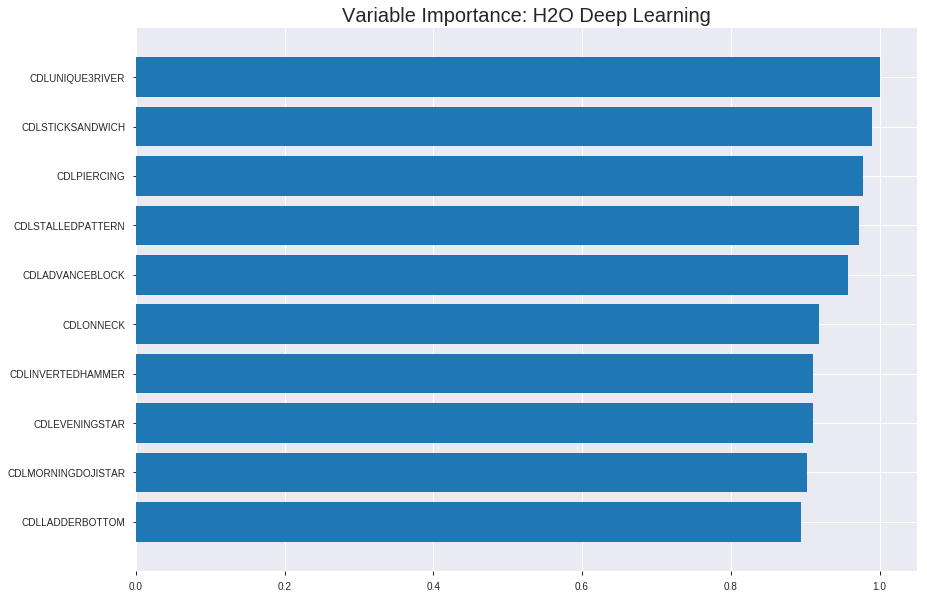

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_003136_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2596882074315073
RMSE: 0.5095961218764398
LogLoss: 0.7378562280027448
Mean Per-Class Error: 0.41085436302827605
AUC: 0.6125826830174655
pr_auc: 0.6336879776388121
Gini: 0.2251653660349311
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.05021360389715867: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      36   789   0.9564   (789.0/825.0)
1      15   882   0.0167   (15.0/897.0)
Total  51   1671  0.4669   (804.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0502136    0.686916  381
max f2                       0.0115326    0.845124  396
max f0point5                 0.338998     0.607083  257
max accuracy                 0.343265     0.587108  255
max precision                0.996693     1         0
max recall                   0.00296359   1         399
max specificity              0.996693     1         0
max absolute_mcc             0.498877     0.18431   171
max min_per_class_accuracy   0.418432     0.575758  213
max mean_per_class_accuracy  0.498877     0.589146  171

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 42.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.88601            1.81308   1.81308            0.944444         0.936826   0.944444                    0.936826            0.0189521       0.0189521                  81.3081    81.3081
    2        0.0203252                   0.856546           1.46803   1.64548            0.764706         0.871348   0.857143                    0.905023            0.0144928       0.0334448                  46.8031    64.5485
    3        0.0301974                   0.835471           1.24218   1.51364            0.647059         0.847077   0.788462                    0.886079            0.0122631       0.0457079                  24.218     51.3635
    4        0.0400697                   0.805379           1.12925   1.41893            0.588235         0.823622   0.73913                     0.870691            0.0111483       0.0568562                  12.9254    41.8933
    5        0.0505226                   0.78601            1.27982   1.39015            0.666667         0.795523   0.724138                    0.855139            0.0133779       0.0702341                  27.9822    39.0151
    6        0.100465                    0.718199           1.42864   1.40928            0.744186         0.751532   0.734104                    0.803635            0.0713489       0.141583                   42.8638    40.9283
    7        0.150407                    0.661054           1.20541   1.34159            0.627907         0.683585   0.698842                    0.763773            0.0602007       0.201784                   20.5413    34.1589
    8        0.200348                    0.612954           1.11612   1.28539            0.581395         0.634902   0.669565                    0.731648            0.0557414       0.257525                   11.6124    28.5386
    9        0.300232                    0.540079           1.10496   1.22536            0.575581         0.574371   0.638298                    0.679324            0.110368        0.367893                   10.4962    22.5361
    10       0.400116                    0.479145           1.11612   1.19809            0.581395         0.510395   0.624093                    0.637153            0.111483        0.479376                   11.6124    19.8091
    11       0.5                         0.419675           0.948705  1.14827            0.494186         0.44675    0.598142                    0.599117            0.0947603       0.574136                   -5.1295    14.8272
    12       0.599884                    0.366873           0.99335   1.12248            0.517442         0.394827   0.584705                    0.565101            0.0992196       0.673356                   -0.665007  12.2477
    13       0.699768                    0.312945           0.926383  1.09449            0.482558         0.337542   0.570124                    0.53262             0.0925307       0.765886                   -7.36175   9.44865
    14       0.799652                    0.246475           0.758964  1.05258            0.395349         0.284081   0.548293                    0.501575            0.0758082       0.841695                   -24.1036   5.25766
    15       0.899535                    0.156265           0.81477   1.02617            0.424419         0.200914   0.534538                    0.46819             0.0813824       0.923077                   -18.523    2.61707
    16       1                           0.00211024         0.765674  1                  0.398844         0.0833946  0.520906  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.374092059027818
RMSE: 0.611630655729271
LogLoss: 5.582359197110341
Mean Per-Class Error: 0.46176176176176176
AUC: 0.5145311978645312
pr_auc: 0.5417142338836282
Gini: 0.02906239572906233
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.2477761509225556e-59: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.24778e-59  0.708661  361
max f2                       3.24778e-59  0.858779  361
max f0point5                 3.24778e-59  0.603217  361
max accuracy                 0.0168471    0.556911  341
max precision                0.0686548    0.576119  334
max recall                   3.24778e-59  1         361
max specificity              0.960097     0.995495  0
max absolute_mcc             0.693551     0.102912  19
max min_per_class_accuracy   0.301448     0.5       243
max mean_per_class_accuracy  0.0168471    0.538238  341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 27.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.827963           0.364444  0.364444           0.2              0.897528     0.2                         0.897528            0.0037037       0.0037037                  -63.5556  -63.5556
    2        0.0203252                   0.790867           0.728889  0.546667           0.4              0.808037     0.3                         0.852782            0.00740741      0.0111111                  -27.1111  -45.3333
    3        0.0304878                   0.745937           0.728889  0.607407           0.4              0.76628      0.333333                    0.823948            0.00740741      0.0185185                  -27.1111  -39.2593
    4        0.0406504                   0.692935           0.364444  0.546667           0.2              0.721374     0.3                         0.798305            0.0037037       0.0222222                  -63.5556  -45.3333
    5        0.050813                    0.663469           1.82222   0.801778           1                0.67822      0.44                        0.774288            0.0185185       0.0407407                  82.2222   -19.8222
    6        0.101626                    0.569956           1.09333   0.947556           0.6              0.602345     0.52                        0.688316            0.0555556       0.0962963                  9.33333   -5.24444
    7        0.150407                    0.532159           1.13889   1.00961            0.625            0.550537     0.554054                    0.643631            0.0555556       0.151852                   13.8889   0.960961
    8        0.20122                     0.491457           0.801778  0.957127           0.44             0.510138     0.525253                    0.609921            0.0407407       0.192593                   -19.8222  -4.28732
    9        0.300813                    0.431434           1.11565   1.00961            0.612245         0.460051     0.554054                    0.560302            0.111111        0.303704                   11.5646   0.960961
    10       0.400407                    0.361548           1.07846   1.02673            0.591837         0.400632     0.563452                    0.520587            0.107407        0.411111                   7.8458    2.67343
    11       0.5                         0.296799           0.892517  1                  0.489796         0.329045     0.54878                     0.482434            0.0888889       0.5                        -10.7483  0
    12       0.599593                    0.201703           1.00408   1.00068            0.55102          0.249912     0.549153                    0.443812            0.1             0.6                        0.408163  0.0677966
    13       0.699187                    0.00133096         1.33878   1.04884            0.734694         0.123462     0.575581                    0.398181            0.133333        0.733333                   33.8776   4.88372
    14       1                           0                  0.886486  1                  0.486486         5.27068e-07  0.54878                     0.278403            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 00:35:07  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 00:35:08  3 min 27.393 sec  414 obs/sec       0.268873  1             463        0.671414         5.53833             -0.806345      0.511691        0.284261           1.19983          0.479094                         0.666705           6.88677               -0.79507         0.476351          0.393191             0.886486           0.45122
    2019-09-06 00:35:21  3 min 40.118 sec  497 obs/sec       3.62834   13            6248       0.643244         2.85952             -0.657952      0.554663        0.484501           0.746563         0.479094                         0.683871           7.92362               -0.888694        0.515048          0.54535              1.45778            0.45122
    2019-09-06 00:35:34  3 min 53.314 sec  509 obs/sec       7.2439    26            12474      0.547002         1.10889             -0.198941      0.633691        0.594679           1.70643          0.415796                         0.662722           7.48891               -0.773683        0.525876          0.555743             0.728889           0.45122
    2019-09-06 00:35:47  4 min  6.495 sec  501 obs/sec       10.5848   38            18227      0.577686         1.31585             -0.337221      0.623961        0.592495           1.70643          0.424506                         0.656293           6.86706               -0.739436        0.529346          0.554711             0.728889           0.45122
    2019-09-06 00:36:01  4 min 19.808 sec  506 obs/sec       14.2305   51            24505      0.580265         1.2735              -0.34919       0.590003        0.554262           1.49313          0.447735                         0.642165           6.74829               -0.665355        0.517067          0.56253              0.728889           0.45122
    2019-09-06 00:36:14  4 min 33.385 sec  515 obs/sec       18.18     65            31306      0.497222         0.701015            0.00934854     0.624669        0.645125           1.59978          0.443089                         0.604378           6.04063               -0.475131        0.504738          0.528988             0                  0.45122
    2019-09-06 00:36:27  4 min 46.614 sec  522 obs/sec       22.0627   79            37992      0.488107         0.670383            0.0453375      0.627225        0.617493           1.49313          0.412892                         0.59983            5.90681               -0.453015        0.524766          0.571688             1.45778            0.45122
    2019-09-06 00:36:41  4 min 59.784 sec  528 obs/sec       25.9338   93            44658      0.53648          0.869527            -0.15326       0.574418        0.548324           0.853214         0.426829                         0.611835           5.83459               -0.511755        0.537671          0.580489             1.45778            0.45122
    2019-09-06 00:36:54  5 min 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
CDLUNIQUE3RIVER          1.0                    1.0                  0.0035736059844587095
CDLSTICKSANDWICH         0.990007221698761      0.990007221698761    0.0035378957321200327
CDLPIERCING              0.9781808257102966     0.9781808257102966   0.003495632852641078
CDLSTALLEDPATTERN        0.972650408744812      0.972650408744812    0.00347586932147667
CDLADVANCEBLOCK          0.9579851031303406     0.9579851031303406   0.003423461297568879
---                      ---                    ---                  ---
EMA_14                   0.2061624825000763     0.2061624825000763   0.0007367434812331366
MAVP_24_5                0.20451082289218903    0.20451082289218903  0.000730841100574102
MA_14_2                  0.20144528150558472    0.20144528150558472  0.000719886063529327
BBANDS_lowerband_14_6_4  0.19757258892059326    0.19757258892059326  0.0007060465861316326
CDLGAPSIDESIDEWHITE      0.18958377838134766    0.18958377838134766  0.0006774977249798777


See the whole table with table.as_data_frame()


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5034981343283582)

('logloss', 18.399280970122756)

('mean_per_class_error', 0.49620202558635396)

('rmse', 0.7351856441969558)

('mse', 0.5404979314332928)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


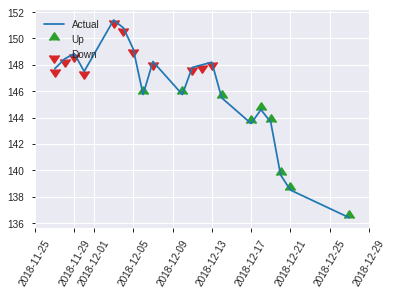


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5404979314332928
RMSE: 0.7351856441969558
LogLoss: 18.399280970122756
Mean Per-Class Error: 0.49620202558635396
AUC: 0.5034981343283582
pr_auc: 0.5581198510667021
Gini: 0.006996268656716431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 8.353291179092348e-78: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       8.35329e-78  0.705263   12
max f2                       8.35329e-78  0.856777   12
max f0point5                 8.35329e-78  0.599284   12
max accuracy                 8.35329e-78  0.544715   12
max precision                0.482715     1          0
max recall                   8.35329e-78  1          12
max specificity              0.482715     1          0
max absolute_mcc             0.482715     0.0584082  0
max min_per_class_accuracy   2.28978e-36  0.0522388  11
max mean_per_class_accuracy  2.28978e-36  0.503798   11

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.75 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.442366           1.22388  1.22388            0.666667         0.473298     0.666667                    0.473298            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   0.000646416        0.91791  1.10149            0.5              0.212336     0.6                         0.368913            0.00746269      0.0223881                  -8.20896   10.1493
    3        0.0325203                   7.60339e-13        0.61194  0.91791            0.333333         0.000147697  0.5                         0.230626            0.00746269      0.0298507                  -38.806    -8.20896
    4        0.0406504                   8.14206e-32        0.91791  0.91791            0.5              2.01128e-28  0.5                         0.184501            0.00746269      0.0373134                  -8.20896   -8.20896
    5        0.0528455                   1.24342e-75        1.22388  0.988519           0.666667         2.06693e-36  0.538462                    0.141924            0.0149254       0.0522388                  22.3881    -1.14811
    6        1                           0                  1.00064  1                  0.545064         1.9106e-78   0.544715                    0.00750003          0.947761        1                          0.0640574  0

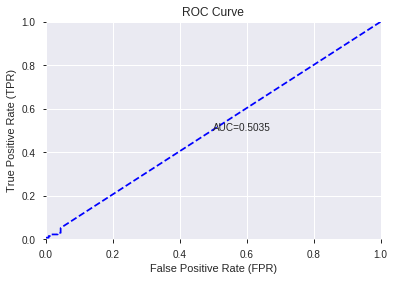

This function is available for GLM models only


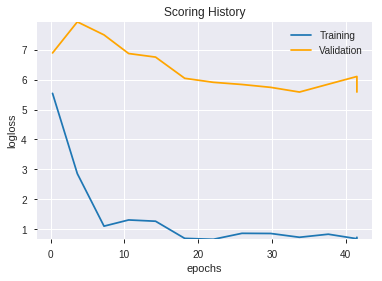

--2019-09-06 01:05:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.17.168
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.17.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  15.4MB/s    in 24s     

2019-09-06 01:05:32 (14.6 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_003136_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_003136_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_010543_model_7  0.503498  18.468693              0.500000  0.735043  0.540288
1  DeepLearning_grid_1_AutoML_20190906_010543_model_4  0.503432  18.463681              0.500000  0.737552  0.543982
2  DeepLearning_grid_1_AutoML_20190906_010543_model_2  0.503365  18.388964              0.500000  0.736981  0.543142
3  DeepLearning_grid_1_AutoML_20190906_010543_model_1  0.501599  15.452064              0.491071  0.670779  0.449944
4  DeepLearning_grid_1_AutoML_20190906_010543_model_9  0.501466  14.913883              0.494803  0.670259  0.449248
5  DeepLearning_grid_1_AutoML_20190906_010543_model_3  0.501333  15.463260              0.500000  0.673990  0.454263
6  DeepLearning_grid_1_AutoML_20190906_010543_model_6  0.498601  18.288992              0.500000  0.735230  0.540563
7  DeepLearning_grid_1_AutoML_20190906_010543_model_8  0.498601  18.219402              0.500000  0.735037  0.540279
8               DeepLearning_1_AutoML_20190906_010543  0.497068  18.512195              0.500000  0.735542  0.541022
9  DeepLearning_grid_1_AutoML_20190906_010543_model_5  0.477512  14.656995              0.489606  0.667401  0.445424

variable  relative_importance  scaled_importance  percentage
0     CDLSTALLEDPATTERN             1.000000           1.000000    0.021161
1          CDLTHRUSTING             0.994836           0.994836    0.021052
2                   day             0.983556           0.983556    0.020813
3        is_month_start             0.978318           0.978318    0.020702
4             CDLTAKURI             0.972133           0.972133    0.020571
5             CORREL_30             0.970703           0.970703    0.020541
6       CDLUNIQUE3RIVER             0.969312           0.969312    0.020512
7                  COSH             0.969164           0.969164    0.020508
8        CDLEVENINGSTAR             0.968681           0.968681    0.020498
9         CDLHANGINGMAN             0.963847           0.963847    0.020396
10      CDLSHOOTINGSTAR             0.963275           0.963275    0.020384
11       is_quarter_end             0.963097           0.963097    0.020380
12         CDLTASUKIGAP             0.961060           0.961060    0.020337
13      CDLLADDERBOTTOM             0.960275           0.960275    0.020320
14                  EXP             0.958452           0.958452    0.020282
15            CDLHAMMER             0.958175           0.958175    0.020276
16     is_quarter_start             0.956650           0.956650    0.020244
17            CORREL_14             0.955613           0.955613    0.020222
18         is_month_end             0.955360           0.955360    0.020216
19       STOCHRSI_fastk             0.955320           0.955320    0.020216
20            CDLINNECK             0.950939           0.950939    0.020123
21    CDL3WHITESOLDIERS             0.950416           0.950416    0.020112
22   CDLEVENINGDOJISTAR             0.949113           0.949113    0.020084
23          CDLPIERCING             0.949035           0.949035    0.020083
24        CDLHIKKAKEMOD             0.948458           0.948458    0.020070
25     CDLSTICKSANDWICH             0.946919           0.946919    0.020038
26         HT_TRENDMODE             0.946627           0.946627    0.020032
27    CDLGRAVESTONEDOJI             0.946221           0.946221    0.020023
28            CDL2CROWS             0.944920           0.944920    0.019995
29      CDLADVANCEBLOCK             0.943104           0.943104    0.019957
30     CDLDRAGONFLYDOJI             0.941638           0.941638    0.019926
31            CORREL_24             0.940204           0.940204    0.019896
32       CDLMORNINGSTAR             0.938610           0.938610    0.019862
33     CDLCOUNTERATTACK             0.932208           0.932208    0.019726
34       CDLRICKSHAWMAN             0.931632           0.931632    0.019714
35    CDLDARKCLOUDCOVER             0.931471           0.931471    0.019711
36      CDLHOMINGPIGEON             0.929049           0.929049    0.019660
37                  SIN             0.928239           0.928239    0.019642
38    CDLINVERTEDHAMMER             0.926514           0.926514    0.019606
39       CDLMATCHINGLOW             0.926329           0.926329    0.019602
40   CDLIDENTICAL3CROWS             0.923971           0.923971    0.019552
41         weekday_name             0.923349           0.923349    0.019539
42                 SINH             0.918386           0.918386    0.019434
43            CDLONNECK             0.916146           0.916146    0.019387
44                MFI_8             0.915364           0.915364    0.019370
45            CORREL_20             0.908208           0.908208    0.019219
46  CDLXSIDEGAP3METHODS             0.905049           0.905049    0.019152
47   CDLMORNINGDOJISTAR             0.899721           0.899721    0.019039
48                  COS             0.895943           0.895943    0.018959
49                  BOP             0.891153           0.891153    0.018858

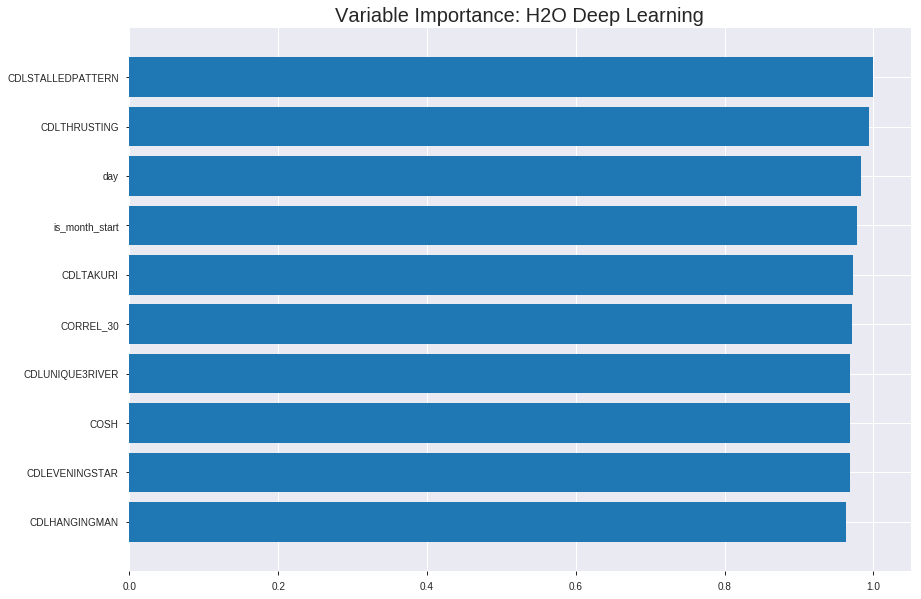

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_010543_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2530064834537678
RMSE: 0.5029974984567694
LogLoss: 0.7034517458291679
Mean Per-Class Error: 0.4459126380865511
AUC: 0.5693219823654606
pr_auc: 0.591798396598046
Gini: 0.13864396473092122
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23434376195198875: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      20   805   0.9758   (805.0/825.0)
1      6    891   0.0067   (6.0/897.0)
Total  26   1696  0.471    (811.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.234344     0.687235  380
max f2                       0.147003     0.845443  392
max f0point5                 0.413955     0.587577  314
max accuracy                 0.446807     0.553426  290
max precision                0.919211     0.933333  10
max recall                   0.112649     1         396
max specificity              0.955207     0.998788  0
max absolute_mcc             0.659785     0.112496  125
max min_per_class_accuracy   0.548759     0.541806  212
max mean_per_class_accuracy  0.576477     0.554087  190

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 55.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.916871           1.70643   1.70643            0.888889         0.932897  0.888889                    0.932897            0.0178372       0.0178372                  70.6429   70.6429
    2        0.0203252                   0.90347            1.35511   1.53579            0.705882         0.90888   0.8                         0.921232            0.0133779       0.0312152                  35.5105   53.5786
    3        0.0301974                   0.88868            1.12925   1.40288            0.588235         0.894761  0.730769                    0.912578            0.0111483       0.0423634                  12.9254   40.2881
    4        0.0400697                   0.858569           1.46803   1.41893            0.764706         0.875633  0.73913                     0.903476            0.0144928       0.0568562                  46.8031   41.8933
    5        0.0505226                   0.834215           0.959866  1.32395            0.5              0.847976  0.689655                    0.891993            0.0100334       0.0668896                  -4.01338  32.3953
    6        0.100465                    0.74062            1.13845   1.23174            0.593023         0.78293   0.641618                    0.837777            0.0568562       0.123746                   13.8446   23.1736
    7        0.150407                    0.696007           1.27238   1.24523            0.662791         0.7177    0.648649                    0.797906            0.0635452       0.187291                   27.2381   24.5232
    8        0.200348                    0.666033           1.00451   1.18523            0.523256         0.680431  0.617391                    0.768622            0.0501672       0.237458                   0.451116  18.5226
    9        0.300232                    0.619571           1.02683   1.13253            0.534884         0.640321  0.589942                    0.725938            0.102564        0.340022                   2.68336   13.2531
    10       0.400116                    0.586928           1.07148   1.11729            0.55814          0.602103  0.582003                    0.695024            0.107023        0.447046                   7.14786   11.729
    11       0.5                         0.548725           0.937544  1.08138            0.488372         0.566882  0.563298                    0.669425            0.0936455       0.540691                   -6.24562  8.13824
    12       0.599884                    0.502578           0.971027  1.06301            0.505814         0.526329  0.553727                    0.645599            0.09699         0.637681                   -2.89725  6.30077
    13       0.699768                    0.466951           0.982189  1.05147            0.511628         0.484951  0.547718                    0.622668            0.0981048       0.735786                   -1.78113  5.14717
    14       0.799652                    0.429704           0.982189  1.04282            0.511628         0.447611  0.54321                     0.600802            0.0981048       0.833891                   -1.78113  4.28176
    15       0.899535                    0.385853           0.859415  1.02245            0.447674         0.408963  0.532602                    0.5795              0.0858417       0.919732                   -14.0585  2.24527
    16       1                           0.00576814         0.798964  1                  0.416185         0.315112  0.520906                    0.552939          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3597839879730953
RMSE: 0.5998199629664682
LogLoss: 5.680939876103313
Mean Per-Class Error: 0.46176176176176176
AUC: 0.5148898898898899
pr_auc: 0.5537631490160438
Gini: 0.029779779779779858
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.1338987230110684e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.1339e-48   0.708661   358
max f2                       4.1339e-48   0.858779   358
max f0point5                 4.1339e-48   0.603217   358
max accuracy                 3.58389e-05  0.556911   341
max precision                0.979057     1          0
max recall                   4.1339e-48   1          358
max specificity              0.979057     1          0
max absolute_mcc             3.58389e-05  0.0826661  341
max min_per_class_accuracy   0.441466     0.509009   246
max mean_per_class_accuracy  3.58389e-05  0.538238   341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 36.27 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.914727           1.09333   1.09333            0.6              0.934825     0.6                         0.934825            0.0111111       0.0111111                  9.33333   9.33333
    2        0.0203252                   0.878016           0.728889  0.911111           0.4              0.896051     0.5                         0.915438            0.00740741      0.0185185                  -27.1111  -8.88889
    3        0.0304878                   0.857              0.364444  0.728889           0.2              0.869829     0.4                         0.900235            0.0037037       0.0222222                  -63.5556  -27.1111
    4        0.0406504                   0.808534           1.45778   0.911111           0.8              0.83169      0.5                         0.883099            0.0148148       0.037037                   45.7778   -8.88889
    5        0.050813                    0.791766           1.09333   0.947556           0.6              0.804604     0.52                        0.8674              0.0111111       0.0481481                  9.33333   -5.24444
    6        0.101626                    0.7078             1.09333   1.02044            0.6              0.743497     0.56                        0.805448            0.0555556       0.103704                   9.33333   2.04444
    7        0.150407                    0.667703           0.987037  1.00961            0.541667         0.687886     0.554054                    0.76732             0.0481481       0.151852                   -1.2963   0.960961
    8        0.20122                     0.630322           0.947556  0.993939           0.52             0.650041     0.545455                    0.737704            0.0481481       0.2                        -5.24444  -0.606061
    9        0.300813                    0.570364           0.966893  0.984985           0.530612         0.599447     0.540541                    0.69193             0.0962963       0.296296                   -3.31066  -1.5015
    10       0.400407                    0.497495           0.929705  0.971235           0.510204         0.532584     0.532995                    0.652296            0.0925926       0.388889                   -7.02948  -2.87648
    11       0.5                         0.441787           1.19002   1.01481            0.653061         0.470662     0.556911                    0.616117            0.118519        0.507407                   19.0023   1.48148
    12       0.599593                    0.351703           1.11565   1.03156            0.612245         0.402918     0.566102                    0.580704            0.111111        0.618519                   11.5646   3.15631
    13       0.699187                    3.02781e-06        1.15283   1.04884            0.632653         0.145942     0.575581                    0.518776            0.114815        0.733333                   15.2834   4.88372
    14       1                           0                  0.886486  1                  0.486486         6.29289e-11  0.54878                     0.362721            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:09:54  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:09:58  5.595 sec         270 obs/sec       0.675958  1             1164       0.502997         0.703452            -0.0137983     0.569322        0.591798           1.70643          0.470964                         0.59982            5.68094               -0.452965        0.51489           0.553763             1.09333            0.45122
    2019-09-06 01:10:12  19.173 sec        566 obs/sec       5.45587   8             9395       0.527021         0.762442            -0.112951      0.652378        0.671572           1.91973          0.417538                         0.615852           5.88692               -0.531673        0.530864          0.562287             1.09333            0.45122
    2019-09-06 01:10:26  33.396 sec        635 obs/sec       10.9071   16            18782      0.47629          0.640945            0.0910022      0.67645         0.692897           1.91973          0.413473                         0.618023           6.16352               -0.542494        0.52319           0.563975             1.09333            0.45122
    2019-09-06 01:10:40  47.411 sec        667 obs/sec       16.4158   24            28268      0.529072         0.800569            -0.12163       0.741628        0.726952           1.91973          0.348432                         0.634221           6.22686               -0.624405        0.532382          0.57838              1.45778            0.45122
    2019-09-06 01:10:54  1 min  1.067 sec  688 obs/sec       21.8966   32            37706      0.434993         0.544931            0.241798       0.77429         0.782111           1.91973          0.328688                         0.619749           6.15221               -0.551117        0.537538          0.582259             1.09333            0.45122
    2019-09-06 01:11:07  1 min 13.842 sec  692 obs/sec       26.705    39            45986      0.427119         0.531507            0.268999       0.788751        0.786002           1.91973          0.311266                         0.625269           6.56964               -0.578875        0.543569          0.583016             1.09333            0.45122
    2019-09-06 01:11:08  1 min 15.066 sec  692 obs/sec       26.705    39            45986      0.502997         0.703452            -0.0137983     0.569322        0.591798           1.70643          0.470964                         0.59982            5.68094               -0.452965        0.51489           0.553763             1.09333            0.45122

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLSTALLEDPATTERN    1.0                    1.0                  0.02116099355242527
CDLTHRUSTING         0.9948364496231079     0.9948364496231079   0.021051727696192235
day                  0.9835560917854309     0.9835560917854309   0.020813024116720102
is_month_start       0.9783176183700562     0.9783176183700562   0.020702172814552805
CDLTAKURI            0.9721330404281616     0.9721330404281616   0.020571301000599902
---                  ---                    ---                  ---
CORREL_20            0.9082083106040955     0.9082083106040955   0.019218590204952313
CDLXSIDEGAP3METHODS  0.9050491452217102     0.9050491452217102   0.01915173912666461
CDLMORNINGDOJISTAR   0.8997213244438171     0.8997213244438171   0.019038997145535138
COS                  0.8959430456161499     0.8959430456161499   0.01895904501162361
BOP                  0.8911530375480652     0.8911530375480652   0.018857683681778804


See the whole table with table.as_data_frame()


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5034981343283582)

('logloss', 18.468693116918203)

('mean_per_class_error', 0.49620202558635396)

('rmse', 0.735042643051505)

('mse', 0.5402876871041422)

deeplearning prediction progress: |███████████████████████████████████████| 100%


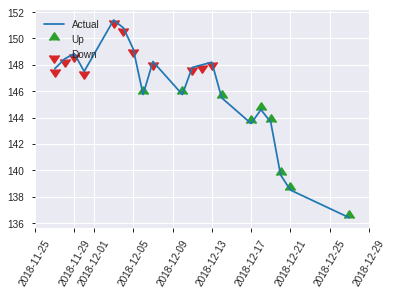


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5402876871041422
RMSE: 0.735042643051505
LogLoss: 18.468693116918203
Mean Per-Class Error: 0.49620202558635396
AUC: 0.5034981343283582
pr_auc: 0.5581198510667021
Gini: 0.006996268656716431
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.6382829169001987e-91: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       4.63828e-91  0.705263   12
max f2                       4.63828e-91  0.856777   12
max f0point5                 4.63828e-91  0.599284   12
max accuracy                 4.63828e-91  0.544715   12
max precision                0.623603     1          0
max recall                   4.63828e-91  1          12
max specificity              0.623603     1          0
max absolute_mcc             0.623603     0.0584082  0
max min_per_class_accuracy   5.52637e-44  0.0522388  11
max mean_per_class_accuracy  5.52637e-44  0.503798   11

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.414316           1.22388   1.22388            0.666667         0.529171     0.666667                    0.529171            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   3.17617e-08        0.91791   1.10149            0.5              0.19815      0.6                         0.396762            0.00746269      0.0223881                  -8.20896   10.1493
    3        0.0325203                   1.25994e-18        0.61194   0.91791            0.333333         8.10488e-09  0.5                         0.247976            0.00746269      0.0298507                  -38.806    -8.20896
    4        0.0406504                   5.26785e-39        0.91791   0.91791            0.5              2.45234e-35  0.5                         0.198381            0.00746269      0.0373134                  -8.20896   -8.20896
    5        0.0528455                   5.45153e-89        1.83582   1.12974            1                3.87467e-44  0.615385                    0.152601            0.0223881       0.0597015                  83.5821    12.9736
    6        1                           0                  0.992762  1                  0.540773         2.30786e-91  0.544715                    0.00806427          0.940299        1                          -0.723849  0

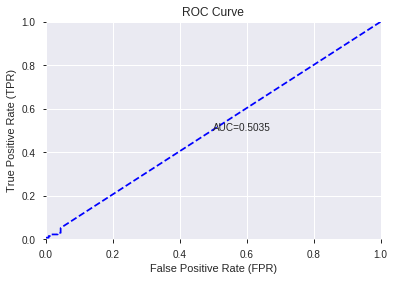

This function is available for GLM models only


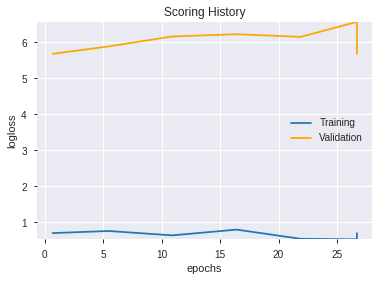

--2019-09-06 01:13:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.184.11
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.184.11|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_010543_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_010543_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTALLEDPATTERN',
 'CDLTHRUSTING',
 'day',
 'is_month_start',
 'CDLTAKURI',
 'CORREL_30',
 'CDLUNIQUE3RIVER',
 'COSH',
 'CDLEVENINGSTAR',
 'CDLHANGINGMAN',
 'CDLSHOOTINGSTAR',
 'is_quarter_end',
 'CDLTASUKIGAP',
 'CDLLADDERBOTTOM',
 'EXP',
 'CDLHAMMER',
 'is_quarter_start',
 'CORREL_14',
 'is_month_end',
 'STOCHRSI_fastk',
 'CDLINNECK',
 'CDL3WHITESOLDIERS',
 'CDLEVENINGDOJISTAR',
 'CDLPIERCING',
 'CDLHIKKAKEMOD',
 'CDLSTICKSANDWICH',
 'HT_TRENDMODE',
 'CDLGRAVESTONEDOJI',
 'CDL2CROWS',
 'CDLADVANCEBLOCK',
 'CDLDRAGONFLYDOJI',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'CDLCOUNTERATTACK',
 'CDLRICKSHAWMAN',
 'CDLDARKCLOUDCOVER',
 'CDLHOMINGPIGEON',
 'SIN',
 'CDLINVERTEDHAMMER',
 'CDLMATCHINGLOW',
 'CDLIDENTICAL3CROWS',
 'weekday_name',
 'SINH',
 'CDLONNECK',
 'MFI_8',
 'CORREL_20',
 'CDLXSIDEGAP3METHODS',
 'CDLMORNINGDOJISTAR',
 'COS',
 'BOP']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_011337_model_1  0.505597  18.098708                   0.5  0.734683  0.539759

variable  relative_importance  scaled_importance  percentage
0                   day             0.009196           1.000000    0.048902
1     CDLINVERTEDHAMMER             0.009110           0.990674    0.048446
2                   BOP             0.008763           0.952969    0.046602
3      CDLSTICKSANDWICH             0.007834           0.851971    0.041663
4       CDLADVANCEBLOCK             0.007608           0.827338    0.040459
5       CDLUNIQUE3RIVER             0.006911           0.751569    0.036753
6    CDLMORNINGDOJISTAR             0.006288           0.683795    0.033439
7                   COS             0.006193           0.673425    0.032932
8        CDLMATCHINGLOW             0.005850           0.636132    0.031108
9     CDLSTALLEDPATTERN             0.005736           0.623829    0.030507
10       CDLEVENINGSTAR             0.005480           0.595946    0.029143
11         HT_TRENDMODE             0.005474           0.595302    0.029112
12     CDLCOUNTERATTACK             0.005341           0.580786    0.028402
13      CDLLADDERBOTTOM             0.005070           0.551340    0.026962
14       is_quarter_end             0.004802           0.522240    0.025539
15            CDLHAMMER             0.004540           0.493725    0.024144
16                 COSH             0.004456           0.484583    0.023697
17                  EXP             0.004449           0.483870    0.023662
18                 SINH             0.004443           0.483208    0.023630
19            CORREL_14             0.004147           0.450966    0.022053
20                  SIN             0.003882           0.422157    0.020644
21         CDLTHRUSTING             0.003751           0.407953    0.019950
22            CDL2CROWS             0.003677           0.399841    0.019553
23   CDLEVENINGDOJISTAR             0.003612           0.392815    0.019209
24    CDL3WHITESOLDIERS             0.003481           0.378604    0.018515
25   CDLIDENTICAL3CROWS             0.003451           0.375277    0.018352
26         CDLTASUKIGAP             0.003399           0.369617    0.018075
27          CDLPIERCING             0.003288           0.357610    0.017488
28            CORREL_30             0.003209           0.348970    0.017065
29     is_quarter_start             0.003168           0.344535    0.016848
30    CDLGRAVESTONEDOJI             0.003132           0.340617    0.016657
31    CDLDARKCLOUDCOVER             0.002998           0.325990    0.015942
32            CORREL_20             0.002770           0.301249    0.014732
33       CDLMORNINGSTAR             0.002311           0.251368    0.012292
34        CDLHIKKAKEMOD             0.002172           0.236222    0.011552
35            CORREL_24             0.002158           0.234653    0.011475
36            CDLINNECK             0.002027           0.220386    0.010777
37                MFI_8             0.001842           0.200314    0.009796
38        CDLHANGINGMAN             0.001673           0.181978    0.008899
39            CDLONNECK             0.001669           0.181463    0.008874
40       STOCHRSI_fastk             0.001540           0.167451    0.008189
41      CDLHOMINGPIGEON             0.001465           0.159305    0.007790
42         is_month_end             0.001073           0.116694    0.005707
43            CDLTAKURI             0.001072           0.116594    0.005702
44       is_month_start             0.001023           0.111252    0.005440
45       CDLRICKSHAWMAN             0.000900           0.097848    0.004785
46      CDLSHOOTINGSTAR             0.000753           0.081901    0.004005
47         weekday_name             0.000414           0.044984    0.002200
48     CDLDRAGONFLYDOJI             0.000331           0.036027    0.001762
49  CDLXSIDEGAP3METHODS             0.000107           0.011678    0.000571

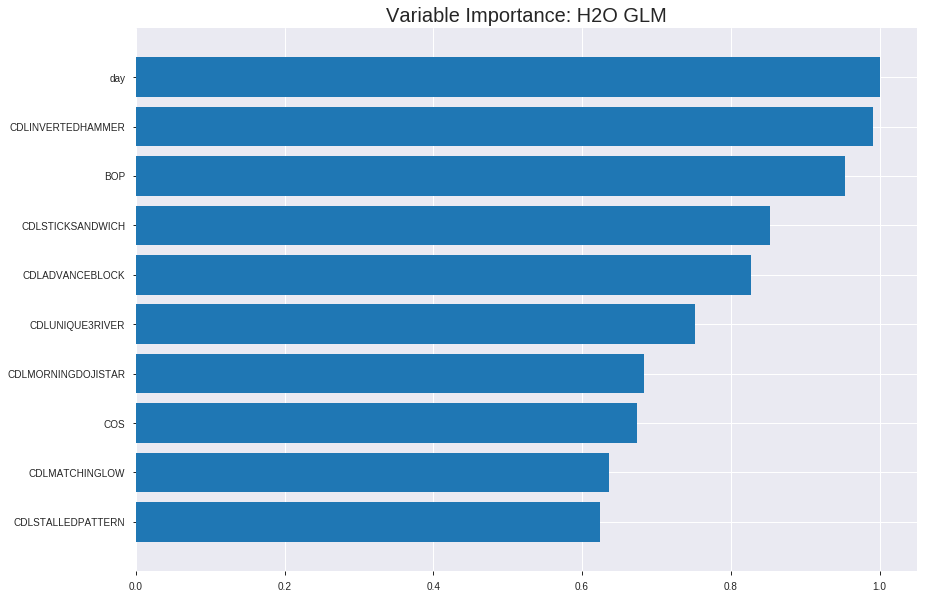

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_011337_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24800201060838237
RMSE: 0.4979980026148522
LogLoss: 0.689137593797036
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2384.1875591118605
Residual deviance: 2373.3898730369924
AIC: 2475.3898730369924
AUC: 0.5931982027634202
pr_auc: 0.6131926610694283
Gini: 0.18639640552684034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5082126319880191: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      35   790   0.9576   (790.0/825.0)
1      8    889   0.0089   (8.0/897.0)
Total  43   1679  0.4634   (798.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508213     0.690217  367
max f2                       0.505346     0.846576  377
max f0point5                 0.516786     0.600194  280
max accuracy                 0.517875     0.575494  261
max precision                0.595501     1         0
max recall                   0.501003     1         390
max specificity              0.595501     1         0
max absolute_mcc             0.516786     0.148056  280
max min_per_class_accuracy   0.52055      0.559643  213
max mean_per_class_accuracy  0.518885     0.569693  242

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.548266           1.91973   1.91973            1                0.563217  1                           0.563217            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.541066           1.46803   1.70033            0.764706         0.544733  0.885714                    0.554239            0.0144928       0.0345596                  46.8031   70.0334
    3        0.0301974                   0.536252           1.35511   1.58747            0.705882         0.538701  0.826923                    0.549159            0.0133779       0.0479376                  35.5105   58.7471
    4        0.0400697                   0.533303           1.24218   1.5024             0.647059         0.535112  0.782609                    0.545698            0.0122631       0.0602007                  24.218    50.2399
    5        0.0505226                   0.531215           1.27982   1.45635            0.666667         0.53221   0.758621                    0.542908            0.0133779       0.0735786                  27.9822   45.6349
    6        0.100465                    0.527995           1.07148   1.26503            0.55814          0.529261  0.65896                     0.536124            0.0535117       0.12709                    7.14786   26.5026
    7        0.150407                    0.526422           1.31703   1.28229            0.686047         0.527097  0.667954                    0.533126            0.0657748       0.192865                   31.7026   28.2292
    8        0.200348                    0.525164           1.02683   1.21861            0.534884         0.525837  0.634783                    0.531309            0.0512821       0.244147                   2.68336   21.8613
    9        0.300232                    0.523355           0.971027  1.13624            0.505814         0.524196  0.591876                    0.528943            0.09699         0.341137                   -2.89725  13.6244
    10       0.400116                    0.521842           1.12728   1.13401            0.587209         0.522592  0.590711                    0.527357            0.112598        0.453735                   12.7285   13.4007
    11       0.5                         0.520548           1.03799   1.11483            0.540698         0.521181  0.58072                     0.526124            0.103679        0.557414                   3.79949   11.4827
    12       0.599884                    0.519213           0.971027  1.09088            0.505814         0.519895  0.568248                    0.525086            0.09699         0.654404                   -2.89725  9.08838
    13       0.699768                    0.517769           1.08264   1.08971            0.563953         0.518516  0.567635                    0.524149            0.108138        0.762542                   8.26398   8.9707
    14       0.799652                    0.516115           0.837093  1.05815            0.436047         0.517003  0.551198                    0.523256            0.083612        0.846154                   -16.2907  5.81532
    15       0.899535                    0.513646           0.90406   1.04104            0.47093          0.515039  0.542285                    0.522344            0.090301        0.936455                   -9.594    4.10428
    16       1                           0.383827           0.632513  1                  0.32948          0.508032  0.520906                    0.520906          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3230073897381102
RMSE: 0.5683373907619577
LogLoss: 5.215163634766801
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 678.9014289835272
Residual deviance: 80300.26866446836
AIC: 80402.26866446836
AUC: 0.5221137804471138
pr_auc: 0.5537774498705748
Gini: 0.044227560894227524
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.562632314415618e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.56263e-50  0.708661   368
max f2                       7.56263e-50  0.858779   368
max f0point5                 7.56263e-50  0.603217   368
max accuracy                 0.230078     0.556911   341
max precision                0.62627      1          0
max recall                   7.56263e-50  1          368
max specificity              0.62627      1          0
max absolute_mcc             0.230078     0.0826661  341
max min_per_class_accuracy   0.516806     0.503704   245
max mean_per_class_accuracy  0.230078     0.538238   341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 35.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.553724           1.09333   1.09333            0.6              0.571986    0.6                         0.571986            0.0111111       0.0111111                  9.33333   9.33333
    2        0.0203252                   0.550986           0.728889  0.911111           0.4              0.552346    0.5                         0.562166            0.00740741      0.0185185                  -27.1111  -8.88889
    3        0.0304878                   0.549073           1.09333   0.971852           0.6              0.550065    0.533333                    0.558132            0.0111111       0.0296296                  9.33333   -2.81481
    4        0.0406504                   0.545379           0.364444  0.82               0.2              0.547627    0.45                        0.555506            0.0037037       0.0333333                  -63.5556  -18
    5        0.050813                    0.54189            0.364444  0.728889           0.2              0.544328    0.4                         0.55327             0.0037037       0.037037                   -63.5556  -27.1111
    6        0.101626                    0.530737           1.23911   0.984              0.68             0.535551    0.54                        0.544411            0.062963        0.1                        23.9111   -1.6
    7        0.150407                    0.526382           0.987037  0.984985           0.541667         0.528137    0.540541                    0.539133            0.0481481       0.148148                   -1.2963   -1.5015
    8        0.20122                     0.524752           1.02044   0.993939           0.56             0.525605    0.545455                    0.535717            0.0518519       0.2                        2.04444   -0.606061
    9        0.300813                    0.521802           1.15283   1.04655            0.632653         0.523087    0.574324                    0.531535            0.114815        0.314815                   15.2834   4.65465
    10       0.400407                    0.519663           0.892517  1.00823            0.489796         0.520802    0.553299                    0.528865            0.0888889       0.403704                   -10.7483  0.823463
    11       0.5                         0.516802           1.00408   1.00741            0.55102          0.518287    0.552846                    0.526758            0.1             0.503704                   0.408163  0.740741
    12       0.599593                    0.511354           1.15283   1.03156            0.632653         0.514794    0.566102                    0.524771            0.114815        0.618519                   15.2834   3.15631
    13       0.699187                    0.107859           1.15283   1.04884            0.632653         0.439828    0.575581                    0.512672            0.114815        0.733333                   15.2834   4.88372
    14       1                           0                  0.886486  1                  0.486486         0.00242857  0.54878                     0.359184            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:13:38  0.000 sec   2            3         51            1.37828           163.212
    2019-09-06 01:13:38  0.028 sec   4            1.9       51            1.37526           168.753
    2019-09-06 01:13:38  0.052 sec   6            1.2       51            1.37127           173.094
    2019-09-06 01:13:38  0.081 sec   8            0.73      51            1.36637           175.875
    2019-09-06 01:13:38  0.096 sec   10           0.45      51            1.36089           178.92

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5055970149253731)

('logloss', 18.098707523873358)

('mean_per_class_error', 0.4924706823027718)

('rmse', 0.7346829095232575)

('mse', 0.539758977545559)

glm prediction progress: |████████████████████████████████████████████████| 100%


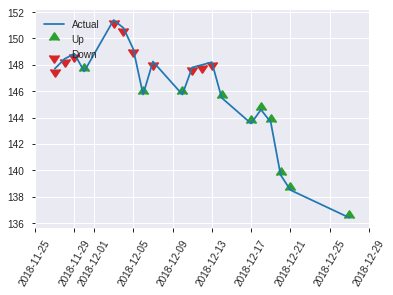


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.539758977545559
RMSE: 0.7346829095232575
LogLoss: 18.098707523873358
Null degrees of freedom: 245
Residual degrees of freedom: 195
Null deviance: 339.6180594432119
Residual deviance: 167071.34358060602
AIC: 167173.34358060602
AUC: 0.5055970149253731
pr_auc: 0.5593722765839673
Gini: 0.011194029850746245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.0941575389765479e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.09416e-50  0.705263   17
max f2                       2.09416e-50  0.856777   17
max f0point5                 2.09416e-50  0.599284   17
max accuracy                 2.09416e-50  0.544715   17
max precision                0.525757     1          0
max recall                   2.09416e-50  1          17
max specificity              0.525757     1          0
max absolute_mcc             0.525757     0.0584082  0
max min_per_class_accuracy   1.87214e-32  0.0746269  16
max mean_per_class_accuracy  4.21949e-18  0.507529   12

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.511723           0.61194   0.61194            0.333333         0.519395      0.333333                    0.519395            0.00746269      0.00746269                 -38.806   -38.806
    2        0.0203252                   0.10012            1.83582   1.10149            1                0.31491       0.6                         0.437601            0.0149254       0.0223881                  83.5821   10.1493
    3        0.0325203                   0.000671722        0.61194   0.91791            0.333333         0.0339101     0.5                         0.286217            0.00746269      0.0298507                  -38.806   -8.20896
    4        0.0406504                   2.31509e-08        0.91791   0.91791            0.5              2.56149e-07   0.5                         0.228974            0.00746269      0.0373134                  -8.20896  -8.20896
    5        0.0528455                   4.17535e-18        1.83582   1.12974            1                4.20164e-09   0.615385                    0.176134            0.0223881       0.0597015                  83.5821   12.9736
    6        0.101626                    2.80953e-101       1.22388   1.17493            0.666667         3.3742e-19    0.64                        0.0915895           0.0597015       0.119403                   22.3881   17.4925
    7        1                           0                  0.980212  1                  0.533937         1.91622e-108  0.544715                    0.00930787          0.880597        1                          -1.97879  0

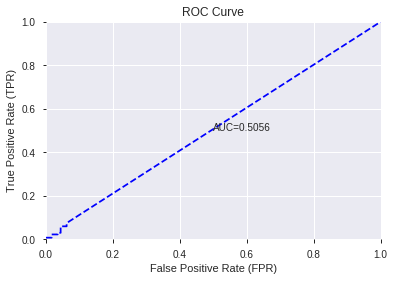

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


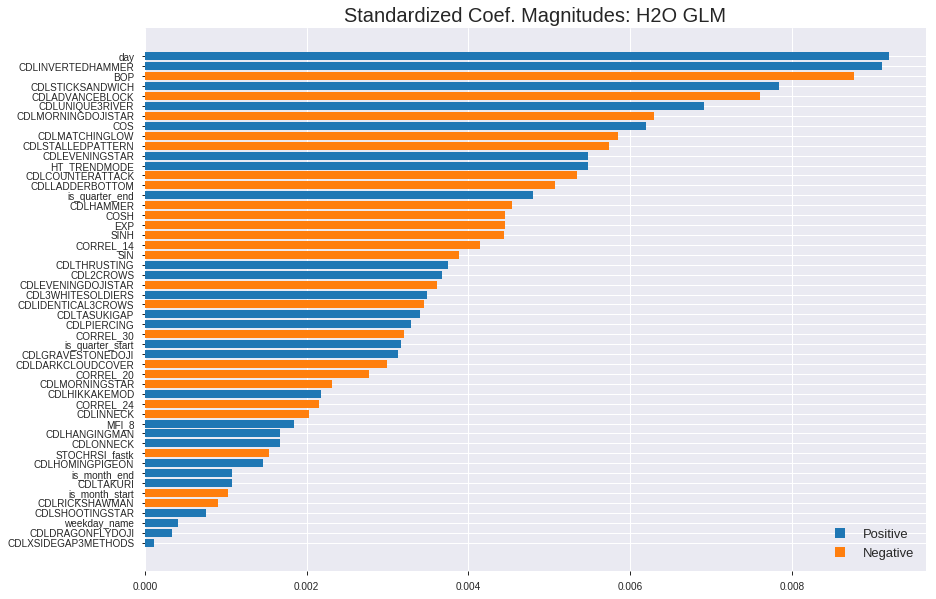

'log_likelihood'
--2019-09-06 01:13:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_011337_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_011337_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['day',
 'CDLINVERTEDHAMMER',
 'BOP',
 'CDLSTICKSANDWICH',
 'CDLADVANCEBLOCK',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'COS',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'HT_TRENDMODE',
 'CDLCOUNTERATTACK',
 'CDLLADDERBOTTOM',
 'is_quarter_end',
 'CDLHAMMER',
 'COSH',
 'EXP',
 'SINH',
 'CORREL_14',
 'SIN',
 'CDLTHRUSTING',
 'CDL2CROWS',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLTASUKIGAP',
 'CDLPIERCING',
 'CORREL_30',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CORREL_20',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CORREL_24',
 'CDLINNECK',
 'MFI_8',
 'CDLHANGINGMAN',
 'CDLONNECK',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'CDLTAKURI',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS']

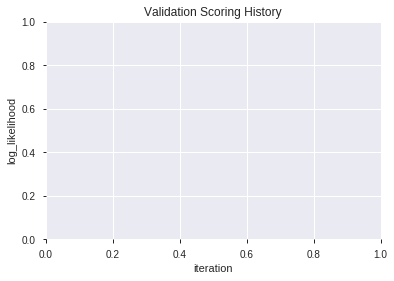

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_011356_model_1  0.563899  0.708646              0.495536  0.507345  0.257399
1  XGBoost_grid_1_AutoML_20190906_011356_model_7  0.546908  0.710206              0.500000  0.507863  0.257925
2               XGBoost_1_AutoML_20190906_011356  0.542444  0.699355              0.500000  0.502897  0.252905
3  XGBoost_grid_1_AutoML_20190906_011356_model_2  0.542377  0.695455              0.500000  0.501077  0.251078
4  XGBoost_grid_1_AutoML_20190906_011356_model_5  0.541511  0.746111              0.491071  0.523329  0.273873
5  XGBoost_grid_1_AutoML_20190906_011356_model_6  0.539845  0.719834              0.500000  0.512572  0.262731
6               XGBoost_3_AutoML_20190906_011356  0.525586  0.709887              0.474747  0.507997  0.258061
7  XGBoost_grid_1_AutoML_20190906_011356_model_4  0.509262  0.703164              0.495536  0.504836  0.254860
8               XGBoost_2_AutoML_20190906_011356  0.509128  0.704139              0.485141  0.505375  0.255404
9  XGBoost_grid_1_AutoML_20190906_011356_model_3  0.500200  0.726123              0.495536  0.515425  0.265663

variable  relative_importance  scaled_importance  percentage
0                 BOP           414.090607           1.000000    0.146272
1           CORREL_14           347.644287           0.839537    0.122800
2                 COS           266.280243           0.643048    0.094060
3               MFI_8           240.397018           0.580542    0.084917
4           CORREL_24           230.960205           0.557753    0.081583
5                 day           222.108932           0.536378    0.078457
6                COSH           207.868790           0.501989    0.073427
7                 SIN           202.868866           0.489914    0.071661
8           CORREL_20           193.831985           0.468091    0.068468
9      STOCHRSI_fastk           143.613464           0.346817    0.050729
10          CORREL_30           131.821732           0.318340    0.046564
11                EXP            58.930779           0.142314    0.020816
12  CDLINVERTEDHAMMER            51.007576           0.123180    0.018018
13       HT_TRENDMODE            42.167530           0.101832    0.014895
14       weekday_name            36.440834           0.088002    0.012872
15     CDLMATCHINGLOW            20.926826           0.050537    0.007392
16               SINH            17.040874           0.041153    0.006019
17          CDLHAMMER             2.970206           0.007173    0.001049

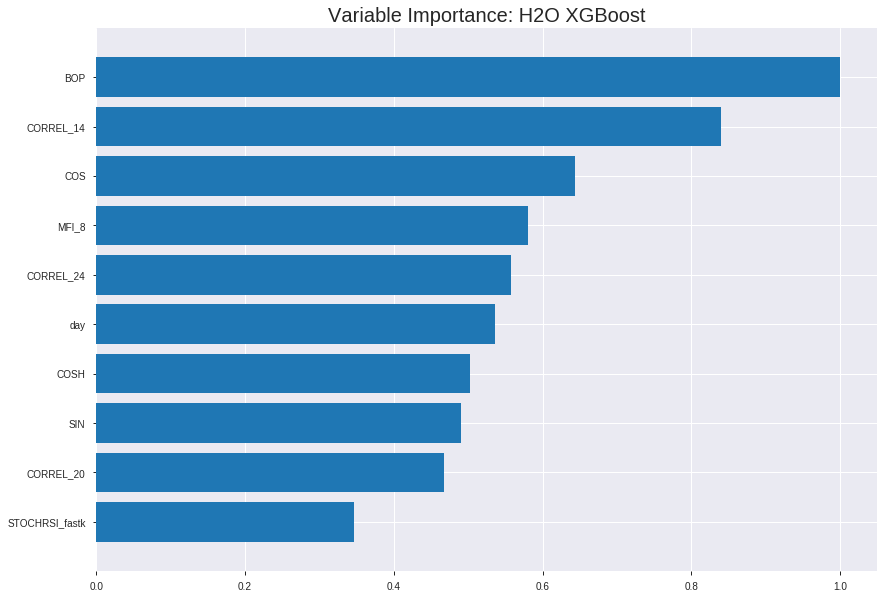

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_011356_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21047804909703668
RMSE: 0.4587788673174002
LogLoss: 0.6122812149576731
Mean Per-Class Error: 0.24332623897841288
AUC: 0.8343697848045675
pr_auc: 0.8419516120780777
Gini: 0.6687395696091349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5046523690223694: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      538  287   0.3479   (287.0/825.0)
1      148  749   0.165    (148.0/897.0)
Total  686  1036  0.2526   (435.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504652     0.774961  214
max f2                       0.460798     0.867718  272
max f0point5                 0.539161     0.785168  165
max accuracy                 0.514646     0.755517  200
max precision                0.735653     1         0
max recall                   0.285738     1         385
max specificity              0.735653     1         0
max absolute_mcc             0.53561      0.515492  170
max min_per_class_accuracy   0.520584     0.749164  191
max mean_per_class_accuracy  0.530564     0.756674  176

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.703574           1.91973    1.91973            1                0.716685  1                           0.716685            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.686946           1.91973    1.91973            1                0.69182   1                           0.704608            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.667203           1.91973    1.91973            1                0.675321  1                           0.695033            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.659666           1.91973    1.91973            1                0.662311  1                           0.686971            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.649975           1.70643    1.8756             0.888889         0.653847  0.977011                    0.680118            0.0178372       0.0947603                  70.6429   87.5601
    6        0.100465                    0.620119           1.76348    1.81986            0.918605         0.633226  0.947977                    0.656807            0.0880713       0.182832                   76.3475   81.9862
    7        0.150407                    0.597728           1.69651    1.7789             0.883721         0.608315  0.926641                    0.640706            0.0847269       0.267559                   69.6508   77.8903
    8        0.200348                    0.585869           1.56257    1.72498            0.813953         0.592417  0.898551                    0.628669            0.0780379       0.345596                   56.2573   72.4977
    9        0.300232                    0.562914           1.55141    1.66723            0.80814          0.573816  0.868472                    0.61042             0.154961        0.500557                   55.1412   66.7234
    10       0.400116                    0.543581           1.36167    1.59095            0.709302         0.552845  0.828737                    0.596047            0.136009        0.636566                   36.1671   59.0954
    11       0.5                         0.522501           1.06032    1.48495            0.552326         0.532005  0.773519                    0.583253            0.105909        0.742475                   6.03173   48.495
    12       0.599884                    0.504671           0.915221   1.39009            0.476744         0.513901  0.724105                    0.571706            0.0914158       0.833891                   -8.47787  39.0087
    13       0.699768                    0.482518           0.736642   1.29682            0.383721         0.493123  0.675519                    0.560489            0.0735786       0.907469                   -26.3358  29.6815
    14       0.799652                    0.456527           0.524578   1.20036            0.273256         0.470746  0.625272                    0.549279            0.0523969       0.959866                   -47.5422  20.0356
    15       0.899535                    0.414507           0.312515   1.10177            0.162791         0.436728  0.573919                    0.536782            0.0312152       0.991081                   -68.7485  10.177
    16       1                           0.20262            0.0887738  1                  0.0462428        0.362389  0.520906                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2634522130599882
RMSE: 0.5132759618957313
LogLoss: 0.7211153438531896
Mean Per-Class Error: 0.4868368368368369
AUC: 0.4784284284284284
pr_auc: 0.5178902829758539
Gini: -0.04314314314314316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27597102522850037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275971     0.708661  399
max f2                       0.275971     0.858779  399
max f0point5                 0.275971     0.603217  399
max accuracy                 0.275971     0.54878   399
max precision                0.704431     1         0
max recall                   0.275971     1         399
max specificity              0.704431     1         0
max absolute_mcc             0.313884     0.101663  389
max min_per_class_accuracy   0.480351     0.490991  197
max mean_per_class_accuracy  0.459585     0.513163  233

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.658863           0.364444  0.364444           0.2              0.675781  0.2                         0.675781            0.0037037       0.0037037                  -63.5556  -63.5556
    2        0.0203252                   0.646339           1.45778   0.911111           0.8              0.652613  0.5                         0.664197            0.0148148       0.0185185                  45.7778   -8.88889
    3        0.0304878                   0.632835           0.728889  0.85037            0.4              0.638793  0.466667                    0.655729            0.00740741      0.0259259                  -27.1111  -14.963
    4        0.0406504                   0.621672           0.364444  0.728889           0.2              0.626838  0.4                         0.648507            0.0037037       0.0296296                  -63.5556  -27.1111
    5        0.050813                    0.617452           0.364444  0.656              0.2              0.620236  0.36                        0.642852            0.0037037       0.0333333                  -63.5556  -34.4
    6        0.101626                    0.588703           1.16622   0.911111           0.64             0.59825   0.5                         0.620551            0.0592593       0.0925926                  16.6222   -8.88889
    7        0.150407                    0.568694           0.759259  0.861862           0.416667         0.576684  0.472973                    0.606324            0.037037        0.12963                    -24.0741  -13.8138
    8        0.20122                     0.555485           0.874667  0.865095           0.48             0.561577  0.474747                    0.595024            0.0444444       0.174074                   -12.5333  -13.4905
    9        0.300813                    0.528247           0.966893  0.898799           0.530612         0.541801  0.493243                    0.577403            0.0962963       0.27037                    -3.31066  -10.1201
    10       0.400407                    0.502643           1.11565   0.952735           0.612245         0.516642  0.522843                    0.56229             0.111111        0.381481                   11.5646   -4.72645
    11       0.5                         0.480039           1.11565   0.985185           0.612245         0.491936  0.54065                     0.548276            0.111111        0.492593                   11.5646   -1.48148
    12       0.599593                    0.458231           1.19002   1.01921            0.653061         0.46846   0.559322                    0.535019            0.118519        0.611111                   19.0023   1.9209
    13       0.699187                    0.428127           0.855329  0.995866           0.469388         0.443823  0.546512                    0.522029            0.0851852       0.696296                   -14.4671  -0.413437
    14       0.79878                     0.400453           1.04127   1.00153            0.571429         0.414745  0.549618                    0.508652            0.103704        0.8                        4.12698   0.152672
    15       0.898374                    0.364025           1.00408   1.00181            0.55102          0.384724  0.549774                    0.494914            0.1             0.9                        0.408163  0.180995
    16       1                           0.275971           0.984     1                  0.54             0.332421  0.54878                     0.4784 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:14:07  0.037 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.45122
    2019-09-06 01:14:07  0.109 sec   5                  0.494038         0.681273            0.685342        0.688591           1.70643          0.396632                         0.501504           0.696174              0.488096          0.528072             0.364444           0.45122
    2019-09-06 01:14:07  0.159 sec   10                 0.488408         0.670121            0.72934         0.732897           1.63177          0.355401                         0.502787           0.698803              0.482424          0.529387             0.364444           0.45122
    2019-09-06 01:14:07  0.204 sec   15                 0.48362          0.660655            0.749371        0.758244           1.81308          0.334495                         0.503426           0.700151              0.490249          0.537248             0.728889           0.45122
    2019-09-06 01:14:07  0.266 sec   20                 0.480108         0.653694            0.754803        0.762655           1.70643          0.332172                         0.505139           0.703737              0.490991          0.53393              0.728889           0.45122
    2019-09-06 01:14:07  0.329 sec   25                 0.475645         0.644937            0.778623        0.78617            1.91973          0.33101                          0.506542           0.706697              0.489706          0.531988             0.728889           0.45122
    2019-09-06 01:14:08  0.386 sec   30                 0.471554         0.63696             0.795269        0.801625           1.91973          0.304297                         0.508149           0.71007               0.483926          0.526709             0.728889           0.45122
    2019-09-06 01:14:08  0.460 sec   35                 0.468224         0.630498            0.80774         0.81331            1.91973          0.292102                         0.509358           0.712649              0.483684          0.525301             0.728889           0.45122
    2019-09-06 01:14:08  0.530 sec   40                 0.464452         0.623204            0.819701        0.826133           1.91973          0.29036                          0.511568           0.717372              0.48023           0.520524             0.728889           0.449187
    2019-09-06 01:14:08  0.586 sec   45                 0.462334         0.619115            0.825809        0.831417           1.91973          0.288618                         0.512417           0.719247              0.481198          0.521294             0.364444           0.45122
    2019-09-06 01:14:08  0.659 sec   50                 0.458779         0.612281            0.83437         0.841952           1.91973          0.252613                         0.513276           0.721115              0.478428          0.51789              0.364444           0.45122

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                414.091                1                    0.146272
CORREL_14          347.644                0.839537             0.1228
COS                266.28                 0.643048             0.0940597
MFI_8              240.397                0.580542             0.0849168
CORREL_24          230.96                 0.557753             0.0815834
day                222.109                0.536378             0.0784568
COSH               207.869                0.501989             0.0734267
SIN                202.869                0.489914             0.0716605
CORREL_20          193.832                0.468091             0.0684684
STOCHRSI_fastk     143.613                0.346817             0.0507294
CORREL_30          131.822                0.31834              0.0465641
EXP                58.9308                0.142314             0.0208165
CDLINVERTEDHAMMER  51.0076                0.12318              0.0180177
HT_TRENDMODE       42.1675                0.101832             0.0148951
weekday_name       36.4408                0.0880021            0.0128722
CDLMATCHINGLOW     20.9268                0.0505368            0.0073921
SINH               17.0409                0.0411525            0.00601945
CDLHAMMER          2.97021                0.00717284           0.00104918

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.573170731707317)

('F1', 0.7071240105540898)

('auc', 0.5638992537313433)

('logloss', 0.7086457183666622)

('mean_per_class_error', 0.42917110874200426)

('rmse', 0.507345444071207)

('mse', 0.25739939961981023)

xgboost prediction progress: |████████████████████████████████████████████| 100%


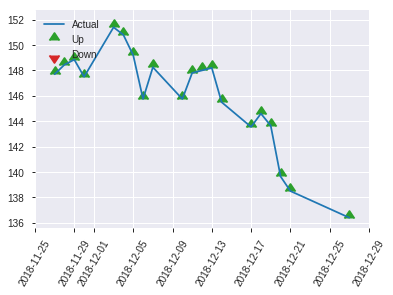


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25739939961981023
RMSE: 0.507345444071207
LogLoss: 0.7086457183666622
Mean Per-Class Error: 0.42917110874200426
AUC: 0.5638992537313433
pr_auc: 0.6048096307369114
Gini: 0.12779850746268662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.276157021522522: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    134  0        (0.0/134.0)
Total  1    245  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.276157     0.707124  244
max f2                       0.276157     0.857875  244
max f0point5                 0.41396      0.609418  146
max accuracy                 0.424958     0.573171  130
max precision                0.615723     1         0
max recall                   0.276157     1         244
max specificity              0.615723     1         0
max absolute_mcc             0.539633     0.169138  11
max min_per_class_accuracy   0.426955     0.567164  123
max mean_per_class_accuracy  0.424958     0.570829  130

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 43.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.595483           1.22388   1.22388            0.666667         0.605923  0.666667                    0.605923            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   0.580834           1.83582   1.46866            1                0.592609  0.8                         0.600597            0.0149254       0.0298507                  83.5821    46.8657
    3        0.0325203                   0.560851           1.83582   1.60634            1                0.569698  0.875                       0.58901             0.0223881       0.0522388                  83.5821    60.6343
    4        0.0406504                   0.548564           1.83582   1.65224            1                0.554598  0.9                         0.582127            0.0149254       0.0671642                  83.5821    65.2239
    5        0.0528455                   0.538121           1.22388   1.55339            0.666667         0.542012  0.846154                    0.57287             0.0149254       0.0820896                  22.3881    55.3387
    6        0.101626                    0.514313           0.764925  1.17493            0.416667         0.526538  0.64                        0.550631            0.0373134       0.119403                   -23.5075   17.4925
    7        0.150407                    0.492529           1.22388   1.1908             0.666667         0.504336  0.648649                    0.535616            0.0597015       0.179104                   22.3881    19.0803
    8        0.203252                    0.483894           0.847302  1.10149            0.461538         0.487202  0.6                         0.523029            0.0447761       0.223881                   -15.2698   10.1493
    9        0.300813                    0.466242           0.994403  1.06676            0.541667         0.473908  0.581081                    0.507098            0.0970149       0.320896                   -0.559701  6.67608
    10       0.402439                    0.44309            1.39522   1.14971            0.76             0.455229  0.626263                    0.493999            0.141791        0.462687                   39.5224    14.9706
    11       0.5                         0.427121           0.994403  1.1194             0.541667         0.434931  0.609756                    0.482474            0.0970149       0.559701                   -0.559701  11.9403
    12       0.601626                    0.413798           0.954627  1.09157            0.52             0.420321  0.594595                    0.471975            0.0970149       0.656716                   -4.53731   9.15692
    13       0.699187                    0.397848           0.764925  1.04599            0.416667         0.405032  0.569767                    0.462634            0.0746269       0.731343                   -23.5075   4.5991
    14       0.800813                    0.381715           0.807761  1.01576            0.44             0.393127  0.553299                    0.453813            0.0820896       0.813433                   -19.2239   1.57588
    15       0.898374                    0.359798           0.91791   1.00513            0.5              0.369541  0.547511                    0.444662            0.0895522       0.902985                   -8.20896   0.513271
    16       1                           0.268704           0.954627  1                  0.52             0.330883  0.544715                    

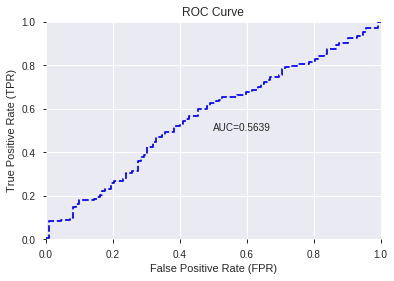

This function is available for GLM models only


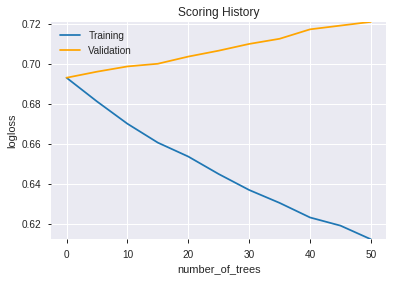

--2019-09-06 01:14:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.187.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.187.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_011356_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_011356_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'CORREL_14',
 'COS',
 'MFI_8',
 'CORREL_24',
 'day',
 'COSH',
 'SIN',
 'CORREL_20',
 'STOCHRSI_fastk',
 'CORREL_30',
 'EXP',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'weekday_name',
 'CDLMATCHINGLOW',
 'SINH',
 'CDLHAMMER']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_011430_model_1  0.516091  18.012633                   0.5  0.734418  0.539369

variable  relative_importance  scaled_importance    percentage
0                  CDLMARUBOZU         8.239579e-03           1.000000  1.186647e-02
1                          day         7.831062e-03           0.950420  1.127813e-02
2            CDLINVERTEDHAMMER         7.369514e-03           0.894404  1.061342e-02
3              CDLADVANCEBLOCK         6.615189e-03           0.802855  9.527054e-03
4             CDLSTICKSANDWICH         6.583865e-03           0.799054  9.481942e-03
...                        ...                  ...                ...           ...
1036   BBANDS_lowerband_20_0_2         7.036079e-07           0.000085  1.013321e-06
1037  BBANDS_middleband_24_2_5         5.389649e-07           0.000065  7.762058e-07
1038  BBANDS_middleband_20_2_3         2.691671e-07           0.000033  3.876487e-07
1039  BBANDS_middleband_14_4_3         3.063151e-08           0.000004  4.411484e-08
1040                    WMA_20         0.000000e+00           0.000000  0.000000e+00

[1041 rows x 4 columns]

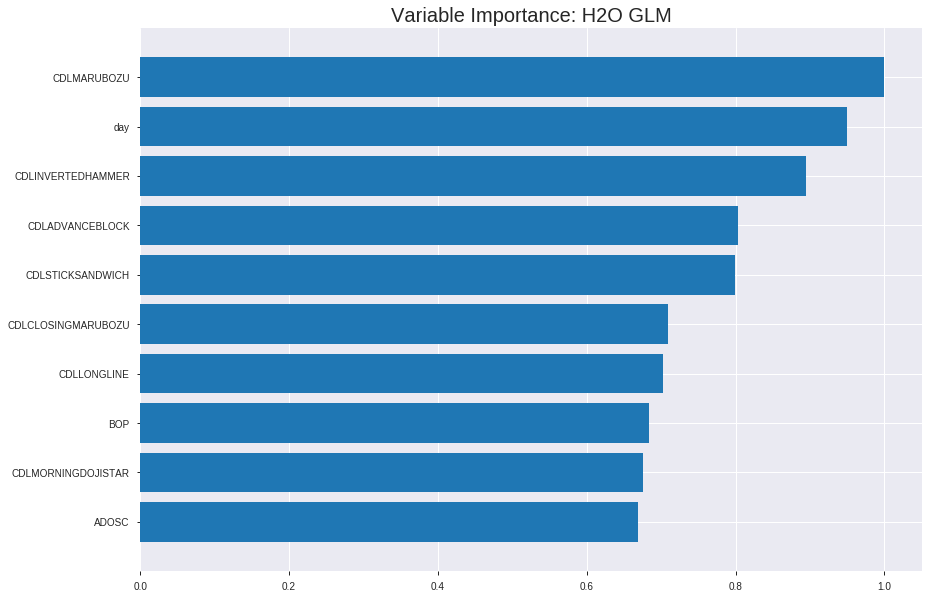

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_011430_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24530884815307233
RMSE: 0.4952866323181682
LogLoss: 0.6837205021818068
Null degrees of freedom: 1721
Residual degrees of freedom: 681
Null deviance: 2384.1875591118605
Residual deviance: 2354.7334095141423
AIC: 4436.733409514142
AUC: 0.6006351136785919
pr_auc: 0.6136432217408345
Gini: 0.2012702273571838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44486081262517285: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   809   0.9806   (809.0/825.0)
1      4    893   0.0045   (4.0/897.0)
Total  20   1702  0.4721   (813.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444861     0.687187  382
max f2                       0.420745     0.84511   396
max f0point5                 0.506481     0.599862  249
max accuracy                 0.521856     0.576655  192
max precision                0.610865     1         0
max recall                   0.420745     1         396
max specificity              0.610865     1         0
max absolute_mcc             0.531723     0.157765  153
max min_per_class_accuracy   0.523895     0.574136  185
max mean_per_class_accuracy  0.531113     0.576878  155

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.579207           1.59978   1.59978            0.833333         0.588525  0.833333                    0.588525            0.0167224       0.0167224                  59.9777    59.9777
    2        0.0203252                   0.574221           1.35511   1.48094            0.705882         0.576487  0.771429                    0.582678            0.0133779       0.0301003                  35.5105    48.0936
    3        0.0301974                   0.570245           1.01633   1.32905            0.529412         0.571993  0.692308                    0.579185            0.0100334       0.0401338                  1.63289    32.9046
    4        0.0400697                   0.567819           1.35511   1.33547            0.705882         0.56916   0.695652                    0.576715            0.0133779       0.0535117                  35.5105    33.5466
    5        0.0505226                   0.565462           1.27982   1.32395            0.666667         0.566509  0.689655                    0.574603            0.0133779       0.0668896                  27.9822    32.3953
    6        0.100465                    0.556401           1.38399   1.3538             0.72093          0.560002  0.705202                    0.567345            0.0691193       0.136009                   38.3993    35.38
    7        0.150407                    0.549732           1.20541   1.30453            0.627907         0.552474  0.679537                    0.562407            0.0602007       0.19621                    20.5413    30.4529
    8        0.200348                    0.544353           1.07148   1.24643            0.55814          0.546678  0.649275                    0.558486            0.0535117       0.249721                   7.14786    24.6435
    9        0.300232                    0.536888           1.07148   1.18823            0.55814          0.540161  0.618956                    0.55239             0.107023        0.356745                   7.14786    18.8229
    10       0.400116                    0.530324           1.14961   1.17859            0.598837         0.533551  0.613933                    0.547687            0.114827        0.471572                   14.9607    17.8588
    11       0.5                         0.523922           0.982189  1.13935            0.511628         0.527206  0.593496                    0.543595            0.0981048       0.569677                   -1.78113   13.9353
    12       0.599884                    0.516406           0.915221  1.10203            0.476744         0.520264  0.574056                    0.539711            0.0914158       0.661093                   -8.47787   10.2034
    13       0.699768                    0.506968           0.99335   1.08652            0.517442         0.511947  0.565975                    0.535748            0.0992196       0.760312                   -0.665007  8.65208
    14       0.799652                    0.496912           0.870576  1.05955            0.453488         0.502561  0.551924                    0.531602            0.0869565       0.847269                   -12.9424   5.95473
    15       0.899535                    0.482824           0.736642  1.02369            0.383721         0.491063  0.533247                    0.527101            0.0735786       0.920847                   -26.3358   2.36921
    16       1                           0.358984           0.787867  1                  0.410405         0.465438  0.520906                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3258180060873113
RMSE: 0.57080470047759
LogLoss: 5.18089772684513
Null degrees of freedom: 491
Residual degrees of freedom: -549
Null deviance: 678.9014289835272
Residual deviance: 78070.53307663453
AIC: 80152.53307663453
AUC: 0.5221054387721055
pr_auc: 0.547821766160608
Gini: 0.044210877544210936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.6321538271720637e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.63215e-49  0.708661   371
max f2                       2.63215e-49  0.858779   371
max f0point5                 2.63215e-49  0.603217   371
max accuracy                 0.286461     0.556911   341
max precision                0.286461     0.576023   341
max recall                   2.63215e-49  1          371
max specificity              0.546586     0.995495   0
max absolute_mcc             0.286461     0.0826661  341
max min_per_class_accuracy   0.472468     0.513514   246
max mean_per_class_accuracy  0.286461     0.538238   341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 33.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.536769           0.728889  0.728889           0.4              0.542725    0.4                         0.542725            0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.534717           0.364444  0.546667           0.2              0.53582     0.3                         0.539273            0.0037037       0.0111111                  -63.5556  -45.3333
    3        0.0304878                   0.533415           1.45778   0.85037            0.8              0.53421     0.466667                    0.537585            0.0148148       0.0259259                  45.7778   -14.963
    4        0.0406504                   0.53244            0.364444  0.728889           0.2              0.532958    0.4                         0.536428            0.0037037       0.0296296                  -63.5556  -27.1111
    5        0.050813                    0.530164           1.09333   0.801778           0.6              0.531633    0.44                        0.535469            0.0111111       0.0407407                  9.33333   -19.8222
    6        0.101626                    0.520233           0.947556  0.874667           0.52             0.525675    0.48                        0.530572            0.0481481       0.0888889                  -5.24444  -12.5333
    7        0.150407                    0.509911           1.21481   0.984985           0.666667         0.514138    0.540541                    0.525242            0.0592593       0.148148                   21.4815   -1.5015
    8        0.20122                     0.504005           1.09333   1.01235            0.6              0.506267    0.555556                    0.52045             0.0555556       0.203704                   9.33333   1.23457
    9        0.300813                    0.494452           1.00408   1.00961            0.55102          0.499058    0.554054                    0.513368            0.1             0.303704                   0.408163  0.960961
    10       0.400407                    0.484044           1.07846   1.02673            0.591837         0.488927    0.563452                    0.507288            0.107407        0.411111                   7.8458    2.67343
    11       0.5                         0.472496           1.00408   1.02222            0.55102          0.478008    0.560976                    0.501456            0.1             0.511111                   0.408163  2.22222
    12       0.599593                    0.457048           1.00408   1.01921            0.55102          0.465321    0.559322                    0.495454            0.1             0.611111                   0.408163  1.9209
    13       0.699187                    0.159133           1.22721   1.04884            0.673469         0.404413    0.575581                    0.482486            0.122222        0.733333                   22.7211   4.88372
    14       1                           0                  0.886486  1                  0.486486         0.00443408  0.54878                     0.338682            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:14:34  0.000 sec   2            3.6       1041          1.36744           158.68
    2019-09-06 01:14:36  1.924 sec   4            2.6       1041          1.36353           162.324
    2019-09-06 01:14:38  3.835 sec   6            1.9       1041          1.35896           165.546
    2019-09-06 01:14:40  5.749 sec   8            1.4       1041          1.35364           169.115
    2019-09-06 01:14:42  7.637 sec   10           1         1041          1.34759           171.948

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5160914179104478)

('logloss', 18.0126331734885)

('mean_per_class_error', 0.48274253731343286)

('rmse', 0.7344177577545223)

('mse', 0.5393694429051803)

glm prediction progress: |████████████████████████████████████████████████| 100%


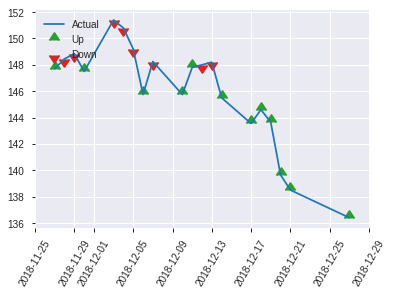


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5393694429051803
RMSE: 0.7344177577545223
LogLoss: 18.0126331734885
Null degrees of freedom: 245
Residual degrees of freedom: -795
Null deviance: 339.6180594432119
Residual deviance: 164962.55670029204
AIC: 167044.55670029204
AUC: 0.5160914179104478
pr_auc: 0.5884703832967476
Gini: 0.03218283582089554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.033272722327694e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.03327e-50  0.705263   20
max f2                       7.03327e-50  0.856777   20
max f0point5                 7.03327e-50  0.599284   20
max accuracy                 7.03327e-50  0.544715   20
max precision                0.493454     1          0
max recall                   7.03327e-50  1          20
max specificity              0.493454     1          0
max absolute_mcc             4.67155e-43  0.0628925  19
max min_per_class_accuracy   4.67155e-43  0.0970149  19
max mean_per_class_accuracy  4.67155e-43  0.517257   19

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.484865           0.61194   0.61194            0.333333         0.490031     0.333333                    0.490031            0.00746269      0.00746269                 -38.806   -38.806
    2        0.0203252                   0.153206           1.83582   1.10149            1                0.331312     0.6                         0.426543            0.0149254       0.0223881                  83.5821   10.1493
    3        0.0325203                   0.00378823         0.61194   0.91791            0.333333         0.0557713    0.5                         0.287504            0.00746269      0.0298507                  -38.806   -8.20896
    4        0.0406504                   1.82997e-06        0.91791   0.91791            0.5              1.24035e-05  0.5                         0.230006            0.00746269      0.0373134                  -8.20896  -8.20896
    5        0.0528455                   1.71687e-13        1.83582   1.12974            1                5.7134e-07   0.615385                    0.176928            0.0223881       0.0597015                  83.5821   12.9736
    6        0.101626                    2.18974e-74        1.22388   1.17493            0.666667         1.4282e-14   0.64                        0.0920023           0.0597015       0.119403                   22.3881   17.4925
    7        0.150407                    3.40416e-270       0.91791   1.09157            0.5              7.66619e-79  0.594595                    0.0621637           0.0447761       0.164179                   -8.20896  9.15692
    8        1                           0                  0.983789  1                  0.535885         0            0.544715                    0.00934983          0.835821        1                          -1.62108  0

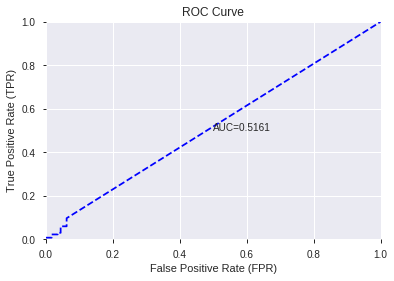

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


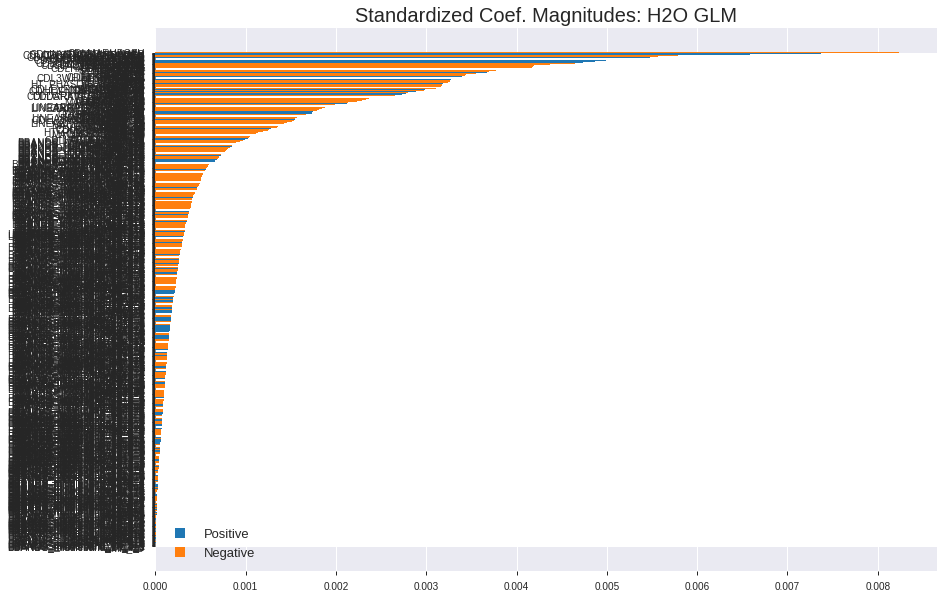

'log_likelihood'
--2019-09-06 01:15:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.43
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.43|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_011430_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_011430_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

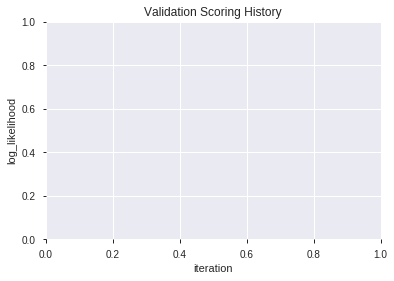

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190906_011508  0.511727  0.723480              0.494803  0.514235  0.264438
1  XGBoost_grid_1_AutoML_20190906_011508_model_4  0.507862  0.715198              0.479211  0.510630  0.260743
2  XGBoost_grid_1_AutoML_20190906_011508_model_3  0.503931  0.773541              0.500000  0.535416  0.286671
3               XGBoost_2_AutoML_20190906_011508  0.503531  0.732243              0.491071  0.518048  0.268373
4  XGBoost_grid_1_AutoML_20190906_011508_model_1  0.494869  0.723652              0.500000  0.514446  0.264655
5  XGBoost_grid_1_AutoML_20190906_011508_model_6  0.493337  0.738963              0.500000  0.521214  0.271664
6  XGBoost_grid_1_AutoML_20190906_011508_model_5  0.479811  0.762701              0.484408  0.530512  0.281443
7  XGBoost_grid_1_AutoML_20190906_011508_model_2  0.470682  0.715744              0.494803  0.510944  0.261064
8  XGBoost_grid_1_AutoML_20190906_011508_model_7  0.470149  0.767915              0.500000  0.533025  0.284116
9               XGBoost_1_AutoML_20190906_011508  0.457023  0.749250              0.495536  0.525825  0.276492

variable  relative_importance  scaled_importance  percentage
0                        BOP           154.871231           1.000000    0.028682
1                        TAN           128.804214           0.831686    0.023854
2                     Volume           120.421814           0.777561    0.022302
3               STOCHF_fastk           107.281723           0.692716    0.019868
4                    BETA_12           101.221802           0.653587    0.018746
..                       ...                  ...                ...         ...
269                STDDEV_12             1.452765           0.009380    0.000269
270  BBANDS_lowerband_12_2_4             1.301411           0.008403    0.000241
271               ROCR100_30             0.963871           0.006224    0.000179
272                 SAR_0.24             0.665663           0.004298    0.000123
273             aroondown_12             0.410009           0.002647    0.000076

[274 rows x 4 columns]

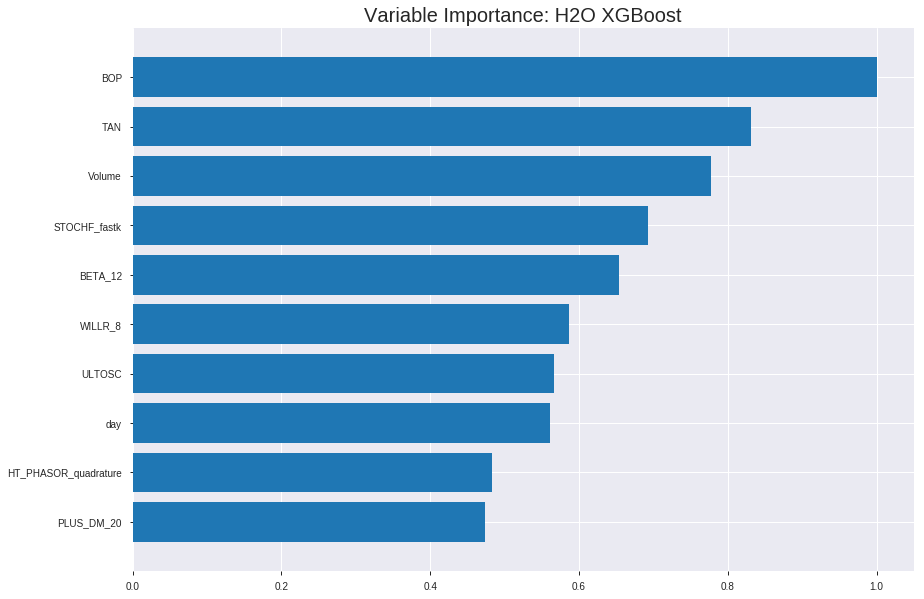

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190906_011508


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1777046198322853
RMSE: 0.4215502577775102
LogLoss: 0.5443761729515662
Mean Per-Class Error: 0.12121414817066989
AUC: 0.9542805986284247
pr_auc: 0.9576827440225275
Gini: 0.9085611972568495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4943275849024455: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      644  181   0.2194   (181.0/825.0)
1      47   850   0.0524   (47.0/897.0)
Total  691  1031  0.1324   (228.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494328     0.881743  211
max f2                       0.465154     0.929595  237
max f0point5                 0.556938     0.905344  152
max accuracy                 0.525284     0.878049  181
max precision                0.756413     1         0
max recall                   0.367982     1         325
max specificity              0.756413     1         0
max absolute_mcc             0.534092     0.757282  174
max min_per_class_accuracy   0.521494     0.871795  185
max mean_per_class_accuracy  0.534092     0.878786  174

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.725884           1.91973    1.91973            1                0.74218   1                           0.74218             0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.707474           1.91973    1.91973            1                0.715267  1                           0.729108            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.697204           1.91973    1.91973            1                0.702532  1                           0.72042             0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.688667           1.91973    1.91973            1                0.693226  1                           0.71372             0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.678418           1.91973    1.91973            1                0.683397  1                           0.707446            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.651276           1.91973    1.91973            1                0.66506   1                           0.686375            0.0958751       0.192865                   91.9732   91.9732
    7        0.150407                    0.631645           1.91973    1.91973            1                0.641011  1                           0.671313            0.0958751       0.28874                    91.9732   91.9732
    8        0.200348                    0.617449           1.83044    1.89747            0.953488         0.624625  0.988406                    0.659674            0.0914158       0.380156                   83.0443   89.7475
    9        0.300232                    0.589413           1.85277    1.8826             0.965116         0.603822  0.980658                    0.641093            0.185061        0.565217                   85.2765   88.26
    10       0.400116                    0.561656           1.68535    1.83336            0.877907         0.575468  0.955007                    0.624711            0.168339        0.733556                   68.5347   83.3358
    11       0.5                         0.52552            1.2947     1.72575            0.674419         0.544499  0.898955                    0.608687            0.12932         0.862876                   29.4703   72.5753
    12       0.599884                    0.493294           0.848254   1.57964            0.44186          0.509708  0.822846                    0.592207            0.0847269       0.947603                   -15.1746  57.9644
    13       0.699768                    0.457885           0.390643   1.40993            0.203488         0.474639  0.73444                     0.575425            0.039019        0.986622                   -60.9357  40.9928
    14       0.799652                    0.417014           0.111612   1.24776            0.0581395        0.438062  0.649964                    0.558267            0.0111483       0.99777                    -88.8388  24.7756
    15       0.899535                    0.369082           0.0111612  1.11045            0.00581395       0.391714  0.578438                    0.539773            0.00111483      0.998885                   -98.8839  11.0446
    16       1                           0.162345           0.0110967  1                  0.00578035       0.313359  0.520906                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26130970876712023
RMSE: 0.5111846131948029
LogLoss: 0.7166948179189774
Mean Per-Class Error: 0.4696696696696696
AUC: 0.5142809476142809
pr_auc: 0.5506073566405771
Gini: 0.028561895228561784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3017893433570862: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   210  0.9459   (210.0/222.0)
1      5    265  0.0185   (5.0/270.0)
Total  17   475  0.437    (215.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.301789     0.711409   382
max f2                       0.247323     0.859325   398
max f0point5                 0.34424      0.610948   356
max accuracy                 0.353219     0.565041   348
max precision                0.679543     0.666667   2
max recall                   0.247323     1          398
max specificity              0.73976      0.995495   0
max absolute_mcc             0.301789     0.0968166  382
max min_per_class_accuracy   0.452783     0.525926   203
max mean_per_class_accuracy  0.454928     0.53033    197

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 46.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.665015           0.728889  0.728889           0.4              0.6907    0.4                         0.6907              0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.651502           1.45778   1.09333            0.8              0.658842  0.6                         0.674771            0.0148148       0.0222222                  45.7778   9.33333
    3        0.0304878                   0.635829           1.09333   1.09333            0.6              0.64333   0.6                         0.664291            0.0111111       0.0333333                  9.33333   9.33333
    4        0.0406504                   0.626022           1.45778   1.18444            0.8              0.632046  0.65                        0.656229            0.0148148       0.0481481                  45.7778   18.4444
    5        0.050813                    0.619107           0.364444  1.02044            0.2              0.622019  0.56                        0.649387            0.0037037       0.0518519                  -63.5556  2.04444
    6        0.101626                    0.58089            0.728889  0.874667           0.4              0.596969  0.48                        0.623178            0.037037        0.0888889                  -27.1111  -12.5333
    7        0.150407                    0.552012           1.13889   0.96036            0.625            0.564907  0.527027                    0.604279            0.0555556       0.144444                   13.8889   -3.96396
    8        0.20122                     0.535375           0.947556  0.957127           0.52             0.544128  0.525253                    0.58909             0.0481481       0.192593                   -5.24444  -4.28732
    9        0.300813                    0.508339           1.00408   0.972673           0.55102          0.522774  0.533784                    0.567134            0.1             0.292593                   0.408163  -2.73273
    10       0.400407                    0.477314           1.30159   1.05448            0.714286         0.492064  0.57868                     0.548462            0.12963         0.422222                   30.1587   5.44839
    11       0.5                         0.452783           1.00408   1.04444            0.55102          0.465252  0.573171                    0.531887            0.1             0.522222                   0.408163  4.44444
    12       0.599593                    0.436303           0.855329  1.01303            0.469388         0.444259  0.555932                    0.517332            0.0851852       0.607407                   -14.4671  1.3032
    13       0.699187                    0.411991           1.07846   1.02235            0.591837         0.42324   0.561047                    0.50393             0.107407        0.714815                   7.8458    2.23514
    14       0.79878                     0.382819           0.818141  0.99689            0.44898          0.39854   0.547074                    0.490789            0.0814815       0.796296                   -18.1859  -0.310998
    15       0.898374                    0.344587           1.22721   1.02242            0.673469         0.368305  0.561086                    0.477211            0.122222        0.918519                   22.7211   2.24233
    16       1                           0.209481           0.801778  1                  0.44             0.30941   0.54878                     0.460158   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:15:20  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.45122
    2019-09-06 01:15:20  0.649 sec   5                  0.489463         0.672256            0.781815        0.77933            1.81308          0.304297                         0.502527           0.698226              0.49351           0.526049             0.728889           0.45122
    2019-09-06 01:15:20  0.840 sec   10                 0.481077         0.655856            0.830391        0.830992           1.91973          0.256098                         0.503362           0.699931              0.507441          0.537688             0.728889           0.445122
    2019-09-06 01:15:21  1.037 sec   15                 0.473024         0.640275            0.861343        0.863044           1.91973          0.229965                         0.502978           0.699167              0.515707          0.546032             0.728889           0.45122
    2019-09-06 01:15:21  1.242 sec   20                 0.463751         0.622528            0.885117        0.885828           1.91973          0.196283                         0.503832           0.70093               0.516275          0.544099             0.728889           0.449187
    2019-09-06 01:15:21  1.440 sec   25                 0.45831          0.612107            0.892858        0.896927           1.91973          0.188153                         0.506263           0.705988              0.506849          0.537756             1.09333            0.45122
    2019-09-06 01:15:21  1.642 sec   30                 0.450851         0.598082            0.909737        0.914174           1.91973          0.180023                         0.506794           0.707154              0.510018          0.540972             0.728889           0.45122
    2019-09-06 01:15:21  1.858 sec   35                 0.441495         0.5807              0.9272          0.931134           1.91973          0.152729                         0.507151           0.707998              0.5168            0.549387             1.09333            0.45122
    2019-09-06 01:15:22  2.086 sec   40                 0.433489         0.566097            0.941321        0.945011           1.91973          0.138792                         0.508459           0.710858              0.522981          0.552256             1.09333            0.45122
    2019-09-06 01:15:22  2.338 sec   45                 0.427545         0.555182            0.947616        0.951211           1.91973          0.136469                         0.510123           0.714391              0.519461          0.550651             0.728889           0.449187
    2019-09-06 01:15:22  2.541 sec   50                 0.42155          0.544376            0.954281        0.957683           1.91973          0.132404                         0.511185           0.716695              0.514281          0.550607             0.728889           0.436992

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      154.87123107910156     1.0                    0.028681761326969753
TAN                      128.80421447753906     0.8316858694805067     0.02385421560745321
Volume                   120.42181396484375     0.7775609009225055     0.02230181617744288
STOCHF_fastk             107.28172302246094     0.6927156339815369     0.019868304481318978
BETA_12                  101.2218017578125      0.6535868608554726     0.018746022349500055
---                      ---                    ---                    ---
STDDEV_12                1.4527645111083984     0.009380467250023916   0.0002690483228006423
BBANDS_lowerband_12_2_4  1.3014106750488281     0.00840317898928642    0.00024101797415852
ROCR100_30               0.9638710021972656     0.006223693035054146   0.00017850647820374702
SAR_0.24                 0.6656627655029297     0.004298169265297166   0.00012327906501017027
aroondown_12             0.41000938415527344    0.0026474212240610285  7.593270368047252e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5487804878048781)

('F1', 0.7055702917771882)

('auc', 0.511727078891258)

('logloss', 0.7234803391836486)

('mean_per_class_error', 0.4600879530916845)

('rmse', 0.5142353280884111)

('mse', 0.26443797265419583)

xgboost prediction progress: |████████████████████████████████████████████| 100%


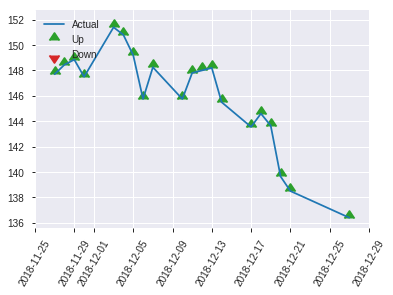


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26443797265419583
RMSE: 0.5142353280884111
LogLoss: 0.7234803391836486
Mean Per-Class Error: 0.4600879530916845
AUC: 0.511727078891258
pr_auc: 0.5668179062432257
Gini: 0.023454157782516027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2772051990032196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    133  0.0075   (1.0/134.0)
Total  3    243  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.277205     0.70557   242
max f2                       0.24218      0.856777  245
max f0point5                 0.277205     0.601266  242
max accuracy                 0.312919     0.54878   232
max precision                0.625259     1         0
max recall                   0.24218      1         245
max specificity              0.625259     1         0
max absolute_mcc             0.569491     0.117538  3
max min_per_class_accuracy   0.427794     0.507463  121
max mean_per_class_accuracy  0.47229      0.539912  69

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 42.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.571113           1.83582   1.83582            1                0.591734  1                           0.591734            0.0223881       0.0223881                  83.5821    83.5821
    2        0.0203252                   0.555711           0.91791   1.46866            0.5              0.562753  0.8                         0.580141            0.00746269      0.0298507                  -8.20896   46.8657
    3        0.0325203                   0.550805           0.61194   1.14739            0.333333         0.552866  0.625                       0.569913            0.00746269      0.0373134                  -38.806    14.7388
    4        0.0406504                   0.542825           0.91791   1.10149            0.5              0.54899   0.6                         0.565729            0.00746269      0.0447761                  -8.20896   10.1493
    5        0.0528455                   0.539819           1.22388   1.12974            0.666667         0.540921  0.615385                    0.560004            0.0149254       0.0597015                  22.3881    12.9736
    6        0.101626                    0.519829           0.91791   1.02806            0.5              0.526483  0.56                        0.543914            0.0447761       0.104478                   -8.20896   2.80597
    7        0.150407                    0.507931           1.0709    1.04195            0.583333         0.51413   0.567568                    0.534254            0.0522388       0.156716                   7.08955    4.19524
    8        0.203252                    0.492652           1.27095   1.10149            0.692308         0.500875  0.6                         0.525576            0.0671642       0.223881                   27.0953    10.1493
    9        0.300813                    0.468926           1.0709    1.09157            0.583333         0.479463  0.594595                    0.51062             0.104478        0.328358                   7.08955    9.15692
    10       0.402439                    0.449961           0.881194  1.03844            0.48             0.458582  0.565657                    0.497479            0.0895522       0.41791                    -11.8806   3.84441
    11       0.5                         0.427169           0.91791   1.01493            0.5              0.437429  0.552846                    0.485762            0.0895522       0.507463                   -8.20896   1.49254
    12       0.601626                    0.411027           0.954627  1.00474            0.52             0.41954   0.547297                    0.474576            0.0970149       0.604478                   -4.53731   0.473981
    13       0.699187                    0.394975           0.841418  0.981951           0.458333         0.402099  0.534884                    0.464463            0.0820896       0.686567                   -15.8582   -1.80493
    14       0.800813                    0.369709           1.17493   1.00644            0.64             0.382295  0.548223                    0.454035            0.119403        0.80597                    17.4925    0.643988
    15       0.898374                    0.335846           0.994403  1.00513            0.541667         0.351608  0.547511                    0.442912            0.0970149       0.902985                   -0.559701  0.513271
    16       1                           0.24218            0.954627  1                  0.52             0.305294  0.544715                

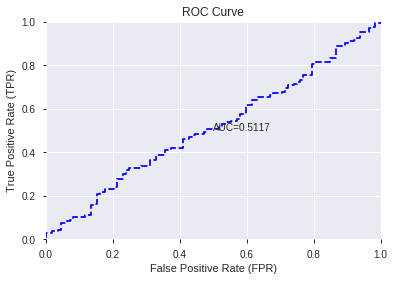

This function is available for GLM models only


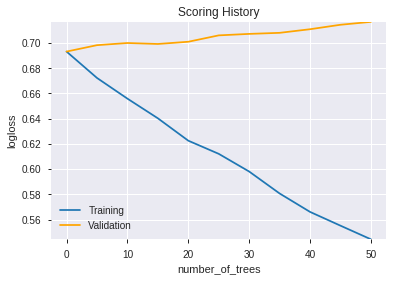

--2019-09-06 01:15:54--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.145.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.145.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(SharedTreeSubgraph.java:82)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftChildNod

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190906_011508',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190906_011508',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_42_sid_9c46',
   'type

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_011602_model_1  0.521222  17.756910              0.500000  0.732701  0.536851
1  DeepLearning_grid_1_AutoML_20190906_011602_model_8  0.512593  18.065852              0.500000  0.734578  0.539605
2  DeepLearning_grid_1_AutoML_20190906_011602_model_5  0.501599  14.892721              0.495536  0.669783  0.448610
3  DeepLearning_grid_1_AutoML_20190906_011602_model_2  0.501333  15.458548              0.500000  0.672851  0.452728
4  DeepLearning_grid_1_AutoML_20190906_011602_model_9  0.500000   0.691069              0.500000  0.498960  0.248961
5  DeepLearning_grid_1_AutoML_20190906_011602_model_3  0.498534  18.556263              0.500000  0.736263  0.542083
6  DeepLearning_grid_1_AutoML_20190906_011602_model_7  0.498467  18.350297              0.500000  0.736312  0.542155
7  DeepLearning_grid_1_AutoML_20190906_011602_model_4  0.497834  18.543471              0.500000  0.734961  0.540167
8               DeepLearning_1_AutoML_20190906_011602  0.497135  18.503128              0.500000  0.735448  0.540884
9  DeepLearning_grid_1_AutoML_20190906_011602_model_6  0.487607  14.788041              0.491071  0.667676  0.445791

variable  relative_importance  scaled_importance  percentage
0      CDLSTICKSANDWICH             1.000000           1.000000    0.027398
1       CDLUNIQUE3RIVER             0.995232           0.995232    0.027268
2       CDLLADDERBOTTOM             0.957442           0.957442    0.026232
3    CDLMORNINGDOJISTAR             0.948369           0.948369    0.025984
4      CDLCOUNTERATTACK             0.913954           0.913954    0.025041
5             CDL2CROWS             0.913280           0.913280    0.025022
6                  SINH             0.889426           0.889426    0.024369
7     CDLSTALLEDPATTERN             0.877718           0.877718    0.024048
8             CDLINNECK             0.876043           0.876043    0.024002
9       CDLADVANCEBLOCK             0.872059           0.872059    0.023893
10         CDLTHRUSTING             0.864475           0.864475    0.023685
11    CDL3WHITESOLDIERS             0.862396           0.862396    0.023628
12       CDLMORNINGSTAR             0.859995           0.859995    0.023563
13   CDLIDENTICAL3CROWS             0.859311           0.859311    0.023544
14                 COSH             0.855051           0.855051    0.023427
15          CDLPIERCING             0.850303           0.850303    0.023297
16   CDLEVENINGDOJISTAR             0.843059           0.843059    0.023099
17            CDLONNECK             0.838078           0.838078    0.022962
18                  EXP             0.837396           0.837396    0.022943
19       CDLEVENINGSTAR             0.835643           0.835643    0.022895
20    CDLINVERTEDHAMMER             0.750423           0.750423    0.020560
21     is_quarter_start             0.740082           0.740082    0.020277
22        CDLHIKKAKEMOD             0.728752           0.728752    0.019967
23                  COS             0.723111           0.723111    0.019812
24  CDLXSIDEGAP3METHODS             0.704619           0.704619    0.019305
25       is_quarter_end             0.704278           0.704278    0.019296
26                  day             0.694709           0.694709    0.019034
27       CDLMATCHINGLOW             0.689080           0.689080    0.018880
28                MFI_8             0.677336           0.677336    0.018558
29       STOCHRSI_fastk             0.677059           0.677059    0.018550
30         weekday_name             0.675098           0.675098    0.018497
31      CDLSHOOTINGSTAR             0.661956           0.661956    0.018137
32            CORREL_14             0.659557           0.659557    0.018071
33         CDLTASUKIGAP             0.644790           0.644790    0.017666
34    CDLGRAVESTONEDOJI             0.636876           0.636876    0.017449
35                  SIN             0.635942           0.635942    0.017424
36            CORREL_30             0.635926           0.635926    0.017423
37         HT_TRENDMODE             0.610718           0.610718    0.016733
38                  BOP             0.592849           0.592849    0.016243
39      CDLHOMINGPIGEON             0.583425           0.583425    0.015985
40       is_month_start             0.581609           0.581609    0.015935
41            CORREL_24             0.568654           0.568654    0.015580
42            CORREL_20             0.565743           0.565743    0.015500
43            CDLHAMMER             0.540979           0.540979    0.014822
44        CDLHANGINGMAN             0.533880           0.533880    0.014627
45    CDLDARKCLOUDCOVER             0.530637           0.530637    0.014539
46     CDLDRAGONFLYDOJI             0.516739           0.516739    0.014158
47       CDLRICKSHAWMAN             0.505384           0.505384    0.013847
48         is_month_end             0.492557           0.492557    0.013495
49            CDLTAKURI             0.486389           0.486389    0.013326

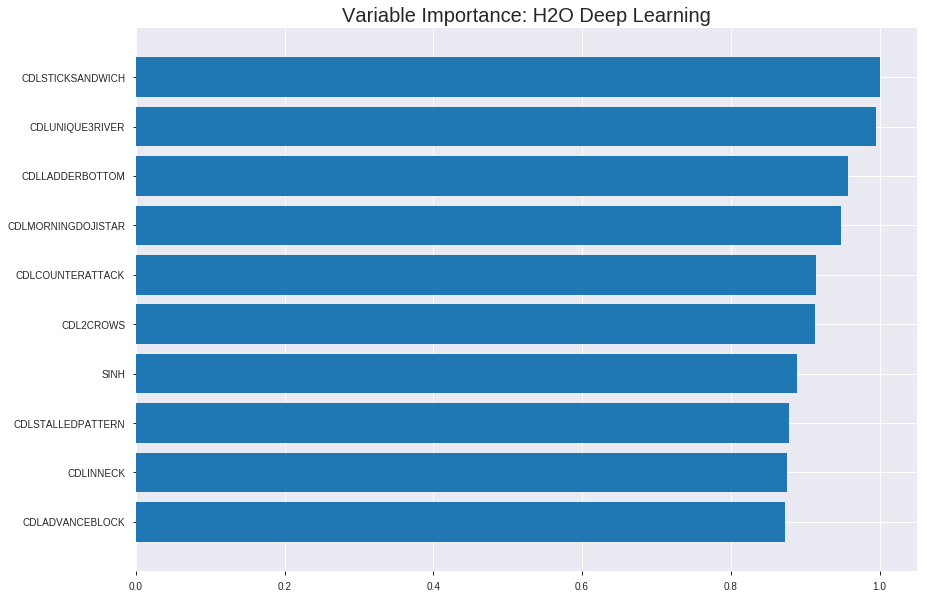

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_011602_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2401955490354398
RMSE: 0.49009748931762526
LogLoss: 0.7823236839698346
Mean Per-Class Error: 0.35918110874632614
AUC: 0.6919164893077937
pr_auc: 0.6651667130577584
Gini: 0.3838329786155874
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24353240124752606: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      335  490   0.5939   (490.0/825.0)
1      133  764   0.1483   (133.0/897.0)
Total  468  1254  0.3618   (623.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.243532     0.710367  299
max f2                       0.0181953    0.846505  390
max f0point5                 0.388216     0.655516  237
max accuracy                 0.356778     0.644019  250
max precision                0.951355     0.835714  22
max recall                   0.000136396  1         399
max specificity              0.999968     0.992727  0
max absolute_mcc             0.243532     0.289478  299
max min_per_class_accuracy   0.446313     0.637681  211
max mean_per_class_accuracy  0.388216     0.640819  237

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 47.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    1                  1.70643   1.70643            0.888889         1          0.888889                    1                   0.0178372       0.0178372                  70.6429   70.6429
    2        0.0203252                   0.999638           1.35511   1.53579            0.705882         0.999937   0.8                         0.999969            0.0133779       0.0312152                  35.5105   53.5786
    3        0.0301974                   0.99652            1.69388   1.58747            0.882353         0.998475   0.826923                    0.999481            0.0167224       0.0479376                  69.3882   58.7471
    4        0.0400697                   0.992746           1.46803   1.55804            0.764706         0.994881   0.811594                    0.998348            0.0144928       0.0624303                  46.8031   55.8044
    5        0.0505226                   0.985723           1.59978   1.56668            0.833333         0.990032   0.816092                    0.996627            0.0167224       0.0791527                  59.9777   56.6678
    6        0.100465                    0.910891           1.54025   1.55354            0.802326         0.954565   0.809249                    0.975718            0.0769231       0.156076                   54.025    55.3541
    7        0.150407                    0.830506           1.22774   1.44536            0.639535         0.868714   0.752896                    0.940188            0.0613155       0.217391                   22.7736   44.5358
    8        0.200348                    0.76061            1.20541   1.38555            0.627907         0.794232   0.721739                    0.903804            0.0602007       0.277592                   20.5413   38.5546
    9        0.300232                    0.648548           1.38399   1.38503            0.72093          0.700701   0.72147                     0.836234            0.138239        0.415831                   38.3993   38.5029
    10       0.400116                    0.543295           1.0938    1.31233            0.569767         0.594545   0.683599                    0.7759              0.109253        0.525084                   9.3801    31.2328
    11       0.5                         0.451185           1.06032   1.26198            0.552326         0.493782   0.657375                    0.719542            0.105909        0.630992                   6.03173   26.1984
    12       0.599884                    0.355221           1.03799   1.22469            0.540698         0.405143   0.637948                    0.667193            0.103679        0.734671                   3.79949   22.4689
    13       0.699768                    0.270181           0.881738  1.17574            0.459302         0.313872   0.612448                    0.61676             0.0880713       0.822742                   -11.8262  17.5737
    14       0.799652                    0.191144           0.72548   1.1195             0.377907         0.228813   0.583152                    0.568302            0.0724638       0.895206                   -27.452   11.9495
    15       0.899535                    0.097449           0.580384  1.05963            0.302326         0.147042   0.551969                    0.521526            0.057971        0.953177                   -41.9616  5.96328
    16       1                           7.14447e-14        0.466062  1                  0.242775         0.0431953  0.520906                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3885765366769744
RMSE: 0.6233590752343102
LogLoss: 5.465148926970909
Mean Per-Class Error: 0.45085085085085086
AUC: 0.5400567233900567
pr_auc: 0.5650725976204003
Gini: 0.08011344678011345
Confusion Matrix (Act/Pred) for max f1 @ threshold = 4.3158157025732806e-55: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       4.31582e-55  0.708661  376
max f2                       4.31582e-55  0.858779  376
max f0point5                 2.35291e-40  0.606229  375
max accuracy                 0.0558697    0.560976  301
max precision                0.999988     0.777778  2
max recall                   4.31582e-55  1         376
max specificity              1            0.990991  0
max absolute_mcc             0.0558697    0.101093  301
max min_per_class_accuracy   0.287715     0.525926  239
max mean_per_class_accuracy  0.0558697    0.549149  301

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 34.17 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   1                  1.09333   1.09333            0.6              1             0.6                         1                   0.0111111       0.0111111                  9.33333   9.33333
    2        0.0203252                   0.999981           1.45778   1.27556            0.8              0.999994      0.7                         0.999997            0.0148148       0.0259259                  45.7778   27.5556
    3        0.0304878                   0.998402           0.364444  0.971852           0.2              0.999526      0.533333                    0.99984             0.0037037       0.0296296                  -63.5556  -2.81481
    4        0.0406504                   0.99484            1.09333   1.00222            0.6              0.996421      0.55                        0.998985            0.0111111       0.0407407                  9.33333   0.222222
    5        0.050813                    0.989683           1.82222   1.16622            1                0.992299      0.64                        0.997648            0.0185185       0.0592593                  82.2222   16.6222
    6        0.101626                    0.898246           1.09333   1.12978            0.6              0.95337       0.62                        0.975509            0.0555556       0.114815                   9.33333   12.9778
    7        0.150407                    0.784349           0.759259  1.00961            0.416667         0.8346        0.554054                    0.929809            0.037037        0.151852                   -24.0741  0.960961
    8        0.20122                     0.692584           1.09333   1.03075            0.6              0.746786      0.565657                    0.883591            0.0555556       0.207407                   9.33333   3.0752
    9        0.300813                    0.534124           1.00408   1.02192            0.55102          0.61255       0.560811                    0.793854            0.1             0.307407                   0.408163  2.19219
    10       0.400407                    0.397666           1.2644    1.08223            0.693878         0.466209      0.593909                    0.712359            0.125926        0.433333                   26.4399   8.22335
    11       0.5                         0.28497            0.929705  1.05185            0.510204         0.345175      0.577236                    0.639221            0.0925926       0.525926                   -7.02948  5.18519
    12       0.599593                    0.101816           1.11565   1.06245            0.612245         0.185502      0.583051                    0.563857            0.111111        0.637037                   11.5646   6.24482
    13       0.699187                    0.00269138         0.855329  1.03295            0.469388         0.0361842     0.56686                     0.488695            0.0851852       0.722222                   -14.4671  3.29457
    14       0.79878                     6.33556e-161       1.11565   1.04326            0.612245         0.000199978   0.572519                    0.427788            0.111111        0.833333                   11.5646   4.3257
    15       1                           0                  0.828283  1                  0.454545         3.74375e-191  0.54878                     0.341709            0.166667        1                          -17.1717  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:16:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:16:09  5.767 sec         3041 obs/sec      10        1             17220      0.55986          1.09323             -0.255967      0.577094        0.554195           1.49313          0.462253                         0.638643           6.68099               -0.647135        0.478345          0.362889             0.927677           0.441057
    2019-09-06 01:16:15  11.269 sec        3112 obs/sec      20        2             34440      0.542725         0.927899            -0.180265      0.607056        0.610132           1.49313          0.462253                         0.642746           7.07042               -0.668371        0.537796          0.573554             1.09333            0.45122
    2019-09-06 01:16:20  16.507 sec        3185 obs/sec      30        3             51660      0.53524          0.962601            -0.147935      0.62764         0.61139            1.70643          0.461672                         0.651058           7.60196               -0.711801        0.526118          0.551745             0.728889           0.45122
    2019-09-06 01:16:25  21.532 sec        3255 obs/sec      40        4             68880      0.53548          0.995875            -0.148962      0.626198        0.593729           1.38647          0.445412                         0.638117           6.71473               -0.644424        0.462554          0.354975             0.911111           0.443089
    2019-09-06 01:16:34  30.865 sec        3398 obs/sec      60        6             103320     0.508451         0.85441             -0.0359023     0.662855        0.61603            1.81308          0.415215                         0.637096           6.13769               -0.639165        0.528212          0.554336             1.09333            0.45122
    2019-09-06 01:16:43  39.593 sec        3529 obs/sec      80        8             137760     0.490097         0.782324            0.0375352      0.691916        0.665167           1.70643          0.361789                         0.623359           5.46515               -0.569242        0.540057          0.565073             1.09333            0.45122
    2019-09-06 01:16:52  47.926 sec        3642 obs/sec      100       10            172200     0.492815         0.797085            0.0268306      0.692558        0.647462           1.91973          0.389663                         0.632006           6.32626               -0.613079        0.465632          0.375266             0.892517           0.445122
    2019-09-06 01:17:00  55.958 sec        3741 obs/sec      120       12            206640     0.478867         0.751175            0.0811375      0.715304        0.655532           1.81308          0.352497                         0.63132            6.2748                -0.609579        0.464565          0.380931             0.911111           0.445122
    2019-09-06 01:17:07  1 

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLSTICKSANDWICH    1.0                    1.0                  0.027398472396829257
CDLUNIQUE3RIVER     0.9952319264411926     0.9952319264411926   0.02726783446504222
CDLLADDERBOTTOM     0.9574423432350159     0.9574423432350159   0.026232457612680105
CDLMORNINGDOJISTAR  0.9483693838119507     0.9483693838119507   0.0259838723843697
CDLCOUNTERATTACK    0.913953959941864      0.913953959941864    0.025040942343439954
---                 ---                    ---                  ---
CDLDARKCLOUDCOVER   0.5306369662284851     0.5306369662284851   0.014538642271948368
CDLDRAGONFLYDOJI    0.5167389512062073     0.5167389512062073   0.014157857890989771
CDLRICKSHAWMAN      0.5053843855857849     0.5053843855857849   0.013846760138260642
is_month_end        0.4925574064254761     0.4925574064254761   0.013495320503802215
CDLTAKURI           0.4863886535167694     0.4863886535167694   0.013326306097510156


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5212220149253731)

('logloss', 17.756910463769955)

('mean_per_class_error', 0.4715485074626866)

('rmse', 0.7327010764844112)

('mse', 0.536850867481415)

deeplearning prediction progress: |███████████████████████████████████████| 100%


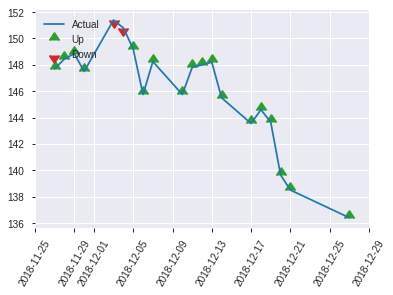


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.536850867481415
RMSE: 0.7327010764844112
LogLoss: 17.756910463769955
Mean Per-Class Error: 0.4715485074626866
AUC: 0.5212220149253731
pr_auc: 0.5875830926976935
Gini: 0.042444029850746245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.670134327072319e-51: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       9.67013e-51  0.705263   30
max f2                       9.67013e-51  0.856777   30
max f0point5                 9.67013e-51  0.599284   30
max accuracy                 9.67013e-51  0.544715   30
max precision                0.87184      1          0
max recall                   9.67013e-51  1          30
max specificity              0.87184      1          0
max absolute_mcc             5.76821e-17  0.0973375  22
max min_per_class_accuracy   1.15293e-37  0.141791   28
max mean_per_class_accuracy  5.76821e-17  0.528451   22

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.030747           1.22388   1.22388            0.666667         0.566907      0.666667                    0.566907            0.0149254       0.0149254                  22.3881   22.3881
    2        0.0203252                   0.00162169         0.91791   1.10149            0.5              0.00230977    0.6                         0.341068            0.00746269      0.0223881                  -8.20896  10.1493
    3        0.0325203                   0.000132825        0         0.688433           0                0.000921809   0.375                       0.213513            0               0.0223881                  -100      -31.1567
    4        0.0406504                   5.72894e-06        1.83582   0.91791            1                2.50059e-05   0.5                         0.170816            0.0149254       0.0373134                  83.5821   -8.20896
    5        0.0528455                   3.45184e-08        1.22388   0.988519           0.666667         1.77996e-06   0.538462                    0.131397            0.0149254       0.0522388                  22.3881   -1.14811
    6        0.101626                    7.20614e-20        1.37687   1.17493            0.75             3.80262e-09   0.64                        0.0683264           0.0671642       0.119403                   37.6866   17.4925
    7        0.150407                    1.41313e-68        0.91791   1.09157            0.5              2.88372e-21   0.594595                    0.0461665           0.0447761       0.164179                   -8.20896  9.15692
    8        0.203252                    1.19246e-223       1.12974   1.10149            0.615385         2.12716e-81   0.6                         0.0341632           0.0597015       0.223881                   12.9736   10.1493
    9        1                           0                  0.974109  1                  0.530612         1.17858e-234  0.544715                    0.00694374          0.776119        1                          -2.5891   0

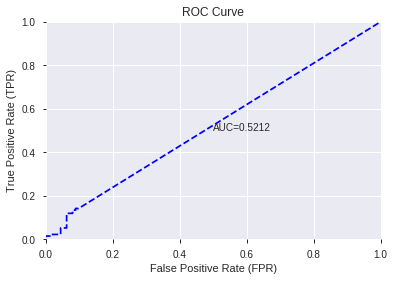

This function is available for GLM models only


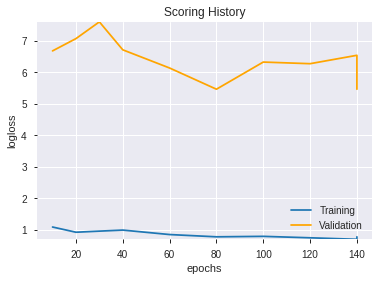

--2019-09-06 01:24:51--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_011602_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_011602_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTICKSANDWICH',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDLMORNINGDOJISTAR',
 'CDLCOUNTERATTACK',
 'CDL2CROWS',
 'SINH',
 'CDLSTALLEDPATTERN',
 'CDLINNECK',
 'CDLADVANCEBLOCK',
 'CDLTHRUSTING',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGSTAR',
 'CDLIDENTICAL3CROWS',
 'COSH',
 'CDLPIERCING',
 'CDLEVENINGDOJISTAR',
 'CDLONNECK',
 'EXP',
 'CDLEVENINGSTAR',
 'CDLINVERTEDHAMMER',
 'is_quarter_start',
 'CDLHIKKAKEMOD',
 'COS',
 'CDLXSIDEGAP3METHODS',
 'is_quarter_end',
 'day',
 'CDLMATCHINGLOW',
 'MFI_8',
 'STOCHRSI_fastk',
 'weekday_name',
 'CDLSHOOTINGSTAR',
 'CORREL_14',
 'CDLTASUKIGAP',
 'CDLGRAVESTONEDOJI',
 'SIN',
 'CORREL_30',
 'HT_TRENDMODE',
 'BOP',
 'CDLHOMINGPIGEON',
 'is_month_start',
 'CORREL_24',
 'CORREL_20',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLDARKCLOUDCOVER',
 'CDLDRAGONFLYDOJI',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLTAKURI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_012458_model_1  0.505597  18.098708                   0.5  0.734683  0.539759

variable  relative_importance  scaled_importance  percentage
0                   day             0.009196           1.000000    0.048902
1     CDLINVERTEDHAMMER             0.009110           0.990674    0.048446
2                   BOP             0.008763           0.952969    0.046602
3      CDLSTICKSANDWICH             0.007834           0.851971    0.041663
4       CDLADVANCEBLOCK             0.007608           0.827338    0.040459
5       CDLUNIQUE3RIVER             0.006911           0.751569    0.036753
6    CDLMORNINGDOJISTAR             0.006288           0.683795    0.033439
7                   COS             0.006193           0.673425    0.032932
8        CDLMATCHINGLOW             0.005850           0.636132    0.031108
9     CDLSTALLEDPATTERN             0.005736           0.623829    0.030507
10       CDLEVENINGSTAR             0.005480           0.595946    0.029143
11         HT_TRENDMODE             0.005474           0.595302    0.029112
12     CDLCOUNTERATTACK             0.005341           0.580786    0.028402
13      CDLLADDERBOTTOM             0.005070           0.551340    0.026962
14       is_quarter_end             0.004802           0.522240    0.025539
15            CDLHAMMER             0.004540           0.493725    0.024144
16                 COSH             0.004456           0.484583    0.023697
17                  EXP             0.004449           0.483870    0.023662
18                 SINH             0.004443           0.483208    0.023630
19            CORREL_14             0.004147           0.450966    0.022053
20                  SIN             0.003882           0.422157    0.020644
21         CDLTHRUSTING             0.003751           0.407953    0.019950
22            CDL2CROWS             0.003677           0.399841    0.019553
23   CDLEVENINGDOJISTAR             0.003612           0.392815    0.019209
24    CDL3WHITESOLDIERS             0.003481           0.378604    0.018515
25   CDLIDENTICAL3CROWS             0.003451           0.375277    0.018352
26         CDLTASUKIGAP             0.003399           0.369617    0.018075
27          CDLPIERCING             0.003288           0.357610    0.017488
28            CORREL_30             0.003209           0.348970    0.017065
29     is_quarter_start             0.003168           0.344535    0.016848
30    CDLGRAVESTONEDOJI             0.003132           0.340617    0.016657
31    CDLDARKCLOUDCOVER             0.002998           0.325990    0.015942
32            CORREL_20             0.002770           0.301249    0.014732
33       CDLMORNINGSTAR             0.002311           0.251368    0.012292
34        CDLHIKKAKEMOD             0.002172           0.236222    0.011552
35            CORREL_24             0.002158           0.234653    0.011475
36            CDLINNECK             0.002027           0.220386    0.010777
37                MFI_8             0.001842           0.200314    0.009796
38        CDLHANGINGMAN             0.001673           0.181978    0.008899
39            CDLONNECK             0.001669           0.181463    0.008874
40       STOCHRSI_fastk             0.001540           0.167451    0.008189
41      CDLHOMINGPIGEON             0.001465           0.159305    0.007790
42         is_month_end             0.001073           0.116694    0.005707
43            CDLTAKURI             0.001072           0.116594    0.005702
44       is_month_start             0.001023           0.111252    0.005440
45       CDLRICKSHAWMAN             0.000900           0.097848    0.004785
46      CDLSHOOTINGSTAR             0.000753           0.081901    0.004005
47         weekday_name             0.000414           0.044984    0.002200
48     CDLDRAGONFLYDOJI             0.000331           0.036027    0.001762
49  CDLXSIDEGAP3METHODS             0.000107           0.011678    0.000571

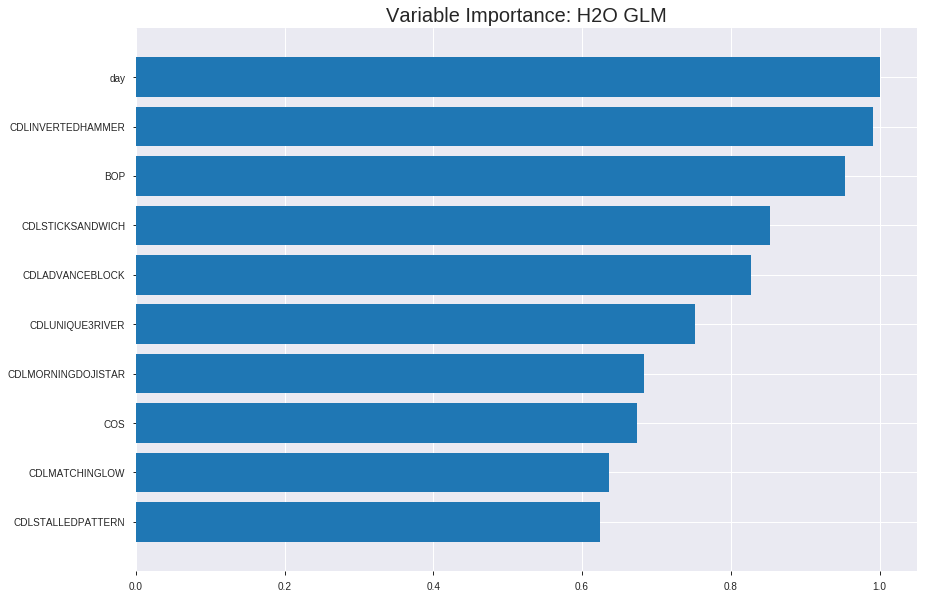

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_012458_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24800201060838237
RMSE: 0.4979980026148522
LogLoss: 0.689137593797036
Null degrees of freedom: 1721
Residual degrees of freedom: 1671
Null deviance: 2384.1875591118605
Residual deviance: 2373.3898730369924
AIC: 2475.3898730369924
AUC: 0.5931982027634202
pr_auc: 0.6131926610694283
Gini: 0.18639640552684034
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5082126319880191: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      35   790   0.9576   (790.0/825.0)
1      8    889   0.0089   (8.0/897.0)
Total  43   1679  0.4634   (798.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.508213     0.690217  367
max f2                       0.505346     0.846576  377
max f0point5                 0.516786     0.600194  280
max accuracy                 0.517875     0.575494  261
max precision                0.595501     1         0
max recall                   0.501003     1         390
max specificity              0.595501     1         0
max absolute_mcc             0.516786     0.148056  280
max min_per_class_accuracy   0.52055      0.559643  213
max mean_per_class_accuracy  0.518885     0.569693  242

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.548266           1.91973   1.91973            1                0.563217  1                           0.563217            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.541066           1.46803   1.70033            0.764706         0.544733  0.885714                    0.554239            0.0144928       0.0345596                  46.8031   70.0334
    3        0.0301974                   0.536252           1.35511   1.58747            0.705882         0.538701  0.826923                    0.549159            0.0133779       0.0479376                  35.5105   58.7471
    4        0.0400697                   0.533303           1.24218   1.5024             0.647059         0.535112  0.782609                    0.545698            0.0122631       0.0602007                  24.218    50.2399
    5        0.0505226                   0.531215           1.27982   1.45635            0.666667         0.53221   0.758621                    0.542908            0.0133779       0.0735786                  27.9822   45.6349
    6        0.100465                    0.527995           1.07148   1.26503            0.55814          0.529261  0.65896                     0.536124            0.0535117       0.12709                    7.14786   26.5026
    7        0.150407                    0.526422           1.31703   1.28229            0.686047         0.527097  0.667954                    0.533126            0.0657748       0.192865                   31.7026   28.2292
    8        0.200348                    0.525164           1.02683   1.21861            0.534884         0.525837  0.634783                    0.531309            0.0512821       0.244147                   2.68336   21.8613
    9        0.300232                    0.523355           0.971027  1.13624            0.505814         0.524196  0.591876                    0.528943            0.09699         0.341137                   -2.89725  13.6244
    10       0.400116                    0.521842           1.12728   1.13401            0.587209         0.522592  0.590711                    0.527357            0.112598        0.453735                   12.7285   13.4007
    11       0.5                         0.520548           1.03799   1.11483            0.540698         0.521181  0.58072                     0.526124            0.103679        0.557414                   3.79949   11.4827
    12       0.599884                    0.519213           0.971027  1.09088            0.505814         0.519895  0.568248                    0.525086            0.09699         0.654404                   -2.89725  9.08838
    13       0.699768                    0.517769           1.08264   1.08971            0.563953         0.518516  0.567635                    0.524149            0.108138        0.762542                   8.26398   8.9707
    14       0.799652                    0.516115           0.837093  1.05815            0.436047         0.517003  0.551198                    0.523256            0.083612        0.846154                   -16.2907  5.81532
    15       0.899535                    0.513646           0.90406   1.04104            0.47093          0.515039  0.542285                    0.522344            0.090301        0.936455                   -9.594    4.10428
    16       1                           0.383827           0.632513  1                  0.32948          0.508032  0.520906                    0.520906          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3230073897381102
RMSE: 0.5683373907619577
LogLoss: 5.215163634766801
Null degrees of freedom: 491
Residual degrees of freedom: 441
Null deviance: 678.9014289835272
Residual deviance: 80300.26866446836
AIC: 80402.26866446836
AUC: 0.5221137804471138
pr_auc: 0.5537774498705748
Gini: 0.044227560894227524
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.562632314415618e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.56263e-50  0.708661   368
max f2                       7.56263e-50  0.858779   368
max f0point5                 7.56263e-50  0.603217   368
max accuracy                 0.230078     0.556911   341
max precision                0.62627      1          0
max recall                   7.56263e-50  1          368
max specificity              0.62627      1          0
max absolute_mcc             0.230078     0.0826661  341
max min_per_class_accuracy   0.516806     0.503704   245
max mean_per_class_accuracy  0.230078     0.538238   341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 35.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.553724           1.09333   1.09333            0.6              0.571986    0.6                         0.571986            0.0111111       0.0111111                  9.33333   9.33333
    2        0.0203252                   0.550986           0.728889  0.911111           0.4              0.552346    0.5                         0.562166            0.00740741      0.0185185                  -27.1111  -8.88889
    3        0.0304878                   0.549073           1.09333   0.971852           0.6              0.550065    0.533333                    0.558132            0.0111111       0.0296296                  9.33333   -2.81481
    4        0.0406504                   0.545379           0.364444  0.82               0.2              0.547627    0.45                        0.555506            0.0037037       0.0333333                  -63.5556  -18
    5        0.050813                    0.54189            0.364444  0.728889           0.2              0.544328    0.4                         0.55327             0.0037037       0.037037                   -63.5556  -27.1111
    6        0.101626                    0.530737           1.23911   0.984              0.68             0.535551    0.54                        0.544411            0.062963        0.1                        23.9111   -1.6
    7        0.150407                    0.526382           0.987037  0.984985           0.541667         0.528137    0.540541                    0.539133            0.0481481       0.148148                   -1.2963   -1.5015
    8        0.20122                     0.524752           1.02044   0.993939           0.56             0.525605    0.545455                    0.535717            0.0518519       0.2                        2.04444   -0.606061
    9        0.300813                    0.521802           1.15283   1.04655            0.632653         0.523087    0.574324                    0.531535            0.114815        0.314815                   15.2834   4.65465
    10       0.400407                    0.519663           0.892517  1.00823            0.489796         0.520802    0.553299                    0.528865            0.0888889       0.403704                   -10.7483  0.823463
    11       0.5                         0.516802           1.00408   1.00741            0.55102          0.518287    0.552846                    0.526758            0.1             0.503704                   0.408163  0.740741
    12       0.599593                    0.511354           1.15283   1.03156            0.632653         0.514794    0.566102                    0.524771            0.114815        0.618519                   15.2834   3.15631
    13       0.699187                    0.107859           1.15283   1.04884            0.632653         0.439828    0.575581                    0.512672            0.114815        0.733333                   15.2834   4.88372
    14       1                           0                  0.886486  1                  0.486486         0.00242857  0.54878                     0.359184            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:24:59  0.000 sec   2            3         51            1.37828           163.212
    2019-09-06 01:24:59  0.014 sec   4            1.9       51            1.37526           168.753
    2019-09-06 01:24:59  0.024 sec   6            1.2       51            1.37127           173.094
    2019-09-06 01:24:59  0.032 sec   8            0.73      51            1.36637           175.875
    2019-09-06 01:24:59  0.042 sec   10           0.45      51            1.36089           178.92

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5055970149253731)

('logloss', 18.098707523873358)

('mean_per_class_error', 0.4924706823027718)

('rmse', 0.7346829095232575)

('mse', 0.539758977545559)

glm prediction progress: |████████████████████████████████████████████████| 100%


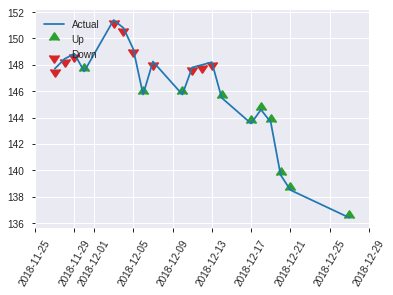


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.539758977545559
RMSE: 0.7346829095232575
LogLoss: 18.098707523873358
Null degrees of freedom: 245
Residual degrees of freedom: 195
Null deviance: 339.6180594432119
Residual deviance: 167071.34358060602
AIC: 167173.34358060602
AUC: 0.5055970149253731
pr_auc: 0.5593722765839673
Gini: 0.011194029850746245
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.0941575389765479e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.09416e-50  0.705263   17
max f2                       2.09416e-50  0.856777   17
max f0point5                 2.09416e-50  0.599284   17
max accuracy                 2.09416e-50  0.544715   17
max precision                0.525757     1          0
max recall                   2.09416e-50  1          17
max specificity              0.525757     1          0
max absolute_mcc             0.525757     0.0584082  0
max min_per_class_accuracy   1.87214e-32  0.0746269  16
max mean_per_class_accuracy  4.21949e-18  0.507529   12

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score         cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ------------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.511723           0.61194   0.61194            0.333333         0.519395      0.333333                    0.519395            0.00746269      0.00746269                 -38.806   -38.806
    2        0.0203252                   0.10012            1.83582   1.10149            1                0.31491       0.6                         0.437601            0.0149254       0.0223881                  83.5821   10.1493
    3        0.0325203                   0.000671722        0.61194   0.91791            0.333333         0.0339101     0.5                         0.286217            0.00746269      0.0298507                  -38.806   -8.20896
    4        0.0406504                   2.31509e-08        0.91791   0.91791            0.5              2.56149e-07   0.5                         0.228974            0.00746269      0.0373134                  -8.20896  -8.20896
    5        0.0528455                   4.17535e-18        1.83582   1.12974            1                4.20164e-09   0.615385                    0.176134            0.0223881       0.0597015                  83.5821   12.9736
    6        0.101626                    2.80953e-101       1.22388   1.17493            0.666667         3.3742e-19    0.64                        0.0915895           0.0597015       0.119403                   22.3881   17.4925
    7        1                           0                  0.980212  1                  0.533937         1.91622e-108  0.544715                    0.00930787          0.880597        1                          -1.97879  0

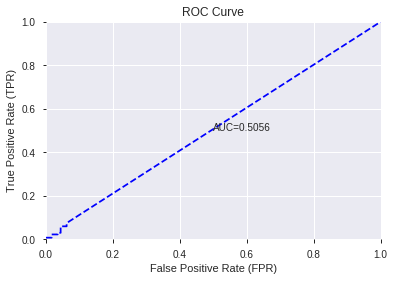

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


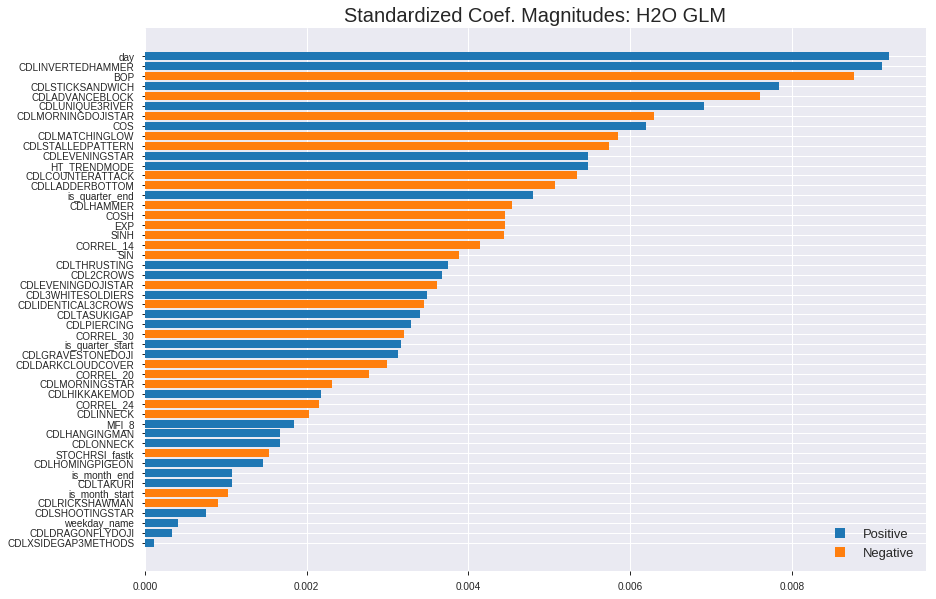

'log_likelihood'
--2019-09-06 01:25:05--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_012458_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_012458_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['day',
 'CDLINVERTEDHAMMER',
 'BOP',
 'CDLSTICKSANDWICH',
 'CDLADVANCEBLOCK',
 'CDLUNIQUE3RIVER',
 'CDLMORNINGDOJISTAR',
 'COS',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'HT_TRENDMODE',
 'CDLCOUNTERATTACK',
 'CDLLADDERBOTTOM',
 'is_quarter_end',
 'CDLHAMMER',
 'COSH',
 'EXP',
 'SINH',
 'CORREL_14',
 'SIN',
 'CDLTHRUSTING',
 'CDL2CROWS',
 'CDLEVENINGDOJISTAR',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLTASUKIGAP',
 'CDLPIERCING',
 'CORREL_30',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'CDLDARKCLOUDCOVER',
 'CORREL_20',
 'CDLMORNINGSTAR',
 'CDLHIKKAKEMOD',
 'CORREL_24',
 'CDLINNECK',
 'MFI_8',
 'CDLHANGINGMAN',
 'CDLONNECK',
 'STOCHRSI_fastk',
 'CDLHOMINGPIGEON',
 'is_month_end',
 'CDLTAKURI',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'CDLSHOOTINGSTAR',
 'weekday_name',
 'CDLDRAGONFLYDOJI',
 'CDLXSIDEGAP3METHODS']

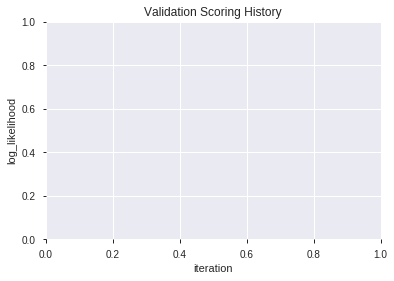

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_012515_model_1  0.563899  0.708646              0.495536  0.507345  0.257399
1  XGBoost_grid_1_AutoML_20190906_012515_model_7  0.546908  0.710206              0.500000  0.507863  0.257925
2               XGBoost_1_AutoML_20190906_012515  0.542444  0.699355              0.500000  0.502897  0.252905
3  XGBoost_grid_1_AutoML_20190906_012515_model_2  0.542377  0.695455              0.500000  0.501077  0.251078
4  XGBoost_grid_1_AutoML_20190906_012515_model_5  0.541511  0.746111              0.491071  0.523329  0.273873
5  XGBoost_grid_1_AutoML_20190906_012515_model_6  0.539845  0.719834              0.500000  0.512572  0.262731
6               XGBoost_3_AutoML_20190906_012515  0.525586  0.709887              0.474747  0.507997  0.258061
7  XGBoost_grid_1_AutoML_20190906_012515_model_4  0.509262  0.703164              0.495536  0.504836  0.254860
8               XGBoost_2_AutoML_20190906_012515  0.509128  0.704139              0.485141  0.505375  0.255404
9  XGBoost_grid_1_AutoML_20190906_012515_model_3  0.500200  0.726123              0.495536  0.515425  0.265663

variable  relative_importance  scaled_importance  percentage
0                 BOP           414.090607           1.000000    0.146272
1           CORREL_14           347.644287           0.839537    0.122800
2                 COS           266.280243           0.643048    0.094060
3               MFI_8           240.397018           0.580542    0.084917
4           CORREL_24           230.960205           0.557753    0.081583
5                 day           222.108932           0.536378    0.078457
6                COSH           207.868790           0.501989    0.073427
7                 SIN           202.868866           0.489914    0.071661
8           CORREL_20           193.831985           0.468091    0.068468
9      STOCHRSI_fastk           143.613464           0.346817    0.050729
10          CORREL_30           131.821732           0.318340    0.046564
11                EXP            58.930779           0.142314    0.020816
12  CDLINVERTEDHAMMER            51.007576           0.123180    0.018018
13       HT_TRENDMODE            42.167530           0.101832    0.014895
14       weekday_name            36.440834           0.088002    0.012872
15     CDLMATCHINGLOW            20.926826           0.050537    0.007392
16               SINH            17.040874           0.041153    0.006019
17          CDLHAMMER             2.970206           0.007173    0.001049

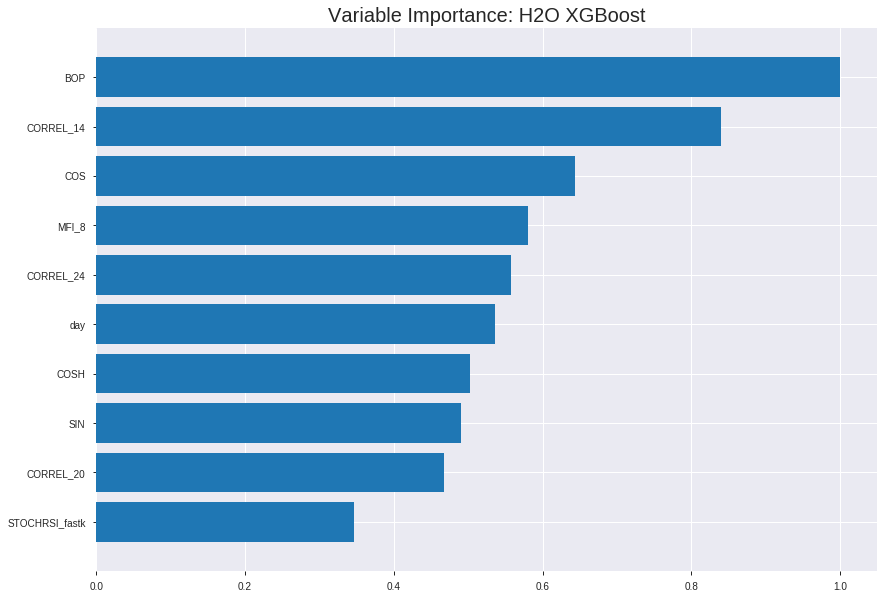

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_012515_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21047804909703668
RMSE: 0.4587788673174002
LogLoss: 0.6122812149576731
Mean Per-Class Error: 0.24332623897841288
AUC: 0.8343697848045675
pr_auc: 0.8419516120780777
Gini: 0.6687395696091349
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5046523690223694: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      538  287   0.3479   (287.0/825.0)
1      148  749   0.165    (148.0/897.0)
Total  686  1036  0.2526   (435.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.504652     0.774961  214
max f2                       0.460798     0.867718  272
max f0point5                 0.539161     0.785168  165
max accuracy                 0.514646     0.755517  200
max precision                0.735653     1         0
max recall                   0.285738     1         385
max specificity              0.735653     1         0
max absolute_mcc             0.53561      0.515492  170
max min_per_class_accuracy   0.520584     0.749164  191
max mean_per_class_accuracy  0.530564     0.756674  176

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.93 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.703574           1.91973    1.91973            1                0.716685  1                           0.716685            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.686946           1.91973    1.91973            1                0.69182   1                           0.704608            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.667203           1.91973    1.91973            1                0.675321  1                           0.695033            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.659666           1.91973    1.91973            1                0.662311  1                           0.686971            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.649975           1.70643    1.8756             0.888889         0.653847  0.977011                    0.680118            0.0178372       0.0947603                  70.6429   87.5601
    6        0.100465                    0.620119           1.76348    1.81986            0.918605         0.633226  0.947977                    0.656807            0.0880713       0.182832                   76.3475   81.9862
    7        0.150407                    0.597728           1.69651    1.7789             0.883721         0.608315  0.926641                    0.640706            0.0847269       0.267559                   69.6508   77.8903
    8        0.200348                    0.585869           1.56257    1.72498            0.813953         0.592417  0.898551                    0.628669            0.0780379       0.345596                   56.2573   72.4977
    9        0.300232                    0.562914           1.55141    1.66723            0.80814          0.573816  0.868472                    0.61042             0.154961        0.500557                   55.1412   66.7234
    10       0.400116                    0.543581           1.36167    1.59095            0.709302         0.552845  0.828737                    0.596047            0.136009        0.636566                   36.1671   59.0954
    11       0.5                         0.522501           1.06032    1.48495            0.552326         0.532005  0.773519                    0.583253            0.105909        0.742475                   6.03173   48.495
    12       0.599884                    0.504671           0.915221   1.39009            0.476744         0.513901  0.724105                    0.571706            0.0914158       0.833891                   -8.47787  39.0087
    13       0.699768                    0.482518           0.736642   1.29682            0.383721         0.493123  0.675519                    0.560489            0.0735786       0.907469                   -26.3358  29.6815
    14       0.799652                    0.456527           0.524578   1.20036            0.273256         0.470746  0.625272                    0.549279            0.0523969       0.959866                   -47.5422  20.0356
    15       0.899535                    0.414507           0.312515   1.10177            0.162791         0.436728  0.573919                    0.536782            0.0312152       0.991081                   -68.7485  10.177
    16       1                           0.20262            0.0887738  1                  0.0462428        0.362389  0.520906                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.2634522130599882
RMSE: 0.5132759618957313
LogLoss: 0.7211153438531896
Mean Per-Class Error: 0.4868368368368369
AUC: 0.4784284284284284
pr_auc: 0.5178902829758539
Gini: -0.04314314314314316
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.27597102522850037: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.275971     0.708661  399
max f2                       0.275971     0.858779  399
max f0point5                 0.275971     0.603217  399
max accuracy                 0.275971     0.54878   399
max precision                0.704431     1         0
max recall                   0.275971     1         399
max specificity              0.704431     1         0
max absolute_mcc             0.313884     0.101663  389
max min_per_class_accuracy   0.480351     0.490991  197
max mean_per_class_accuracy  0.459585     0.513163  233

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 47.84 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.658863           0.364444  0.364444           0.2              0.675781  0.2                         0.675781            0.0037037       0.0037037                  -63.5556  -63.5556
    2        0.0203252                   0.646339           1.45778   0.911111           0.8              0.652613  0.5                         0.664197            0.0148148       0.0185185                  45.7778   -8.88889
    3        0.0304878                   0.632835           0.728889  0.85037            0.4              0.638793  0.466667                    0.655729            0.00740741      0.0259259                  -27.1111  -14.963
    4        0.0406504                   0.621672           0.364444  0.728889           0.2              0.626838  0.4                         0.648507            0.0037037       0.0296296                  -63.5556  -27.1111
    5        0.050813                    0.617452           0.364444  0.656              0.2              0.620236  0.36                        0.642852            0.0037037       0.0333333                  -63.5556  -34.4
    6        0.101626                    0.588703           1.16622   0.911111           0.64             0.59825   0.5                         0.620551            0.0592593       0.0925926                  16.6222   -8.88889
    7        0.150407                    0.568694           0.759259  0.861862           0.416667         0.576684  0.472973                    0.606324            0.037037        0.12963                    -24.0741  -13.8138
    8        0.20122                     0.555485           0.874667  0.865095           0.48             0.561577  0.474747                    0.595024            0.0444444       0.174074                   -12.5333  -13.4905
    9        0.300813                    0.528247           0.966893  0.898799           0.530612         0.541801  0.493243                    0.577403            0.0962963       0.27037                    -3.31066  -10.1201
    10       0.400407                    0.502643           1.11565   0.952735           0.612245         0.516642  0.522843                    0.56229             0.111111        0.381481                   11.5646   -4.72645
    11       0.5                         0.480039           1.11565   0.985185           0.612245         0.491936  0.54065                     0.548276            0.111111        0.492593                   11.5646   -1.48148
    12       0.599593                    0.458231           1.19002   1.01921            0.653061         0.46846   0.559322                    0.535019            0.118519        0.611111                   19.0023   1.9209
    13       0.699187                    0.428127           0.855329  0.995866           0.469388         0.443823  0.546512                    0.522029            0.0851852       0.696296                   -14.4671  -0.413437
    14       0.79878                     0.400453           1.04127   1.00153            0.571429         0.414745  0.549618                    0.508652            0.103704        0.8                        4.12698   0.152672
    15       0.898374                    0.364025           1.00408   1.00181            0.55102          0.384724  0.549774                    0.494914            0.1             0.9                        0.408163  0.180995
    16       1                           0.275971           0.984     1                  0.54             0.332421  0.54878                     0.4784 


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:25:18  0.019 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.45122
    2019-09-06 01:25:19  0.069 sec   5                  0.494038         0.681273            0.685342        0.688591           1.70643          0.396632                         0.501504           0.696174              0.488096          0.528072             0.364444           0.45122
    2019-09-06 01:25:19  0.104 sec   10                 0.488408         0.670121            0.72934         0.732897           1.63177          0.355401                         0.502787           0.698803              0.482424          0.529387             0.364444           0.45122
    2019-09-06 01:25:19  0.139 sec   15                 0.48362          0.660655            0.749371        0.758244           1.81308          0.334495                         0.503426           0.700151              0.490249          0.537248             0.728889           0.45122
    2019-09-06 01:25:19  0.177 sec   20                 0.480108         0.653694            0.754803        0.762655           1.70643          0.332172                         0.505139           0.703737              0.490991          0.53393              0.728889           0.45122
    2019-09-06 01:25:19  0.219 sec   25                 0.475645         0.644937            0.778623        0.78617            1.91973          0.33101                          0.506542           0.706697              0.489706          0.531988             0.728889           0.45122
    2019-09-06 01:25:19  0.261 sec   30                 0.471554         0.63696             0.795269        0.801625           1.91973          0.304297                         0.508149           0.71007               0.483926          0.526709             0.728889           0.45122
    2019-09-06 01:25:19  0.298 sec   35                 0.468224         0.630498            0.80774         0.81331            1.91973          0.292102                         0.509358           0.712649              0.483684          0.525301             0.728889           0.45122
    2019-09-06 01:25:19  0.343 sec   40                 0.464452         0.623204            0.819701        0.826133           1.91973          0.29036                          0.511568           0.717372              0.48023           0.520524             0.728889           0.449187
    2019-09-06 01:25:19  0.389 sec   45                 0.462334         0.619115            0.825809        0.831417           1.91973          0.288618                         0.512417           0.719247              0.481198          0.521294             0.364444           0.45122
    2019-09-06 01:25:19  0.449 sec   50                 0.458779         0.612281            0.83437         0.841952           1.91973          0.252613                         0.513276           0.721115              0.478428          0.51789              0.364444           0.45122

Variable Importances: 


variable           relative_importance    scaled_importance    percentage
-----------------  ---------------------  -------------------  ------------
BOP                414.091                1                    0.146272
CORREL_14          347.644                0.839537             0.1228
COS                266.28                 0.643048             0.0940597
MFI_8              240.397                0.580542             0.0849168
CORREL_24          230.96                 0.557753             0.0815834
day                222.109                0.536378             0.0784568
COSH               207.869                0.501989             0.0734267
SIN                202.869                0.489914             0.0716605
CORREL_20          193.832                0.468091             0.0684684
STOCHRSI_fastk     143.613                0.346817             0.0507294
CORREL_30          131.822                0.31834              0.0465641
EXP                58.9308                0.142314             0.0208165
CDLINVERTEDHAMMER  51.0076                0.12318              0.0180177
HT_TRENDMODE       42.1675                0.101832             0.0148951
weekday_name       36.4408                0.0880021            0.0128722
CDLMATCHINGLOW     20.9268                0.0505368            0.0073921
SINH               17.0409                0.0411525            0.00601945
CDLHAMMER          2.97021                0.00717284           0.00104918

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.573170731707317)

('F1', 0.7071240105540898)

('auc', 0.5638992537313433)

('logloss', 0.7086457183666622)

('mean_per_class_error', 0.42917110874200426)

('rmse', 0.507345444071207)

('mse', 0.25739939961981023)

xgboost prediction progress: |████████████████████████████████████████████| 100%


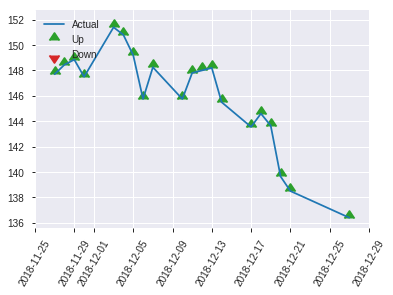


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25739939961981023
RMSE: 0.507345444071207
LogLoss: 0.7086457183666622
Mean Per-Class Error: 0.42917110874200426
AUC: 0.5638992537313433
pr_auc: 0.6048096307369114
Gini: 0.12779850746268662
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.276157021522522: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    134  0        (0.0/134.0)
Total  1    245  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.276157     0.707124  244
max f2                       0.276157     0.857875  244
max f0point5                 0.41396      0.609418  146
max accuracy                 0.424958     0.573171  130
max precision                0.615723     1         0
max recall                   0.276157     1         244
max specificity              0.615723     1         0
max absolute_mcc             0.539633     0.169138  11
max min_per_class_accuracy   0.426955     0.567164  123
max mean_per_class_accuracy  0.424958     0.570829  130

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 43.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.595483           1.22388   1.22388            0.666667         0.605923  0.666667                    0.605923            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   0.580834           1.83582   1.46866            1                0.592609  0.8                         0.600597            0.0149254       0.0298507                  83.5821    46.8657
    3        0.0325203                   0.560851           1.83582   1.60634            1                0.569698  0.875                       0.58901             0.0223881       0.0522388                  83.5821    60.6343
    4        0.0406504                   0.548564           1.83582   1.65224            1                0.554598  0.9                         0.582127            0.0149254       0.0671642                  83.5821    65.2239
    5        0.0528455                   0.538121           1.22388   1.55339            0.666667         0.542012  0.846154                    0.57287             0.0149254       0.0820896                  22.3881    55.3387
    6        0.101626                    0.514313           0.764925  1.17493            0.416667         0.526538  0.64                        0.550631            0.0373134       0.119403                   -23.5075   17.4925
    7        0.150407                    0.492529           1.22388   1.1908             0.666667         0.504336  0.648649                    0.535616            0.0597015       0.179104                   22.3881    19.0803
    8        0.203252                    0.483894           0.847302  1.10149            0.461538         0.487202  0.6                         0.523029            0.0447761       0.223881                   -15.2698   10.1493
    9        0.300813                    0.466242           0.994403  1.06676            0.541667         0.473908  0.581081                    0.507098            0.0970149       0.320896                   -0.559701  6.67608
    10       0.402439                    0.44309            1.39522   1.14971            0.76             0.455229  0.626263                    0.493999            0.141791        0.462687                   39.5224    14.9706
    11       0.5                         0.427121           0.994403  1.1194             0.541667         0.434931  0.609756                    0.482474            0.0970149       0.559701                   -0.559701  11.9403
    12       0.601626                    0.413798           0.954627  1.09157            0.52             0.420321  0.594595                    0.471975            0.0970149       0.656716                   -4.53731   9.15692
    13       0.699187                    0.397848           0.764925  1.04599            0.416667         0.405032  0.569767                    0.462634            0.0746269       0.731343                   -23.5075   4.5991
    14       0.800813                    0.381715           0.807761  1.01576            0.44             0.393127  0.553299                    0.453813            0.0820896       0.813433                   -19.2239   1.57588
    15       0.898374                    0.359798           0.91791   1.00513            0.5              0.369541  0.547511                    0.444662            0.0895522       0.902985                   -8.20896   0.513271
    16       1                           0.268704           0.954627  1                  0.52             0.330883  0.544715                    

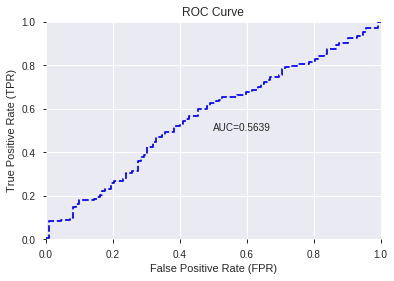

This function is available for GLM models only


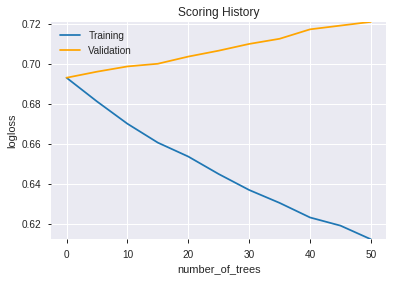

--2019-09-06 01:25:31--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.51
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.51|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_012515_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_012515_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'CORREL_14',
 'COS',
 'MFI_8',
 'CORREL_24',
 'day',
 'COSH',
 'SIN',
 'CORREL_20',
 'STOCHRSI_fastk',
 'CORREL_30',
 'EXP',
 'CDLINVERTEDHAMMER',
 'HT_TRENDMODE',
 'weekday_name',
 'CDLMATCHINGLOW',
 'SINH',
 'CDLHAMMER']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [1007] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190906_012551  0.506530  15.252970              0.494803  0.672955  0.452868
1  DeepLearning_grid_1_AutoML_20190906_012551_model_3  0.505597  18.121875              0.500000  0.735830  0.541446
2  DeepLearning_grid_1_AutoML_20190906_012551_model_4  0.503498  18.416022              0.500000  0.737861  0.544439
3  DeepLearning_grid_1_AutoML_20190906_012551_model_1  0.501333  15.508682              0.500000  0.676137  0.457161
4  DeepLearning_grid_1_AutoML_20190906_012551_model_9  0.500000   0.689202              0.500000  0.498026  0.248030
5  DeepLearning_grid_1_AutoML_20190906_012551_model_8  0.500000   0.690247              0.500000  0.498542  0.248544
6  DeepLearning_grid_1_AutoML_20190906_012551_model_5  0.500000   0.689257              0.500000  0.498053  0.248057
7  DeepLearning_grid_1_AutoML_20190906_012551_model_2  0.498534  18.338150              0.500000  0.735567  0.541059
8  DeepLearning_grid_1_AutoML_20190906_012551_model_6  0.497768   0.689250              0.500000  0.498049  0.248053
9  DeepLearning_grid_1_AutoML_20190906_012551_model_7  0.496835  15.085815              0.490338  0.669783  0.448609

variable  relative_importance  scaled_importance  percentage
0                          TAN             1.000000           1.000000    0.001770
1                  CDLPIERCING             0.892408           0.892408    0.001580
2                           AD             0.852252           0.852252    0.001509
3                          BOP             0.850997           0.850997    0.001507
4      BBANDS_upperband_30_1_5             0.847114           0.847114    0.001500
...                        ...                  ...                ...         ...
1036    BBANDS_upperband_8_6_2             0.266947           0.266947    0.000473
1037                  TRIMA_20             0.258458           0.258458    0.000458
1038  BBANDS_middleband_24_1_4             0.258301           0.258301    0.000457
1039                   MA_12_4             0.252017           0.252017    0.000446
1040                PLUS_DI_30             0.240531           0.240531    0.000426

[1041 rows x 4 columns]

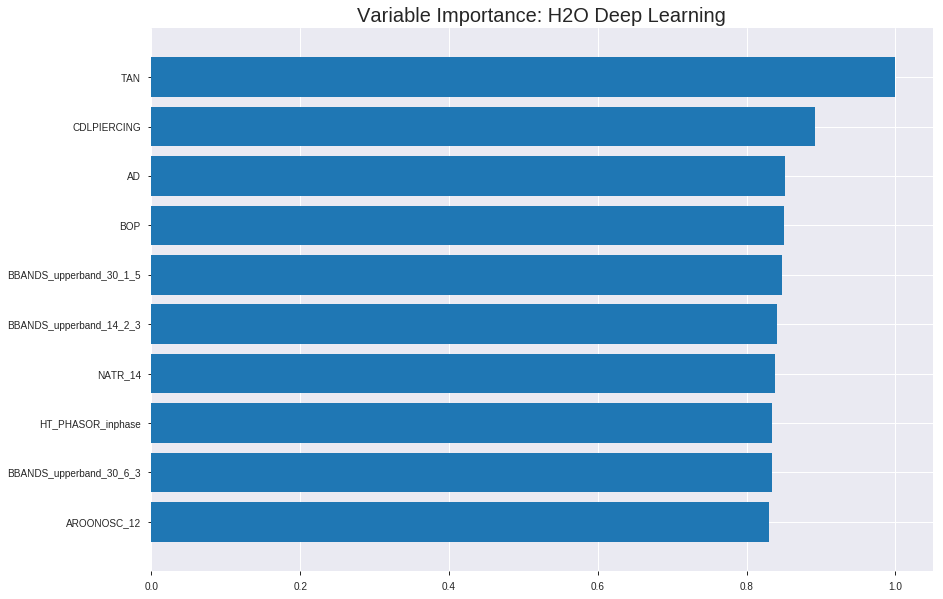

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190906_012551


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2503416054406842
RMSE: 0.5003414888260659
LogLoss: 0.7077983348536074
Mean Per-Class Error: 0.4202878281139151
AUC: 0.6171149623323536
pr_auc: 0.6401600201398056
Gini: 0.23422992466470727
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0444879716927132: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      19   806   0.977    (806.0/825.0)
1      1    896   0.0011   (1.0/897.0)
Total  20   1702  0.4686   (807.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.044488     0.689496  388
max f2                       0.044488     0.846881  388
max f0point5                 0.294913     0.602582  275
max accuracy                 0.483241     0.582462  183
max precision                0.999662     1         0
max recall                   0.0408459    1         390
max specificity              0.999662     1         0
max absolute_mcc             0.619275     0.194143  116
max min_per_class_accuracy   0.507033     0.521212  172
max mean_per_class_accuracy  0.483241     0.579712  183

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 45.26 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.99858            1.91973   1.91973            1                0.999604   1                           0.999604            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.993904           1.91973   1.91973            1                0.9965     1                           0.998096            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.978905           1.69388   1.8459             0.882353         0.987976   0.961538                    0.994788            0.0167224       0.0557414                  69.3882   84.5897
    4        0.0400697                   0.938907           1.58096   1.78062            0.823529         0.956966   0.927536                    0.985469            0.0156076       0.0713489                  58.0956   78.0621
    5        0.0505226                   0.883913           1.59978   1.74321            0.833333         0.90335    0.908046                    0.968479            0.0167224       0.0880713                  59.9777   74.3205
    6        0.100465                    0.692169           1.25006   1.49806            0.651163         0.773474   0.780347                    0.87154             0.0624303       0.150502                   25.0058   49.8057
    7        0.150407                    0.6156             1.33935   1.44536            0.697674         0.652579   0.752896                    0.798835            0.0668896       0.217391                   33.9348   44.5358
    8        0.200348                    0.565659           0.982189  1.3299             0.511628         0.589392   0.692754                    0.746626            0.0490524       0.266444                   -1.78113  32.9902
    9        0.555749                    0.507033           1.01319   1.12737            0.527778         0.51259    0.587252                    0.596961            0.360089        0.626533                   1.31921   12.7366
    10       0.599884                    0.442002           1.0609    1.12248            0.552632         0.472087   0.584705                    0.587773            0.0468227       0.673356                   6.09048   12.2477
    11       0.699768                    0.314653           0.859415  1.08493            0.447674         0.374108   0.565145                    0.557275            0.0858417       0.759197                   -14.0585  8.49276
    12       0.799652                    0.280641           1.00451   1.07488            0.523256         0.304106   0.559913                    0.525652            0.100334        0.859532                   0.451116  7.48829
    13       0.899535                    0.171407           0.691997  1.03237            0.360465         0.233111   0.537766                    0.493168            0.0691193       0.928651                   -30.8003  3.23674
    14       1                           0.0017103          0.71019   1                  0.369942         0.0896803  0.520906                    0.452632            0.0713489       1                          -28.981   0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.43252213579563675
RMSE: 0.6576641512167413
LogLoss: 5.913822021365356
Mean Per-Class Error: 0.49549549549549554
AUC: 0.4511094427761095
pr_auc: 0.3901287719687857
Gini: -0.09778111444778104
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.03302813098208481: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    220  0.991    (220.0/222.0)
1      0    270  0        (0.0/270.0)
Total  2    490  0.4472   (220.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0330281    0.710526  350
max f2                       0.0330281    0.859873  350
max f0point5                 0.0330281    0.605381  350
max accuracy                 0.0330281    0.552846  350
max precision                0.0330281    0.55102   350
max recall                   0.0330281    1         350
max specificity              1            0.68018   0
max absolute_mcc             0.285641     0.113827  204
max min_per_class_accuracy   0.454139     0.474074  104
max mean_per_class_accuracy  0.0330281    0.504505  350

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 54.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.278455                    1                  0.904461  0.904461           0.49635          1          0.49635                     1                   0.251852        0.251852                   -9.55393  -9.55393
    2        0.300813                    0.998096           0.828283  0.898799           0.454545         0.999591   0.493243                    0.99997             0.0185185       0.27037                    -17.1717  -10.1201
    3        0.400407                    0.784984           0.966893  0.915736           0.530612         0.934018   0.502538                    0.983565            0.0962963       0.366667                   -3.31066  -8.4264
    4        0.5                         0.44103            1.07846   0.948148           0.591837         0.597116   0.520325                    0.90659             0.107407        0.474074                   7.8458    -5.18519
    5        0.599593                    0.310334           1.11565   0.97597            0.612245         0.347871   0.535593                    0.813786            0.111111        0.585185                   11.5646   -2.40301
    6        0.699187                    0.284178           0.669388  0.9323             0.367347         0.307609   0.511628                    0.741685            0.0666667       0.651852                   -33.0612  -6.77003
    7        0.79878                     0.0758983          1.19002   0.964433           0.653061         0.161165   0.529262                    0.669305            0.118519        0.77037                    19.0023   -3.55669
    8        0.898374                    0.0450596          1.22721   0.993565           0.673469         0.0580423  0.545249                    0.60154             0.122222        0.892593                   22.7211   -0.643539
    9        1                           0.0310767          1.05689   1                  0.58             0.0389574  0.54878                     0.544367            0.107407        1                          5.68889   0


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:25:51  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 01:25:51  0.391 sec   7028 obs/sec      1         1             1722       0.5717           1.21307             -0.309653      0.556078        0.574552           1.91973          0.479094                         0.706075           7.14508               -1.01333         0.43642           0.383477             0.904461           0.45122
    2019-09-06 01:25:53  1.810 sec   10968 obs/sec     10        10            17220      0.500341         0.707798            -0.00312011    0.617115        0.64016            1.91973          0.468641                         0.657664           5.91382               -0.746714        0.451109          0.390129             0.904461           0.447154

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ----------------------
TAN                       1.0                    1.0                  0.001770334428457939
CDLPIERCING               0.8924083709716797     0.8924083709716797   0.0015798612633752289
AD                        0.8522524833679199     0.8522524833679199   0.0015087719130450056
BOP                       0.8509969711303711     0.8509969711303711   0.0015065492365055227
BBANDS_upperband_30_1_5   0.8471136689186096     0.8471136689186096   0.0014996744929039344
---                       ---                    ---                  ---
BBANDS_upperband_8_6_2    0.2669470012187958     0.2669470012187958   0.00047258546683123754
TRIMA_20                  0.25845757126808167    0.25845757126808167  0.00045755633671150635
BBANDS_middleband_24_1_4  0.2583012580871582     0.2583012580871582   0.0004572796101056958
MA_12_4                   0.25201717019081116    0.25201717019081116  0.0004461546729513368
PLUS_DI_30                0.24053123593330383    0.24053123593330383  0.00042582072809226707


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5487804878048781)

('F1', 0.7055702917771882)

('auc', 0.5065298507462687)

('logloss', 15.252969961727507)

('mean_per_class_error', 0.49333688699360334)

('rmse', 0.6729546041563491)

('mse', 0.4528678992552286)

deeplearning prediction progress: |███████████████████████████████████████| 100%


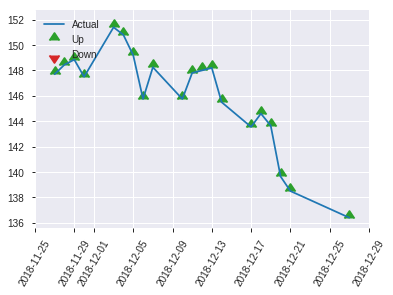


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4528678992552286
RMSE: 0.6729546041563491
LogLoss: 15.252969961727507
Mean Per-Class Error: 0.49333688699360334
AUC: 0.5065298507462687
pr_auc: 0.012199161375118086
Gini: 0.013059701492537323
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10992691702806816: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    133  0.0075   (1.0/134.0)
Total  3    243  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.109927     0.70557    4
max f2                       0.054926     0.856777   7
max f0point5                 0.109927     0.601266   4
max accuracy                 1            0.54878    0
max precision                1            0.548117   0
max recall                   0.054926     1          7
max specificity              1            0.0357143  0
max absolute_mcc             0.0731548    0.0584082  6
max min_per_class_accuracy   1            0.0357143  0
max mean_per_class_accuracy  1            0.506663   0

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 98.09 %



group    cumulative_data_fraction    lower_threshold    lift     cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  -------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.96748                     1                  1.00276  1.00276            0.546218         1         0.546218                    1                   0.970149        0.970149                   0.275931  0.275931
    2        1                           0.054926           0.91791  1                  0.5              0.411902  0.544715                    0.980875            0.0298507       1                          -8.20896  0

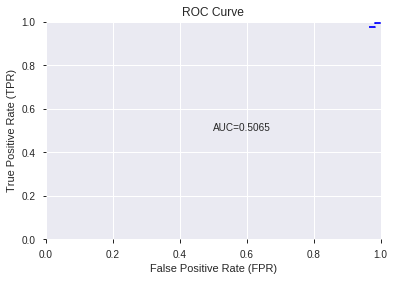

This function is available for GLM models only


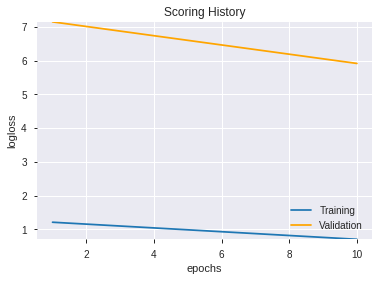

--2019-09-06 01:54:03--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.235
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.235|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190906_012551',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190906_012551',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_74_sid_9c46'

['TAN',
 'CDLPIERCING',
 'AD',
 'BOP',
 'BBANDS_upperband_30_1_5',
 'BBANDS_upperband_14_2_3',
 'NATR_14',
 'HT_PHASOR_inphase',
 'BBANDS_upperband_30_6_3',
 'AROONOSC_12',
 'BBANDS_upperband_14_5_4',
 'MAVP_30_6',
 'CDL3WHITESOLDIERS',
 'VAR_30',
 'BBANDS_lowerband_8_6_3',
 'MACD_hist',
 'CDLSTALLEDPATTERN',
 'BBANDS_lowerband_20_0_3',
 'CORREL_12',
 'BBANDS_lowerband_8_5_4',
 'CCI_20',
 'BBANDS_upperband_24_1_3',
 'BBANDS_lowerband_24_3_5',
 'BBANDS_lowerband_12_7_4',
 'MACDFIX_hist_20',
 'BBANDS_upperband_8_0_4',
 'RSI_30',
 'CDLEVENINGDOJISTAR',
 'mama',
 'BBANDS_upperband_14_7_3',
 'SQRT',
 'BBANDS_middleband_8_7_5',
 'HT_DCPERIOD',
 'DX_12',
 'CDLIDENTICAL3CROWS',
 'BBANDS_middleband_12_3_3',
 'MACDEXT_hist',
 'WILLR_24',
 'BBANDS_middleband_24_3_5',
 'CDL2CROWS',
 'CDLHARAMI',
 'VAR_8',
 'DEMA_14',
 'ROC_24',
 'PLUS_DM_14',
 'BBANDS_lowerband_24_3_4',
 'LINEARREG_ANGLE_20',
 'BBANDS_middleband_20_0_3',
 'TRIMA_12',
 'BBANDS_middleband_20_6_3',
 'BBANDS_upperband_8_1_5',
 'BBANDS

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_015409_model_1  0.516091  18.012633                   0.5  0.734418  0.539369

variable  relative_importance  scaled_importance    percentage
0                  CDLMARUBOZU         8.239579e-03           1.000000  1.186647e-02
1                          day         7.831062e-03           0.950420  1.127813e-02
2            CDLINVERTEDHAMMER         7.369514e-03           0.894404  1.061342e-02
3              CDLADVANCEBLOCK         6.615189e-03           0.802855  9.527054e-03
4             CDLSTICKSANDWICH         6.583865e-03           0.799054  9.481942e-03
...                        ...                  ...                ...           ...
1036   BBANDS_lowerband_20_0_2         7.036079e-07           0.000085  1.013321e-06
1037  BBANDS_middleband_24_2_5         5.389649e-07           0.000065  7.762058e-07
1038  BBANDS_middleband_20_2_3         2.691671e-07           0.000033  3.876487e-07
1039  BBANDS_middleband_14_4_3         3.063151e-08           0.000004  4.411484e-08
1040                    WMA_20         0.000000e+00           0.000000  0.000000e+00

[1041 rows x 4 columns]

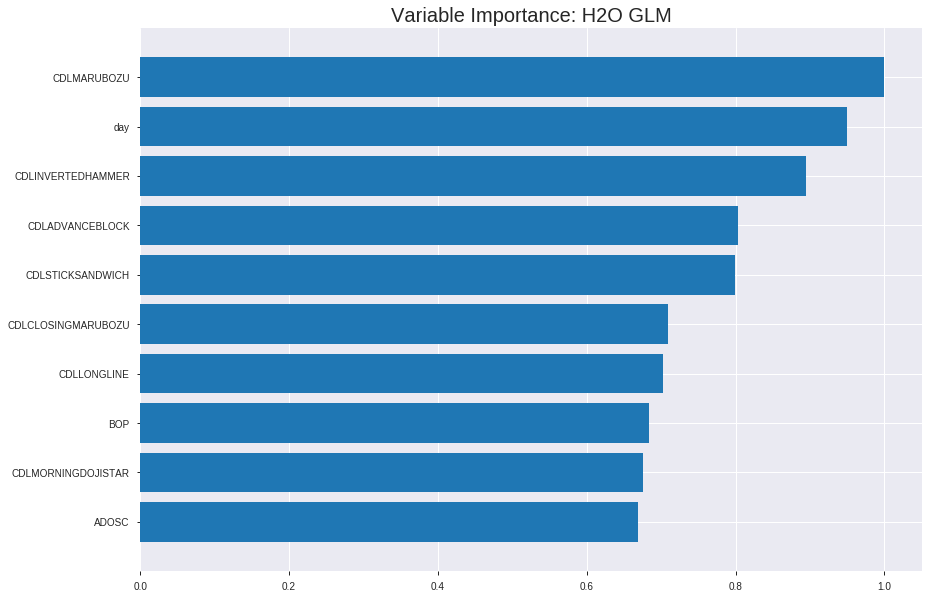

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_015409_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24530884815307233
RMSE: 0.4952866323181682
LogLoss: 0.6837205021818068
Null degrees of freedom: 1721
Residual degrees of freedom: 681
Null deviance: 2384.1875591118605
Residual deviance: 2354.7334095141423
AIC: 4436.733409514142
AUC: 0.6006351136785919
pr_auc: 0.6136432217408345
Gini: 0.2012702273571838
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44486081262517285: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      16   809   0.9806   (809.0/825.0)
1      4    893   0.0045   (4.0/897.0)
Total  20   1702  0.4721   (813.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.444861     0.687187  382
max f2                       0.420745     0.84511   396
max f0point5                 0.506481     0.599862  249
max accuracy                 0.521856     0.576655  192
max precision                0.610865     1         0
max recall                   0.420745     1         396
max specificity              0.610865     1         0
max absolute_mcc             0.531723     0.157765  153
max min_per_class_accuracy   0.523895     0.574136  185
max mean_per_class_accuracy  0.531113     0.576878  155

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.010453                    0.579207           1.59978   1.59978            0.833333         0.588525  0.833333                    0.588525            0.0167224       0.0167224                  59.9777    59.9777
    2        0.0203252                   0.574221           1.35511   1.48094            0.705882         0.576487  0.771429                    0.582678            0.0133779       0.0301003                  35.5105    48.0936
    3        0.0301974                   0.570245           1.01633   1.32905            0.529412         0.571993  0.692308                    0.579185            0.0100334       0.0401338                  1.63289    32.9046
    4        0.0400697                   0.567819           1.35511   1.33547            0.705882         0.56916   0.695652                    0.576715            0.0133779       0.0535117                  35.5105    33.5466
    5        0.0505226                   0.565462           1.27982   1.32395            0.666667         0.566509  0.689655                    0.574603            0.0133779       0.0668896                  27.9822    32.3953
    6        0.100465                    0.556401           1.38399   1.3538             0.72093          0.560002  0.705202                    0.567345            0.0691193       0.136009                   38.3993    35.38
    7        0.150407                    0.549732           1.20541   1.30453            0.627907         0.552474  0.679537                    0.562407            0.0602007       0.19621                    20.5413    30.4529
    8        0.200348                    0.544353           1.07148   1.24643            0.55814          0.546678  0.649275                    0.558486            0.0535117       0.249721                   7.14786    24.6435
    9        0.300232                    0.536888           1.07148   1.18823            0.55814          0.540161  0.618956                    0.55239             0.107023        0.356745                   7.14786    18.8229
    10       0.400116                    0.530324           1.14961   1.17859            0.598837         0.533551  0.613933                    0.547687            0.114827        0.471572                   14.9607    17.8588
    11       0.5                         0.523922           0.982189  1.13935            0.511628         0.527206  0.593496                    0.543595            0.0981048       0.569677                   -1.78113   13.9353
    12       0.599884                    0.516406           0.915221  1.10203            0.476744         0.520264  0.574056                    0.539711            0.0914158       0.661093                   -8.47787   10.2034
    13       0.699768                    0.506968           0.99335   1.08652            0.517442         0.511947  0.565975                    0.535748            0.0992196       0.760312                   -0.665007  8.65208
    14       0.799652                    0.496912           0.870576  1.05955            0.453488         0.502561  0.551924                    0.531602            0.0869565       0.847269                   -12.9424   5.95473
    15       0.899535                    0.482824           0.736642  1.02369            0.383721         0.491063  0.533247                    0.527101            0.0735786       0.920847                   -26.3358   2.36921
    16       1                           0.358984           0.787867  1                  0.410405         0.465438  0.520906                    0.



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3258180060873113
RMSE: 0.57080470047759
LogLoss: 5.18089772684513
Null degrees of freedom: 491
Residual degrees of freedom: -549
Null deviance: 678.9014289835272
Residual deviance: 78070.53307663453
AIC: 80152.53307663453
AUC: 0.5221054387721055
pr_auc: 0.547821766160608
Gini: 0.044210877544210936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.6321538271720637e-49: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    270  0        (0.0/270.0)
Total  0    492  0.4512   (222.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       2.63215e-49  0.708661   371
max f2                       2.63215e-49  0.858779   371
max f0point5                 2.63215e-49  0.603217   371
max accuracy                 0.286461     0.556911   341
max precision                0.286461     0.576023   341
max recall                   2.63215e-49  1          371
max specificity              0.546586     0.995495   0
max absolute_mcc             0.286461     0.0826661  341
max min_per_class_accuracy   0.472468     0.513514   246
max mean_per_class_accuracy  0.286461     0.538238   341

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 33.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.536769           0.728889  0.728889           0.4              0.542725    0.4                         0.542725            0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.534717           0.364444  0.546667           0.2              0.53582     0.3                         0.539273            0.0037037       0.0111111                  -63.5556  -45.3333
    3        0.0304878                   0.533415           1.45778   0.85037            0.8              0.53421     0.466667                    0.537585            0.0148148       0.0259259                  45.7778   -14.963
    4        0.0406504                   0.53244            0.364444  0.728889           0.2              0.532958    0.4                         0.536428            0.0037037       0.0296296                  -63.5556  -27.1111
    5        0.050813                    0.530164           1.09333   0.801778           0.6              0.531633    0.44                        0.535469            0.0111111       0.0407407                  9.33333   -19.8222
    6        0.101626                    0.520233           0.947556  0.874667           0.52             0.525675    0.48                        0.530572            0.0481481       0.0888889                  -5.24444  -12.5333
    7        0.150407                    0.509911           1.21481   0.984985           0.666667         0.514138    0.540541                    0.525242            0.0592593       0.148148                   21.4815   -1.5015
    8        0.20122                     0.504005           1.09333   1.01235            0.6              0.506267    0.555556                    0.52045             0.0555556       0.203704                   9.33333   1.23457
    9        0.300813                    0.494452           1.00408   1.00961            0.55102          0.499058    0.554054                    0.513368            0.1             0.303704                   0.408163  0.960961
    10       0.400407                    0.484044           1.07846   1.02673            0.591837         0.488927    0.563452                    0.507288            0.107407        0.411111                   7.8458    2.67343
    11       0.5                         0.472496           1.00408   1.02222            0.55102          0.478008    0.560976                    0.501456            0.1             0.511111                   0.408163  2.22222
    12       0.599593                    0.457048           1.00408   1.01921            0.55102          0.465321    0.559322                    0.495454            0.1             0.611111                   0.408163  1.9209
    13       0.699187                    0.159133           1.22721   1.04884            0.673469         0.404413    0.575581                    0.482486            0.122222        0.733333                   22.7211   4.88372
    14       1                           0                  0.886486  1                  0.486486         0.00443408  0.54878                     0.338682            0.266667        1                          -11.3514  0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 01:54:13  0.000 sec   2            3.6       1041          1.36744           158.68
    2019-09-06 01:54:14  1.874 sec   4            2.6       1041          1.36353           162.324
    2019-09-06 01:54:16  3.731 sec   6            1.9       1041          1.35896           165.546
    2019-09-06 01:54:18  5.598 sec   8            1.4       1041          1.35364           169.115
    2019-09-06 01:54:20  7.490 sec   10           1         1041          1.34759           171.948

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5447154471544715)

('F1', 0.7052631578947368)

('auc', 0.5160914179104478)

('logloss', 18.0126331734885)

('mean_per_class_error', 0.48274253731343286)

('rmse', 0.7344177577545223)

('mse', 0.5393694429051803)

glm prediction progress: |████████████████████████████████████████████████| 100%


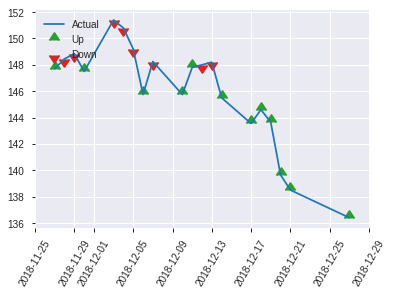


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.5393694429051803
RMSE: 0.7344177577545223
LogLoss: 18.0126331734885
Null degrees of freedom: 245
Residual degrees of freedom: -795
Null deviance: 339.6180594432119
Residual deviance: 164962.55670029204
AIC: 167044.55670029204
AUC: 0.5160914179104478
pr_auc: 0.5884703832967476
Gini: 0.03218283582089554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 7.033272722327694e-50: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    112  1        (112.0/112.0)
1      0    134  0        (0.0/134.0)
Total  0    246  0.4553   (112.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       7.03327e-50  0.705263   20
max f2                       7.03327e-50  0.856777   20
max f0point5                 7.03327e-50  0.599284   20
max accuracy                 7.03327e-50  0.544715   20
max precision                0.493454     1          0
max recall                   7.03327e-50  1          20
max specificity              0.493454     1          0
max absolute_mcc             4.67155e-43  0.0628925  19
max min_per_class_accuracy   4.67155e-43  0.0970149  19
max mean_per_class_accuracy  4.67155e-43  0.517257   19

Gains/Lift Table: Avg response rate: 54.47 %, avg score:  0.93 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.484865           0.61194   0.61194            0.333333         0.490031     0.333333                    0.490031            0.00746269      0.00746269                 -38.806   -38.806
    2        0.0203252                   0.153206           1.83582   1.10149            1                0.331312     0.6                         0.426543            0.0149254       0.0223881                  83.5821   10.1493
    3        0.0325203                   0.00378823         0.61194   0.91791            0.333333         0.0557713    0.5                         0.287504            0.00746269      0.0298507                  -38.806   -8.20896
    4        0.0406504                   1.82997e-06        0.91791   0.91791            0.5              1.24035e-05  0.5                         0.230006            0.00746269      0.0373134                  -8.20896  -8.20896
    5        0.0528455                   1.71687e-13        1.83582   1.12974            1                5.7134e-07   0.615385                    0.176928            0.0223881       0.0597015                  83.5821   12.9736
    6        0.101626                    2.18974e-74        1.22388   1.17493            0.666667         1.4282e-14   0.64                        0.0920023           0.0597015       0.119403                   22.3881   17.4925
    7        0.150407                    3.40416e-270       0.91791   1.09157            0.5              7.66619e-79  0.594595                    0.0621637           0.0447761       0.164179                   -8.20896  9.15692
    8        1                           0                  0.983789  1                  0.535885         0            0.544715                    0.00934983          0.835821        1                          -1.62108  0

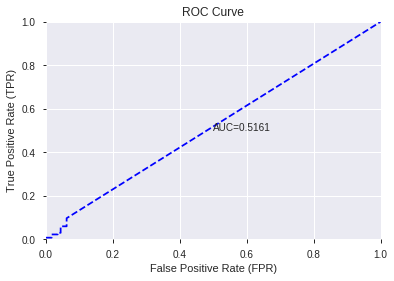

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


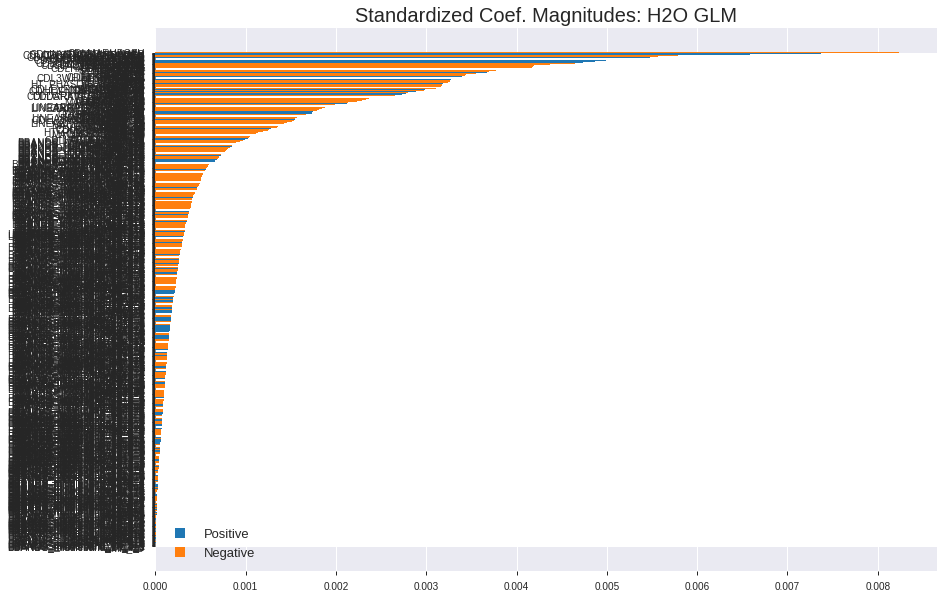

'log_likelihood'
--2019-09-06 01:54:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.85.227
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.85.227|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_015409_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_015409_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLMARUBOZU',
 'day',
 'CDLINVERTEDHAMMER',
 'CDLADVANCEBLOCK',
 'CDLSTICKSANDWICH',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'BOP',
 'CDLMORNINGDOJISTAR',
 'ADOSC',
 'CDLUNIQUE3RIVER',
 'DX_8',
 'STOCHF_fastk',
 'CDLMATCHINGLOW',
 'CDL3OUTSIDE',
 'CDLSTALLEDPATTERN',
 'SUB',
 'COS',
 'CDLHIKKAKE',
 'CDL3INSIDE',
 'CDLCOUNTERATTACK',
 'HT_TRENDMODE',
 'CDLEVENINGSTAR',
 'month',
 'PLUS_DM_30',
 'CDLLADDERBOTTOM',
 'CDLDOJISTAR',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'CDLHARAMICROSS',
 'CDLHAMMER',
 'PLUS_DM_24',
 'dayofyear',
 'is_quarter_end',
 'quarter',
 'TAN',
 'DIV',
 'PLUS_DM_20',
 'weekofyear',
 'week',
 'DX_12',
 'TRANGE',
 'WILLR_8',
 'MFI_8',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'CDLTHRUSTING',
 'aroondown_8',
 'BETA_24',
 'CDL3WHITESOLDIERS',
 'PLUS_DM_14',
 'dayofweek',
 'weekday',
 'CDL2CROWS',
 'SIN',
 'COSH',
 'PLUS_DM_12',
 'EXP',
 'SINH',
 'ATR_8',
 'ULTOSC',
 'HT_PHASOR_quadrature',
 'DX_14',
 'BETA_8',
 'ROC_14',
 'PLUS_DM_8',
 'ROCP_14',
 'RO

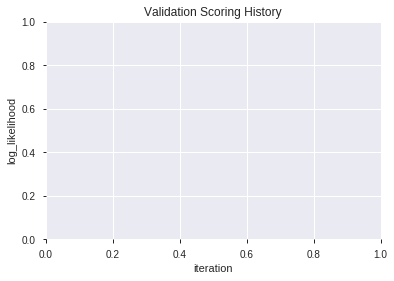

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190906_015452  0.511727  0.723480              0.494803  0.514235  0.264438
1  XGBoost_grid_1_AutoML_20190906_015452_model_4  0.507862  0.715198              0.479211  0.510630  0.260743
2  XGBoost_grid_1_AutoML_20190906_015452_model_3  0.503931  0.773541              0.500000  0.535416  0.286671
3               XGBoost_2_AutoML_20190906_015452  0.503531  0.732243              0.491071  0.518048  0.268373
4  XGBoost_grid_1_AutoML_20190906_015452_model_1  0.494869  0.723652              0.500000  0.514446  0.264655
5  XGBoost_grid_1_AutoML_20190906_015452_model_6  0.493337  0.738963              0.500000  0.521214  0.271664
6  XGBoost_grid_1_AutoML_20190906_015452_model_5  0.479811  0.762701              0.484408  0.530512  0.281443
7  XGBoost_grid_1_AutoML_20190906_015452_model_2  0.470682  0.715744              0.494803  0.510944  0.261064
8  XGBoost_grid_1_AutoML_20190906_015452_model_7  0.470149  0.767915              0.500000  0.533025  0.284116
9               XGBoost_1_AutoML_20190906_015452  0.457023  0.749250              0.495536  0.525825  0.276492

variable  relative_importance  scaled_importance  percentage
0                        BOP           154.871231           1.000000    0.028682
1                        TAN           128.804214           0.831686    0.023854
2                     Volume           120.421814           0.777561    0.022302
3               STOCHF_fastk           107.281723           0.692716    0.019868
4                    BETA_12           101.221802           0.653587    0.018746
..                       ...                  ...                ...         ...
269                STDDEV_12             1.452765           0.009380    0.000269
270  BBANDS_lowerband_12_2_4             1.301411           0.008403    0.000241
271               ROCR100_30             0.963871           0.006224    0.000179
272                 SAR_0.24             0.665663           0.004298    0.000123
273             aroondown_12             0.410009           0.002647    0.000076

[274 rows x 4 columns]

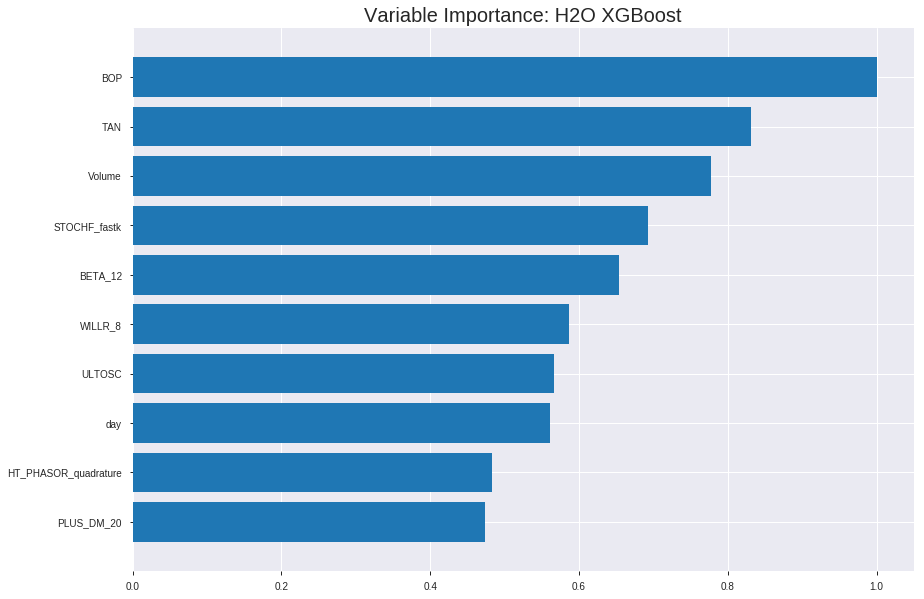

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190906_015452


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1777046198322853
RMSE: 0.4215502577775102
LogLoss: 0.5443761729515662
Mean Per-Class Error: 0.12121414817066989
AUC: 0.9542805986284247
pr_auc: 0.9576827440225275
Gini: 0.9085611972568495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4943275849024455: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      644  181   0.2194   (181.0/825.0)
1      47   850   0.0524   (47.0/897.0)
Total  691  1031  0.1324   (228.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.494328     0.881743  211
max f2                       0.465154     0.929595  237
max f0point5                 0.556938     0.905344  152
max accuracy                 0.525284     0.878049  181
max precision                0.756413     1         0
max recall                   0.367982     1         325
max specificity              0.756413     1         0
max absolute_mcc             0.534092     0.757282  174
max min_per_class_accuracy   0.521494     0.871795  185
max mean_per_class_accuracy  0.534092     0.878786  174

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.70 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.725884           1.91973    1.91973            1                0.74218   1                           0.74218             0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.707474           1.91973    1.91973            1                0.715267  1                           0.729108            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.697204           1.91973    1.91973            1                0.702532  1                           0.72042             0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.688667           1.91973    1.91973            1                0.693226  1                           0.71372             0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.678418           1.91973    1.91973            1                0.683397  1                           0.707446            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.651276           1.91973    1.91973            1                0.66506   1                           0.686375            0.0958751       0.192865                   91.9732   91.9732
    7        0.150407                    0.631645           1.91973    1.91973            1                0.641011  1                           0.671313            0.0958751       0.28874                    91.9732   91.9732
    8        0.200348                    0.617449           1.83044    1.89747            0.953488         0.624625  0.988406                    0.659674            0.0914158       0.380156                   83.0443   89.7475
    9        0.300232                    0.589413           1.85277    1.8826             0.965116         0.603822  0.980658                    0.641093            0.185061        0.565217                   85.2765   88.26
    10       0.400116                    0.561656           1.68535    1.83336            0.877907         0.575468  0.955007                    0.624711            0.168339        0.733556                   68.5347   83.3358
    11       0.5                         0.52552            1.2947     1.72575            0.674419         0.544499  0.898955                    0.608687            0.12932         0.862876                   29.4703   72.5753
    12       0.599884                    0.493294           0.848254   1.57964            0.44186          0.509708  0.822846                    0.592207            0.0847269       0.947603                   -15.1746  57.9644
    13       0.699768                    0.457885           0.390643   1.40993            0.203488         0.474639  0.73444                     0.575425            0.039019        0.986622                   -60.9357  40.9928
    14       0.799652                    0.417014           0.111612   1.24776            0.0581395        0.438062  0.649964                    0.558267            0.0111483       0.99777                    -88.8388  24.7756
    15       0.899535                    0.369082           0.0111612  1.11045            0.00581395       0.391714  0.578438                    0.539773            0.00111483      0.998885                   -98.8839  11.0446
    16       1                           0.162345           0.0110967  1                  0.00578035       0.313359  0.520906                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.26130970876712023
RMSE: 0.5111846131948029
LogLoss: 0.7166948179189774
Mean Per-Class Error: 0.4696696696696696
AUC: 0.5142809476142809
pr_auc: 0.5506073566405771
Gini: 0.028561895228561784
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3017893433570862: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      12   210  0.9459   (210.0/222.0)
1      5    265  0.0185   (5.0/270.0)
Total  17   475  0.437    (215.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.301789     0.711409   382
max f2                       0.247323     0.859325   398
max f0point5                 0.34424      0.610948   356
max accuracy                 0.353219     0.565041   348
max precision                0.679543     0.666667   2
max recall                   0.247323     1          398
max specificity              0.73976      0.995495   0
max absolute_mcc             0.301789     0.0968166  382
max min_per_class_accuracy   0.452783     0.525926   203
max mean_per_class_accuracy  0.454928     0.53033    197

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 46.02 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.665015           0.728889  0.728889           0.4              0.6907    0.4                         0.6907              0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.651502           1.45778   1.09333            0.8              0.658842  0.6                         0.674771            0.0148148       0.0222222                  45.7778   9.33333
    3        0.0304878                   0.635829           1.09333   1.09333            0.6              0.64333   0.6                         0.664291            0.0111111       0.0333333                  9.33333   9.33333
    4        0.0406504                   0.626022           1.45778   1.18444            0.8              0.632046  0.65                        0.656229            0.0148148       0.0481481                  45.7778   18.4444
    5        0.050813                    0.619107           0.364444  1.02044            0.2              0.622019  0.56                        0.649387            0.0037037       0.0518519                  -63.5556  2.04444
    6        0.101626                    0.58089            0.728889  0.874667           0.4              0.596969  0.48                        0.623178            0.037037        0.0888889                  -27.1111  -12.5333
    7        0.150407                    0.552012           1.13889   0.96036            0.625            0.564907  0.527027                    0.604279            0.0555556       0.144444                   13.8889   -3.96396
    8        0.20122                     0.535375           0.947556  0.957127           0.52             0.544128  0.525253                    0.58909             0.0481481       0.192593                   -5.24444  -4.28732
    9        0.300813                    0.508339           1.00408   0.972673           0.55102          0.522774  0.533784                    0.567134            0.1             0.292593                   0.408163  -2.73273
    10       0.400407                    0.477314           1.30159   1.05448            0.714286         0.492064  0.57868                     0.548462            0.12963         0.422222                   30.1587   5.44839
    11       0.5                         0.452783           1.00408   1.04444            0.55102          0.465252  0.573171                    0.531887            0.1             0.522222                   0.408163  4.44444
    12       0.599593                    0.436303           0.855329  1.01303            0.469388         0.444259  0.555932                    0.517332            0.0851852       0.607407                   -14.4671  1.3032
    13       0.699187                    0.411991           1.07846   1.02235            0.591837         0.42324   0.561047                    0.50393             0.107407        0.714815                   7.8458    2.23514
    14       0.79878                     0.382819           0.818141  0.99689            0.44898          0.39854   0.547074                    0.490789            0.0814815       0.796296                   -18.1859  -0.310998
    15       0.898374                    0.344587           1.22721   1.02242            0.673469         0.368305  0.561086                    0.477211            0.122222        0.918519                   22.7211   2.24233
    16       1                           0.209481           0.801778  1                  0.44             0.30941   0.54878                     0.460158   


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 01:55:02  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.45122
    2019-09-06 01:55:02  0.569 sec   5                  0.489463         0.672256            0.781815        0.77933            1.81308          0.304297                         0.502527           0.698226              0.49351           0.526049             0.728889           0.45122
    2019-09-06 01:55:02  0.746 sec   10                 0.481077         0.655856            0.830391        0.830992           1.91973          0.256098                         0.503362           0.699931              0.507441          0.537688             0.728889           0.445122
    2019-09-06 01:55:03  0.925 sec   15                 0.473024         0.640275            0.861343        0.863044           1.91973          0.229965                         0.502978           0.699167              0.515707          0.546032             0.728889           0.45122
    2019-09-06 01:55:03  1.115 sec   20                 0.463751         0.622528            0.885117        0.885828           1.91973          0.196283                         0.503832           0.70093               0.516275          0.544099             0.728889           0.449187
    2019-09-06 01:55:03  1.297 sec   25                 0.45831          0.612107            0.892858        0.896927           1.91973          0.188153                         0.506263           0.705988              0.506849          0.537756             1.09333            0.45122
    2019-09-06 01:55:03  1.478 sec   30                 0.450851         0.598082            0.909737        0.914174           1.91973          0.180023                         0.506794           0.707154              0.510018          0.540972             0.728889           0.45122
    2019-09-06 01:55:03  1.673 sec   35                 0.441495         0.5807              0.9272          0.931134           1.91973          0.152729                         0.507151           0.707998              0.5168            0.549387             1.09333            0.45122
    2019-09-06 01:55:04  1.862 sec   40                 0.433489         0.566097            0.941321        0.945011           1.91973          0.138792                         0.508459           0.710858              0.522981          0.552256             1.09333            0.45122
    2019-09-06 01:55:04  2.062 sec   45                 0.427545         0.555182            0.947616        0.951211           1.91973          0.136469                         0.510123           0.714391              0.519461          0.550651             0.728889           0.449187
    2019-09-06 01:55:04  2.258 sec   50                 0.42155          0.544376            0.954281        0.957683           1.91973          0.132404                         0.511185           0.716695              0.514281          0.550607             0.728889           0.436992

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      154.87123107910156     1.0                    0.028681761326969753
TAN                      128.80421447753906     0.8316858694805067     0.02385421560745321
Volume                   120.42181396484375     0.7775609009225055     0.02230181617744288
STOCHF_fastk             107.28172302246094     0.6927156339815369     0.019868304481318978
BETA_12                  101.2218017578125      0.6535868608554726     0.018746022349500055
---                      ---                    ---                    ---
STDDEV_12                1.4527645111083984     0.009380467250023916   0.0002690483228006423
BBANDS_lowerband_12_2_4  1.3014106750488281     0.00840317898928642    0.00024101797415852
ROCR100_30               0.9638710021972656     0.006223693035054146   0.00017850647820374702
SAR_0.24                 0.6656627655029297     0.004298169265297166   0.00012327906501017027
aroondown_12             0.41000938415527344    0.0026474212240610285  7.593270368047252e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5487804878048781)

('F1', 0.7055702917771882)

('auc', 0.511727078891258)

('logloss', 0.7234803391836486)

('mean_per_class_error', 0.4600879530916845)

('rmse', 0.5142353280884111)

('mse', 0.26443797265419583)

xgboost prediction progress: |████████████████████████████████████████████| 100%


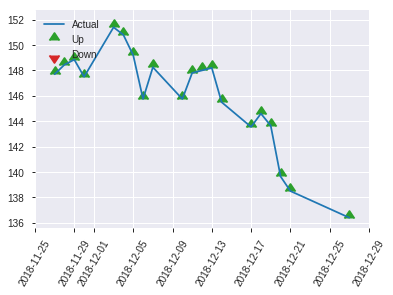


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26443797265419583
RMSE: 0.5142353280884111
LogLoss: 0.7234803391836486
Mean Per-Class Error: 0.4600879530916845
AUC: 0.511727078891258
pr_auc: 0.5668179062432257
Gini: 0.023454157782516027
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2772051990032196: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    133  0.0075   (1.0/134.0)
Total  3    243  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.277205     0.70557   242
max f2                       0.24218      0.856777  245
max f0point5                 0.277205     0.601266  242
max accuracy                 0.312919     0.54878   232
max precision                0.625259     1         0
max recall                   0.24218      1         245
max specificity              0.625259     1         0
max absolute_mcc             0.569491     0.117538  3
max min_per_class_accuracy   0.427794     0.507463  121
max mean_per_class_accuracy  0.47229      0.539912  69

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 42.89 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.571113           1.83582   1.83582            1                0.591734  1                           0.591734            0.0223881       0.0223881                  83.5821    83.5821
    2        0.0203252                   0.555711           0.91791   1.46866            0.5              0.562753  0.8                         0.580141            0.00746269      0.0298507                  -8.20896   46.8657
    3        0.0325203                   0.550805           0.61194   1.14739            0.333333         0.552866  0.625                       0.569913            0.00746269      0.0373134                  -38.806    14.7388
    4        0.0406504                   0.542825           0.91791   1.10149            0.5              0.54899   0.6                         0.565729            0.00746269      0.0447761                  -8.20896   10.1493
    5        0.0528455                   0.539819           1.22388   1.12974            0.666667         0.540921  0.615385                    0.560004            0.0149254       0.0597015                  22.3881    12.9736
    6        0.101626                    0.519829           0.91791   1.02806            0.5              0.526483  0.56                        0.543914            0.0447761       0.104478                   -8.20896   2.80597
    7        0.150407                    0.507931           1.0709    1.04195            0.583333         0.51413   0.567568                    0.534254            0.0522388       0.156716                   7.08955    4.19524
    8        0.203252                    0.492652           1.27095   1.10149            0.692308         0.500875  0.6                         0.525576            0.0671642       0.223881                   27.0953    10.1493
    9        0.300813                    0.468926           1.0709    1.09157            0.583333         0.479463  0.594595                    0.51062             0.104478        0.328358                   7.08955    9.15692
    10       0.402439                    0.449961           0.881194  1.03844            0.48             0.458582  0.565657                    0.497479            0.0895522       0.41791                    -11.8806   3.84441
    11       0.5                         0.427169           0.91791   1.01493            0.5              0.437429  0.552846                    0.485762            0.0895522       0.507463                   -8.20896   1.49254
    12       0.601626                    0.411027           0.954627  1.00474            0.52             0.41954   0.547297                    0.474576            0.0970149       0.604478                   -4.53731   0.473981
    13       0.699187                    0.394975           0.841418  0.981951           0.458333         0.402099  0.534884                    0.464463            0.0820896       0.686567                   -15.8582   -1.80493
    14       0.800813                    0.369709           1.17493   1.00644            0.64             0.382295  0.548223                    0.454035            0.119403        0.80597                    17.4925    0.643988
    15       0.898374                    0.335846           0.994403  1.00513            0.541667         0.351608  0.547511                    0.442912            0.0970149       0.902985                   -0.559701  0.513271
    16       1                           0.24218            0.954627  1                  0.52             0.305294  0.544715                

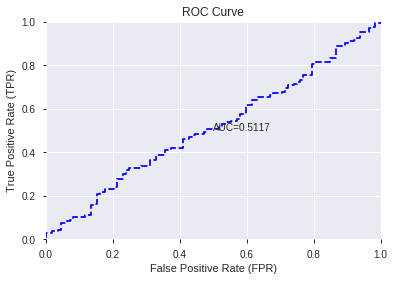

This function is available for GLM models only


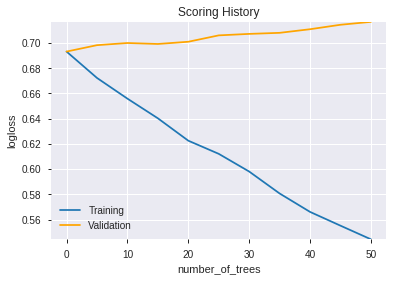

--2019-09-06 01:55:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.39.28
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.39.28|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.jav

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190906_015452',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190906_015452',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_90_sid_9c46',
   'type

['BOP',
 'TAN',
 'Volume',
 'STOCHF_fastk',
 'BETA_12',
 'WILLR_8',
 'ULTOSC',
 'day',
 'HT_PHASOR_quadrature',
 'PLUS_DM_20',
 'MFI_14',
 'BETA_30',
 'SIN',
 'dayofyear',
 'MFI_30',
 'CCI_8',
 'CORREL_30',
 'TRANGE',
 'PLUS_DI_14',
 'BETA_8',
 'MOM_14',
 'LINEARREG_ANGLE_12',
 'HT_PHASOR_inphase',
 'STDDEV_8',
 'MINUS_DM_8',
 'MINUS_DI_30',
 'CORREL_12',
 'ADX_20',
 'NATR_8',
 'OBV',
 'CCI_14',
 'WILLR_30',
 'BETA_24',
 'ROC_12',
 'ADOSC',
 'STOCH_slowk',
 'AD',
 'ADX_24',
 'STDDEV_14',
 'STOCHRSI_fastd',
 'PLUS_DM_14',
 'STOCHF_fastd',
 'SUB',
 'CCI_20',
 'ADXR_8',
 'MOM_12',
 'MACDEXT_hist',
 'STOCH_slowd',
 'PLUS_DI_8',
 'WILLR_14',
 'MFI_8',
 'COS',
 'STDDEV_20',
 'PLUS_DM_8',
 'DX_30',
 'VAR_12',
 'HT_DCPERIOD',
 'VAR_14',
 'CORREL_14',
 'ADXR_14',
 'PLUS_DM_30',
 'ROC_24',
 'DX_8',
 'aroondown_30',
 'MOM_30',
 'STDDEV_24',
 'DX_14',
 'WILLR_12',
 'CMO_30',
 'MINUS_DM_20',
 'MACDFIX_signal_24',
 'PLUS_DI_24',
 'AROONOSC_14',
 'BBANDS_upperband_24_3_5',
 'SAR_0.08',
 'ADX_14',
 'B

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

559

['BBANDS_middleband_12_4_4',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_upperband_12_4_5',
 'BBANDS_middleband_12_4_5',
 'BBANDS_lowerband_12_4_5',
 'MA_12_5',
 'MAVP_12_5',
 'BBANDS_upperband_12_5_2',
 'BBANDS_middleband_12_5_2',
 'BBANDS_lowerband_12_5_2',
 'BBANDS_upperband_12_5_3',
 'BBANDS_middleband_12_5_3',
 'BBANDS_lowerband_12_5_3',
 'BBANDS_upperband_12_5_4',
 'BBANDS_middleband_12_5_4',
 'BBANDS_lowerband_12_5_4',
 'BBANDS_upperband_12_5_5',
 'BBANDS_middleband_12_5_5',
 'BBANDS_lowerband_12_5_5',
 'MA_12_6',
 'MAVP_12_6',
 'BBANDS_upperband_12_6_2',
 'BBANDS_middleband_12_6_2',
 'BBANDS_lowerband_12_6_2',
 'BBANDS_upperband_12_6_3',
 'BBANDS_middleband_12_6_3',
 'BBANDS_lowerband_12_6_3',
 'BBANDS_upperband_12_6_4',
 'BBANDS_middleband_12_6_4',
 'BBANDS_lowerband_12_6_4',
 'BBANDS_upperband_12_6_5',
 'BBANDS_middleband_12_6_5',
 'BBANDS_lowerband_12_6_5',
 'MA_12_7',
 'MAVP_12_7',
 'BBANDS_upperband_12_7_2',
 'BBANDS_middleband_12_7_2',
 'BBANDS_lowerband_12_7_2',
 'BBANDS_upperb

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190906_015651_model_4  0.528785  0.898187              0.494803  0.557226  0.310501
1  DeepLearning_grid_1_AutoML_20190906_015651_model_5  0.500000  0.689970              0.500000  0.498406  0.248408
2  DeepLearning_grid_1_AutoML_20190906_015651_model_9  0.500000  0.689151              0.500000  0.498001  0.248005
3  DeepLearning_grid_1_AutoML_20190906_015651_model_7  0.500000  0.689148              0.500000  0.497999  0.248003
4  DeepLearning_grid_1_AutoML_20190906_015651_model_8  0.500000  0.689304              0.500000  0.498077  0.248081
5               DeepLearning_1_AutoML_20190906_015651  0.499800  0.698664              0.474014  0.502636  0.252643
6  DeepLearning_grid_1_AutoML_20190906_015651_model_1  0.498534  3.763519              0.500000  0.656521  0.431019
7  DeepLearning_grid_1_AutoML_20190906_015651_model_6  0.482143  0.689237              0.500000  0.498044  0.248047
8  DeepLearning_grid_1_AutoML_20190906_015651_model_3  0.474414  1.236885              0.489606  0.614888  0.378087
9  DeepLearning_grid_1_AutoML_20190906_015651_model_2  0.467817  1.066468              0.500000  0.604934  0.365945

variable  relative_importance  scaled_importance  percentage
0          CDLIDENTICAL3CROWS             1.000000           1.000000    0.003777
1          CDLEVENINGDOJISTAR             0.969517           0.969517    0.003662
2             CDLUNIQUE3RIVER             0.967560           0.967560    0.003655
3             CDLLADDERBOTTOM             0.966412           0.966412    0.003650
4                   CDL2CROWS             0.961456           0.961456    0.003632
..                        ...                  ...                ...         ...
554   BBANDS_upperband_30_0_2             0.415746           0.415746    0.001570
555   BBANDS_lowerband_30_6_3             0.409929           0.409929    0.001548
556   BBANDS_upperband_20_0_2             0.409871           0.409871    0.001548
557  BBANDS_middleband_30_7_4             0.408404           0.408404    0.001543
558  BBANDS_middleband_30_7_5             0.407118           0.407118    0.001538

[559 rows x 4 columns]

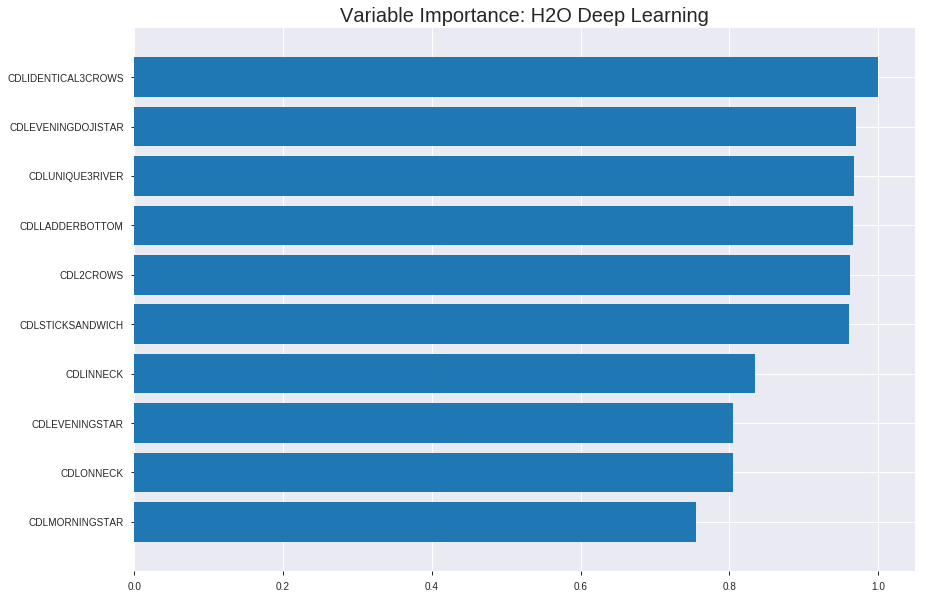

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190906_015651_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.173834019913172
RMSE: 0.4169340714227754
LogLoss: 0.5358808201548934
Mean Per-Class Error: 0.22567345697780472
AUC: 0.8548096348096348
pr_auc: 0.8409807183015579
Gini: 0.7096192696192696
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5391454828075241: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      503  322   0.3903   (322.0/825.0)
1      77   820   0.0858   (77.0/897.0)
Total  580  1142  0.2317   (399.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.539145     0.804316  213
max f2                       0.20948      0.877802  321
max f0point5                 0.824176     0.786646  105
max accuracy                 0.609095     0.777584  187
max precision                0.999594     1         0
max recall                   0.0372536    1         382
max specificity              0.999594     1         0
max absolute_mcc             0.607223     0.560332  188
max min_per_class_accuracy   0.744259     0.763657  138
max mean_per_class_accuracy  0.659732     0.774327  170

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 64.63 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.998595           1.91973    1.91973            1                0.999396   1                           0.999396            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.996982           1.80681    1.86488            0.941176         0.997568   0.971429                    0.998508            0.0178372       0.0379041                  80.6807   86.4883
    3        0.0301974                   0.99582            1.80681    1.8459             0.941176         0.996431   0.961538                    0.997829            0.0178372       0.0557414                  80.6807   84.5897
    4        0.0400697                   0.994873           1.91973    1.86409            1                0.995403   0.971014                    0.997231            0.0189521       0.0746934                  91.9732   86.4088
    5        0.0505226                   0.99371            1.70643    1.83147            0.888889         0.994413   0.954023                    0.996648            0.0178372       0.0925307                  70.6429   83.1469
    6        0.100465                    0.983096           1.83044    1.83096            0.953488         0.988713   0.953757                    0.992703            0.0914158       0.183946                   83.0443   83.0959
    7        0.150407                    0.971279           1.80812    1.82338            0.94186          0.977403   0.949807                    0.987623            0.090301        0.274247                   80.812    82.3375
    8        0.200348                    0.954483           1.69651    1.79175            0.883721         0.963484   0.933333                    0.981606            0.0847269       0.358974                   69.6508   79.175
    9        0.300232                    0.907163           1.37283    1.65238            0.715116         0.933347   0.860735                    0.965551            0.137124        0.496098                   37.2832   65.2381
    10       0.400116                    0.851932           1.38399    1.58538            0.72093          0.879339   0.825835                    0.944029            0.138239        0.634337                   38.3993   58.5381
    11       0.5                         0.759679           1.19425    1.50725            0.622093         0.809567   0.785134                    0.917168            0.119287        0.753623                   19.4252   50.7246
    12       0.599884                    0.621547           1.03799    1.42911            0.540698         0.68822    0.744434                    0.879047            0.103679        0.857302                   3.79949   42.9114
    13       0.699768                    0.478521           0.747803   1.33186            0.389535         0.55214    0.693776                    0.832384            0.0746934       0.931996                   -25.2197  33.1864
    14       0.799652                    0.303374           0.368321   1.21151            0.19186          0.394996   0.631082                    0.777751            0.0367893       0.968785                   -63.1679  21.1509
    15       0.899535                    0.109766           0.279031   1.10797            0.145349         0.200058   0.577147                    0.713604            0.0278707       0.996656                   -72.0969  10.7967
    16       1                           0.000130826        0.0332902  1                  0.017341         0.0435902  0.520906  



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.29881951861255024
RMSE: 0.5466438681742897
LogLoss: 0.8649526112135874
Mean Per-Class Error: 0.4520520520520521
AUC: 0.5279446112779447
pr_auc: 0.5789768086835598
Gini: 0.05588922255588935
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.022966400538507164: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    221  0.9955   (221.0/222.0)
1      0    270  0        (0.0/270.0)
Total  1    491  0.4492   (221.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0229664    0.709593   398
max f2                       0.0229664    0.859325   398
max f0point5                 0.0229664    0.604297   398
max accuracy                 0.469766     0.560976   253
max precision                0.989255     0.75       3
max recall                   0.0229664    1          398
max specificity              0.999467     0.995495   0
max absolute_mcc             0.469766     0.0993078  253
max min_per_class_accuracy   0.573765     0.527027   201
max mean_per_class_accuracy  0.469766     0.547948   253

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 57.66 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.987886           1.09333   1.09333            0.6              0.992813  0.6                         0.992813            0.0111111       0.0111111                  9.33333   9.33333
    2        0.0203252                   0.980506           1.09333   1.09333            0.6              0.984863  0.6                         0.988838            0.0111111       0.0222222                  9.33333   9.33333
    3        0.0304878                   0.967882           1.09333   1.09333            0.6              0.975555  0.6                         0.98441             0.0111111       0.0333333                  9.33333   9.33333
    4        0.0406504                   0.962201           1.45778   1.18444            0.8              0.965276  0.65                        0.979627            0.0148148       0.0481481                  45.7778   18.4444
    5        0.050813                    0.950655           1.09333   1.16622            0.6              0.958594  0.64                        0.97542             0.0111111       0.0592593                  9.33333   16.6222
    6        0.101626                    0.910282           1.23911   1.20267            0.68             0.928531  0.66                        0.951976            0.062963        0.122222                   23.9111   20.2667
    7        0.150407                    0.877959           0.911111  1.10811            0.5              0.895335  0.608108                    0.933606            0.0444444       0.166667                   -8.88889  10.8108
    8        0.20122                     0.8273             0.874667  1.04916            0.48             0.849192  0.575758                    0.912289            0.0444444       0.211111                   -12.5333  4.91582
    9        0.300813                    0.746003           1.07846   1.05886            0.591837         0.788027  0.581081                    0.871148            0.107407        0.318519                   7.8458    5.88589
    10       0.400407                    0.64841            1.00408   1.04523            0.55102          0.704919  0.573604                    0.829802            0.1             0.418519                   0.408163  4.52341
    11       0.5                         0.574312           1.04127   1.04444            0.571429         0.612935  0.573171                    0.786605            0.103704        0.522222                   4.12698   4.44444
    12       0.599593                    0.500905           1.07846   1.05009            0.591837         0.53753   0.576271                    0.745233            0.107407        0.62963                    7.8458    5.00942
    13       0.699187                    0.424977           0.892517  1.02765            0.489796         0.461744  0.563953                    0.704852            0.0888889       0.718519                   -10.7483  2.76486
    14       0.79878                     0.337108           0.855329  1.00616            0.469388         0.385896  0.552163                    0.665084            0.0851852       0.803704                   -14.4671  0.616342
    15       0.898374                    0.236937           0.855329  0.989442           0.469388         0.289605  0.542986                    0.623459            0.0851852       0.888889                   -14.4671  -1.05581
    16       1                           0.00575216         1.09333   1                  0.6              0.162089  0.54878                     0.576572       


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:01:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-09-06 02:01:15  8.180 sec         225 obs/sec       0.853659  1             1470       0.619524         1.8996              -0.537927      0.595077        0.557998           1.27982          0.456446                         0.62432            1.52402               -0.574084        0.494611          0.547945             0.728889           0.436992
    2019-09-06 02:01:35  28.465 sec        234 obs/sec       3.43786   4             5920       0.649416         2.17387             -0.68992       0.576118        0.563385           1.06652          0.479094                         0.616981           1.33946               -0.537295        0.504947          0.579624             1.45778            0.447154
    2019-09-06 02:01:52  45.017 sec        257 obs/sec       6.01103   7             10351      0.616396         1.64744             -0.522436      0.643399        0.594769           1.59978          0.396632                         0.656796           2.3228                -0.742104        0.467835          0.540111             1.09333            0.45122
    2019-09-06 02:02:11  1 min  4.515 sec  278 obs/sec       9.40012   11            16187      0.561377         1.15171             -0.262786      0.62923         0.598868           1.27982          0.44367                          0.616908           1.4144                -0.53693         0.482241          0.548695             1.09333            0.447154
    2019-09-06 02:02:30  1 min 23.474 sec  293 obs/sec       12.8374   15            22106      0.494722         0.748163            0.0192846      0.69154         0.656153           1.17317          0.353659                         0.606788           1.19854               -0.486922        0.481348          0.54899              1.09333            0.449187
    2019-09-06 02:02:48  1 min 41.483 sec  305 obs/sec       16.2735   19            28023      0.49927          0.796996            0.00117275     0.698045        0.655216           1.59978          0.33856                          0.616288           1.48483               -0.533842        0.478178          0.531564             1.09333            0.449187
    2019-09-06 02:03:06  1 min 58.848 sec  315 obs/sec       19.723    23            33963      0.423055         0.533433            0.282843       0.812025        0.814992           1.91973          0.278165                         0.5592             0.888398              -0.262836        0.487454          0.550505             1.82222            0.45122
    2019-09-06 02:03:23  2 min 15.923 sec  324 obs/sec       23.1696   27            39898      0.406503         0.494315            0.337863       0.841387        0.84153            1.91973          0.252033                         0.564858           0.908488              -0.288523        0.468627          0.535104             1.45778            0.45122
    2019-09-06 02:03:40  2

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLIDENTICAL3CROWS        1.0                    1.0                  0.003777359179256427
CDLEVENINGDOJISTAR        0.9695173501968384     0.9695173501968384   0.0036622152622143955
CDLUNIQUE3RIVER           0.967559814453125      0.967559814453125    0.003654820946604157
CDLLADDERBOTTOM           0.9664124250411987     0.9664124250411987   0.0036504868446768355
CDL2CROWS                 0.9614561796188354     0.9614561796188354   0.0036317653255360243
---                       ---                    ---                  ---
BBANDS_upperband_30_0_2   0.4157460033893585     0.4157460033893585   0.001570421982141967
BBANDS_lowerband_30_6_3   0.4099288582801819     0.4099288582801819   0.001548448535666752
BBANDS_upperband_20_0_2   0.4098706841468811     0.4098706841468811   0.001548228791070333
BBANDS_middleband_30_7_4  0.4084037244319916     0.4084037244319916   0.0015426875573256956
BBANDS_middleband_30_7_5  0.40711766481399536    0.40711766481399536  0.0015378296482225866


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.556910569105691)

('F1', 0.7055702917771882)

('auc', 0.5287846481876333)

('logloss', 0.8981874532691657)

('mean_per_class_error', 0.45455756929637525)

('rmse', 0.5572264772771117)

('mse', 0.31050134697865955)

deeplearning prediction progress: |███████████████████████████████████████| 100%


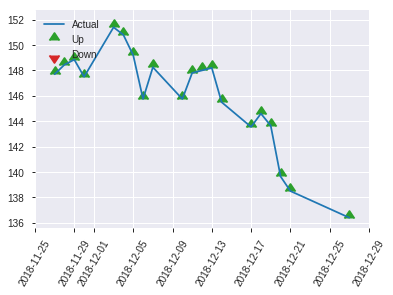


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.31050134697865955
RMSE: 0.5572264772771117
LogLoss: 0.8981874532691657
Mean Per-Class Error: 0.45455756929637525
AUC: 0.5287846481876333
pr_auc: 0.5743820263216483
Gini: 0.05756929637526653
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12319791161265264: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    110  0.9821   (110.0/112.0)
1      1    133  0.0075   (1.0/134.0)
Total  3    243  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.123198     0.70557    242
max f2                       0.0926056    0.856777   245
max f0point5                 0.234037     0.60396    218
max accuracy                 0.234037     0.556911   218
max precision                0.995867     1          0
max recall                   0.0926056    1          245
max specificity              0.995867     1          0
max absolute_mcc             0.987227     0.0916362  5
max min_per_class_accuracy   0.681382     0.537313   121
max mean_per_class_accuracy  0.681382     0.545442   121

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 61.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0121951                   0.991312           1.22388   1.22388            0.666667         0.994122  0.666667                    0.994122            0.0149254       0.0149254                  22.3881   22.3881
    2        0.0203252                   0.987464           1.83582   1.46866            1                0.990141  0.8                         0.992529            0.0149254       0.0298507                  83.5821   46.8657
    3        0.0325203                   0.975799           1.22388   1.37687            0.666667         0.981262  0.75                        0.988304            0.0149254       0.0447761                  22.3881   37.6866
    4        0.0406504                   0.972653           0.91791   1.28507            0.5              0.97399   0.7                         0.985441            0.00746269      0.0522388                  -8.20896  28.5075
    5        0.0528455                   0.963818           0         0.988519           0                0.969641  0.538462                    0.981795            0               0.0522388                  -100      -1.14811
    6        0.101626                    0.932322           1.0709    1.02806            0.583333         0.94712   0.56                        0.965151            0.0522388       0.104478                   7.08955   2.80597
    7        0.150407                    0.912449           1.22388   1.09157            0.666667         0.922568  0.594595                    0.95134             0.0597015       0.164179                   22.3881   9.15692
    8        0.203252                    0.869733           1.27095   1.13821            0.692308         0.89312   0.62                        0.936203            0.0671642       0.231343                   27.0953   13.8209
    9        0.300813                    0.82119            0.91791   1.06676            0.5              0.846153  0.581081                    0.906998            0.0895522       0.320896                   -8.20896  6.67608
    10       0.402439                    0.748572           1.10149   1.07553            0.6              0.781657  0.585859                    0.875346            0.11194         0.432836                   10.1493   7.55314
    11       0.5                         0.675524           1.0709    1.07463            0.583333         0.711499  0.585366                    0.843376            0.104478        0.537313                   7.08955   7.46269
    12       0.601626                    0.57582            0.734328  1.01714            0.4              0.628522  0.554054                    0.807083            0.0746269       0.61194                    -26.5672  1.7144
    13       0.699187                    0.453251           1.0709    1.02464            0.583333         0.502644  0.55814                     0.764603            0.104478        0.716418                   7.08955   2.46442
    14       0.800813                    0.316977           0.807761  0.997121           0.44             0.403428  0.543147                    0.718769            0.0820896       0.798507                   -19.2239  -0.287901
    15       0.898374                    0.228132           1.14739   1.01344            0.625            0.271811  0.552036                    0.67023             0.11194         0.910448                   14.7388   1.34396
    16       1                           0.0926056          0.881194  1                  0.48             0.174508  0.544715                    0.619852       

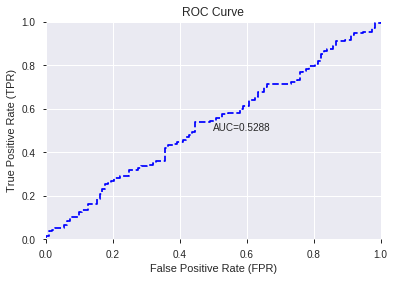

This function is available for GLM models only


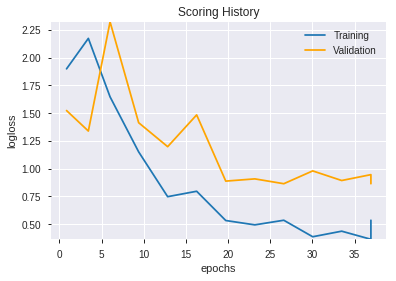

--2019-09-06 02:17:08--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190906_015651_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190906_015651_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLIDENTICAL3CROWS',
 'CDLEVENINGDOJISTAR',
 'CDLUNIQUE3RIVER',
 'CDLLADDERBOTTOM',
 'CDL2CROWS',
 'CDLSTICKSANDWICH',
 'CDLINNECK',
 'CDLEVENINGSTAR',
 'CDLONNECK',
 'CDLMORNINGSTAR',
 'CDLTHRUSTING',
 'CDLINVERTEDHAMMER',
 'CDLTASUKIGAP',
 'CDLSEPARATINGLINES',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'HT_PHASOR_quadrature',
 'BOP',
 'HT_TRENDMODE',
 'CDLDRAGONFLYDOJI',
 'TRANGE',
 'CDLHOMINGPIGEON',
 'CDLTAKURI',
 'MFI_14',
 'BETA_8',
 'STOCHRSI_fastk',
 'STOCH_slowd',
 'CDL3INSIDE',
 'BETA_12',
 'CDLHAMMER',
 'CDLHARAMI',
 'BETA_30',
 'CDLMARUBOZU',
 'CORREL_20',
 'CDLHANGINGMAN',
 'DX_12',
 'CDLRICKSHAWMAN',
 'BETA_24',
 'ULTOSC',
 'STOCHF_fastd',
 'HT_DCPERIOD',
 'aroonup_8',
 'ADOSC',
 'CDLDOJI',
 'STOCHF_fastk',
 'CORREL_8',
 'CORREL_14',
 'BETA_14',
 'BETA_20',
 'aroonup_20',
 'HT_PHASOR_inphase',
 'ADXR_14',
 'CORREL_24',
 'CDLCLOSINGMARUBOZU',
 'STOCH_slowk',
 'AROONOSC_14',
 'ROCR_8',
 'MFI_30',
 'CDLENGULFING',
 'CDLBELTHOLD',
 'DX_8',
 'aroondown_20

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190906_021716_model_1  0.48714  0.702376              0.495536  0.504573  0.254594

variable  relative_importance  scaled_importance  percentage
0                 CDLMARUBOZU             0.008127           1.000000    0.015634
1           CDLINVERTEDHAMMER             0.007392           0.909510    0.014220
2            CDLSTICKSANDWICH             0.006564           0.807689    0.012628
3                 CDLLONGLINE             0.005822           0.716328    0.011199
4          CDLCLOSINGMARUBOZU             0.005817           0.715805    0.011191
..                        ...                  ...                ...         ...
554  BBANDS_middleband_12_4_5             0.000009           0.001156    0.000018
555   BBANDS_upperband_30_2_2             0.000009           0.001113    0.000017
556     LINEARREG_INTERCEPT_8             0.000004           0.000497    0.000008
557    LINEARREG_INTERCEPT_12             0.000002           0.000261    0.000004
558   BBANDS_lowerband_14_0_2             0.000001           0.000176    0.000003

[559 rows x 4 columns]

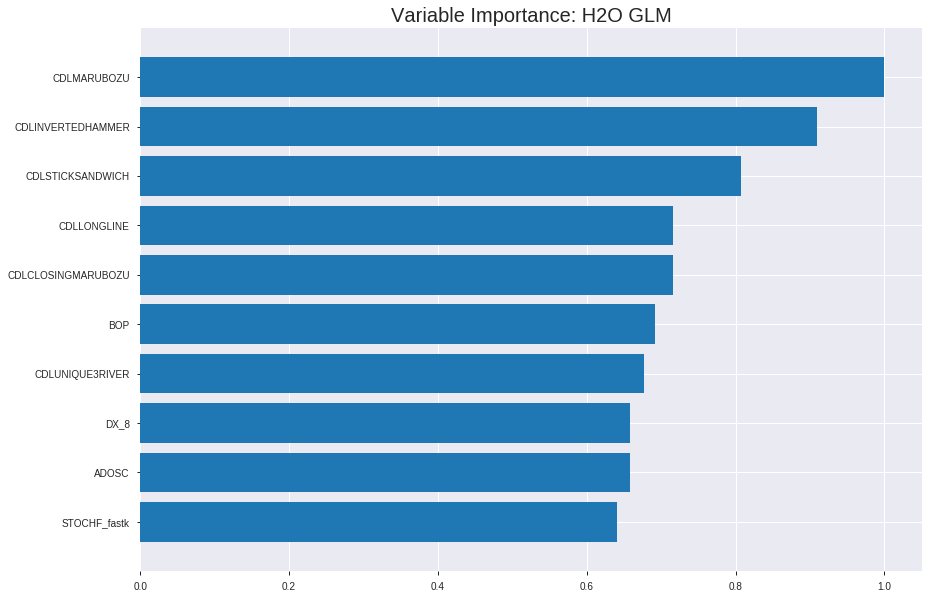

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190906_021716_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24636147229894736
RMSE: 0.49634813618965806
LogLoss: 0.6858403987443391
Null degrees of freedom: 1721
Residual degrees of freedom: 1162
Null deviance: 2384.1875591118605
Residual deviance: 2362.0343332755037
AIC: 3482.0343332755037
AUC: 0.5833721833721833
pr_auc: 0.6003565692117377
Gini: 0.16674436674436666
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45104650714822125: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      15   810   0.9818   (810.0/825.0)
1      5    892   0.0056   (5.0/897.0)
Total  20   1702  0.4733   (815.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.451047     0.686418  382
max f2                       0.420367     0.844633  399
max f0point5                 0.509874     0.593778  236
max accuracy                 0.517682     0.570267  207
max precision                0.60762      1         0
max recall                   0.420367     1         399
max specificity              0.60762      1         0
max absolute_mcc             0.517682     0.135568  207
max min_per_class_accuracy   0.523597     0.560758  183
max mean_per_class_accuracy  0.517682     0.566888  207

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 52.09 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.576686           1.49313   1.49313            0.777778         0.584453  0.777778                    0.584453            0.0156076       0.0156076                  49.3125   49.3125
    2        0.0203252                   0.571995           1.12925   1.31639            0.588235         0.573861  0.685714                    0.579308            0.0111483       0.0267559                  12.9254   31.6388
    3        0.0301974                   0.565994           1.69388   1.4398             0.882353         0.568974  0.75                        0.57593             0.0167224       0.0434783                  69.3882   43.9799
    4        0.0400697                   0.564272           1.12925   1.36329            0.588235         0.565085  0.710145                    0.573258            0.0111483       0.0546265                  12.9254   36.3288
    5        0.0505226                   0.562752           1.59978   1.41222            0.833333         0.563329  0.735632                    0.571204            0.0167224       0.0713489                  59.9777   41.2217
    6        0.100465                    0.553815           1.18309   1.29832            0.616279         0.557957  0.676301                    0.564619            0.0590858       0.130435                   18.3091   29.8316
    7        0.150407                    0.54786            1.02683   1.20817            0.534884         0.550701  0.629344                    0.559997            0.0512821       0.181717                   2.68336   20.8171
    8        0.200348                    0.543366           1.13845   1.19079            0.593023         0.545406  0.62029                     0.55636             0.0568562       0.238573                   13.8446   19.0791
    9        0.300232                    0.535588           1.07148   1.1511             0.55814          0.539041  0.599613                    0.550598            0.107023        0.345596                   7.14786   15.1097
    10       0.400116                    0.529881           1.10496   1.13958            0.575581         0.532617  0.593614                    0.546109            0.110368        0.455964                   10.4962   13.958
    11       0.5                         0.523619           1.03799   1.11929            0.540698         0.526786  0.583043                    0.542249            0.103679        0.559643                   3.79949   11.9287
    12       0.599884                    0.516286           1.00451   1.10018            0.523256         0.520152  0.573088                    0.53857             0.100334        0.659978                   0.451116  10.0176
    13       0.699768                    0.508407           0.926383  1.07537            0.482558         0.512706  0.560166                    0.534878            0.0925307       0.752508                   -7.36175  7.53688
    14       0.799652                    0.49977            0.803609  1.04142            0.418605         0.504113  0.542484                    0.531035            0.0802676       0.832776                   -19.6391  4.14235
    15       0.899535                    0.484989           0.81477   1.01626            0.424419         0.492457  0.529374                    0.526751            0.0813824       0.914158                   -18.523   1.6256
    16       1                           0.420367           0.854447  1                  0.445087         0.468567  0.520906                    0.520906           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25195397473790976
RMSE: 0.5019501715687622
LogLoss: 0.6970664943313808
Null degrees of freedom: 491
Residual degrees of freedom: -68
Null deviance: 678.9014289835272
Residual deviance: 685.9134304220787
AIC: 1805.9134304220788
AUC: 0.512937937937938
pr_auc: 0.5487382667829935
Gini: 0.02587587587587592
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4225610171241826: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    219  0.9865   (219.0/222.0)
1      1    269  0.0037   (1.0/270.0)
Total  4    488  0.4472   (220.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.422561     0.709763   395
max f2                       0.385406     0.858779   399
max f0point5                 0.457014     0.607903   337
max accuracy                 0.457014     0.560976   337
max precision                0.533402     0.6        7
max recall                   0.385406     1          399
max specificity              0.542295     0.995495   0
max absolute_mcc             0.457014     0.0745395  337
max min_per_class_accuracy   0.482455     0.513514   201
max mean_per_class_accuracy  0.480146     0.530681   217

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 48.35 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.535765           0.728889  0.728889           0.4              0.537728  0.4                         0.537728            0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.533363           1.45778   1.09333            0.8              0.534552  0.6                         0.53614             0.0148148       0.0222222                  45.7778   9.33333
    3        0.0304878                   0.531329           0.728889  0.971852           0.4              0.532721  0.533333                    0.535001            0.00740741      0.0296296                  -27.1111  -2.81481
    4        0.0406504                   0.529461           0.364444  0.82               0.2              0.53018   0.45                        0.533795            0.0037037       0.0333333                  -63.5556  -18
    5        0.050813                    0.528484           1.09333   0.874667           0.6              0.529125  0.48                        0.532861            0.0111111       0.0444444                  9.33333   -12.5333
    6        0.101626                    0.51804            0.874667  0.874667           0.48             0.523951  0.48                        0.528406            0.0444444       0.0888889                  -12.5333  -12.5333
    7        0.150407                    0.509579           1.13889   0.96036            0.625            0.514311  0.527027                    0.523835            0.0555556       0.144444                   13.8889   -3.96396
    8        0.20122                     0.503255           1.02044   0.975533           0.56             0.506006  0.535354                    0.519333            0.0518519       0.196296                   2.04444   -2.44669
    9        0.300813                    0.495232           1.15283   1.03423            0.632653         0.498774  0.567568                    0.512526            0.114815        0.311111                   15.2834   3.42342
    10       0.400407                    0.488215           1.07846   1.04523            0.591837         0.491778  0.573604                    0.507365            0.107407        0.418519                   7.8458    4.52341
    11       0.5                         0.482483           0.929705  1.02222            0.510204         0.485316  0.560976                    0.502974            0.0925926       0.511111                   -7.02948  2.22222
    12       0.599593                    0.476363           0.966893  1.01303            0.530612         0.479763  0.555932                    0.499118            0.0962963       0.607407                   -3.31066  1.3032
    13       0.699187                    0.470825           0.892517  0.995866           0.489796         0.473478  0.546512                    0.495466            0.0888889       0.696296                   -10.7483  -0.413437
    14       0.79878                     0.463699           1.11565   1.0108             0.612245         0.46794   0.554707                    0.492034            0.111111        0.807407                   11.5646   1.08001
    15       0.898374                    0.454827           1.00408   1.01006            0.55102          0.459191  0.554299                    0.488393            0.1             0.907407                   0.408163  1.00553
    16       1                           0.385406           0.911111  1                  0.5              0.439829  0.54878                     0.483458      


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-09-06 02:17:17  0.000 sec   2            3.6       560           1.37168           1.39413
    2019-09-06 02:17:18  0.579 sec   4            2.6       560           1.36898           1.39658
    2019-09-06 02:17:19  1.175 sec   6            1.9       560           1.36583           1.39955
    2019-09-06 02:17:19  1.764 sec   8            1.4       560           1.36222           1.40287
    2019-09-06 02:17:20  2.426 sec   10           1         560           1.35814           1.40664

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5487804878048781)

('F1', 0.7071240105540898)

('auc', 0.4871401918976546)

('logloss', 0.7023757590070515)

('mean_per_class_error', 0.4714818763326226)

('rmse', 0.5045726024318483)

('mse', 0.254593511124848)

glm prediction progress: |████████████████████████████████████████████████| 100%


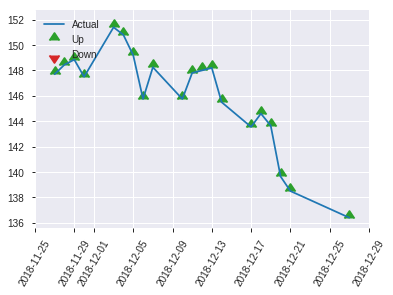


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.254593511124848
RMSE: 0.5045726024318483
LogLoss: 0.7023757590070515
Null degrees of freedom: 245
Residual degrees of freedom: -314
Null deviance: 339.6180594432119
Residual deviance: 345.56887343146934
AIC: 1465.5688734314695
AUC: 0.4871401918976546
pr_auc: 0.5484666715004003
Gini: -0.025719616204690765
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4216118139883835: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    134  0        (0.0/134.0)
Total  1    245  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.421612     0.707124  244
max f2                       0.421612     0.857875  244
max f0point5                 0.421612     0.601436  244
max accuracy                 0.421612     0.54878   244
max precision                0.525398     1         0
max recall                   0.421612     1         244
max specificity              0.525398     1         0
max absolute_mcc             0.437876     0.118806  234
max min_per_class_accuracy   0.468559     0.507463  122
max mean_per_class_accuracy  0.485429     0.528518  33

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 46.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.510271           1.22388   1.22388            0.666667         0.518908  0.666667                    0.518908            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   0.500432           0.91791   1.10149            0.5              0.506124  0.6                         0.513794            0.00746269      0.0223881                  -8.20896   10.1493
    3        0.0325203                   0.499115           1.22388   1.14739            0.666667         0.499514  0.625                       0.508439            0.0149254       0.0373134                  22.3881    14.7388
    4        0.0406504                   0.498284           0.91791   1.10149            0.5              0.498977  0.6                         0.506547            0.00746269      0.0447761                  -8.20896   10.1493
    5        0.0528455                   0.496563           1.83582   1.27095            1                0.497446  0.692308                    0.504447            0.0223881       0.0671642                  83.5821    27.0953
    6        0.101626                    0.4886             0.91791   1.10149            0.5              0.491962  0.6                         0.498454            0.0447761       0.11194                    -8.20896   10.1493
    7        0.150407                    0.484278           1.0709    1.09157            0.583333         0.486167  0.594595                    0.494469            0.0522388       0.164179                   7.08955    9.15692
    8        0.203252                    0.481975           0.564868  0.954627           0.307692         0.482832  0.52                        0.491443            0.0298507       0.19403                    -43.5132   -4.53731
    9        0.300813                    0.47723            1.14739   1.01714            0.625            0.479653  0.554054                    0.487619            0.11194         0.30597                    14.7388    1.7144
    10       0.402439                    0.473222           0.881194  0.982813           0.48             0.474737  0.535354                    0.484366            0.0895522       0.395522                   -11.8806   -1.71868
    11       0.5                         0.46854            1.14739   1.01493            0.625            0.470931  0.552846                    0.481745            0.11194         0.507463                   14.7388    1.49254
    12       0.601626                    0.464617           0.881194  0.992336           0.48             0.466534  0.540541                    0.479175            0.0895522       0.597015                   -11.8806   -0.766438
    13       0.699187                    0.457279           0.91791   0.981951           0.5              0.460392  0.534884                    0.476554            0.0895522       0.686567                   -8.20896   -1.80493
    14       0.800813                    0.450443           0.954627  0.978483           0.52             0.453685  0.532995                    0.473652            0.0970149       0.783582                   -4.53731   -2.15168
    15       0.898374                    0.443711           0.994403  0.980212           0.541667         0.44738   0.533937                    0.470799            0.0970149       0.880597                   -0.559701  -1.97879
    16       1                           0.416167           1.17493   1                  0.64             0.436732  0.544715              

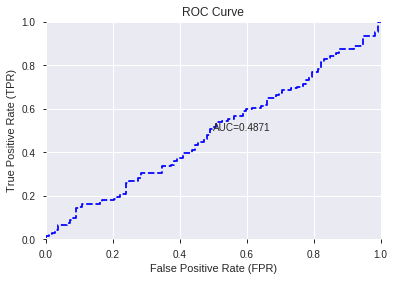

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


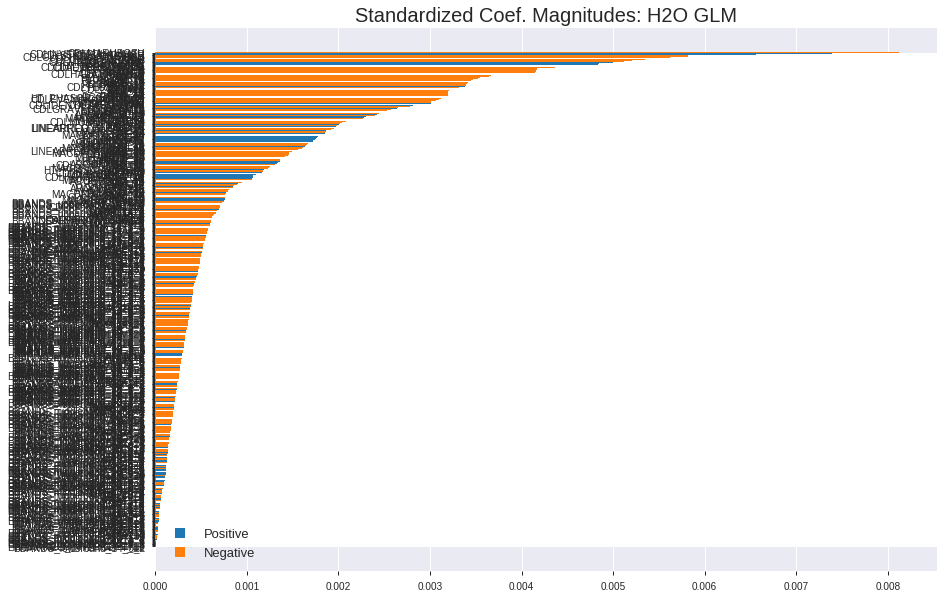

'log_likelihood'
--2019-09-06 02:17:34--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190906_021716_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190906_021716_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['CDLMARUBOZU',
 'CDLINVERTEDHAMMER',
 'CDLSTICKSANDWICH',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'BOP',
 'CDLUNIQUE3RIVER',
 'DX_8',
 'ADOSC',
 'STOCHF_fastk',
 'CDLMATCHINGLOW',
 'CDLHIKKAKE',
 'CDL3INSIDE',
 'HT_TRENDMODE',
 'PLUS_DM_30',
 'CDLEVENINGSTAR',
 'CDLLADDERBOTTOM',
 'PLUS_DM_24',
 'ROC_8',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'TRANGE',
 'CDLHARAMICROSS',
 'CDLHAMMER',
 'DX_12',
 'ATR_8',
 'PLUS_DM_14',
 'aroondown_8',
 'PLUS_DM_12',
 'BETA_24',
 'WILLR_8',
 'ROCP_12',
 'ROCR_12',
 'ROCR100_12',
 'ROC_12',
 'ATR_12',
 'PLUS_DM_8',
 'CDLTHRUSTING',
 'ATR_14',
 'CDL2CROWS',
 'BETA_8',
 'DX_14',
 'ATR_20',
 'ROC_14',
 'ADX_24',
 'ATR_30',
 'ROCP_14',
 'ROCR_14',
 'ROCR100_14',
 'ATR_24',
 'HT_PHASOR_quadrature',
 'CDLEVENINGDOJISTAR',
 'ULTOSC',
 'CDLBELTHOLD',
 'STOCHF_fastd',
 'STOCH_slowk',
 'MFI_24',
 'CDLIDENTICAL3CROWS',
 'CDLTASUKIGAP',
 'MFI_20',
 'STDDEV_8',
 'MOM_12',
 'CDLGRAVESTONEDOJI',
 'MINUS_DM_8',
 'PLUS_DI_30',
 'MINUS_DI_8',
 'MOM_14',
 'AROONOSC_8',
 'WI

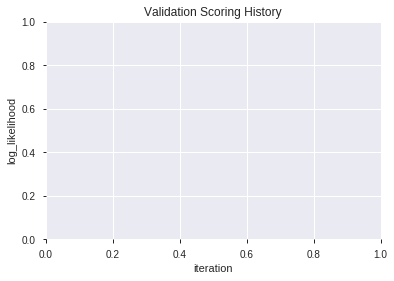

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190906_021748_model_3  0.539446  0.760510              0.495536  0.530512  0.281443
1               XGBoost_1_AutoML_20190906_021748  0.533782  0.735636              0.486607  0.519585  0.269968
2               XGBoost_3_AutoML_20190906_021748  0.525853  0.728828              0.477679  0.516927  0.267214
3  XGBoost_grid_1_AutoML_20190906_021748_model_7  0.522988  0.766775              0.482143  0.532561  0.283621
4  XGBoost_grid_1_AutoML_20190906_021748_model_6  0.513793  0.731321              0.500000  0.517885  0.268205
5  XGBoost_grid_1_AutoML_20190906_021748_model_2  0.512460  0.707695              0.495536  0.507035  0.257084
6  XGBoost_grid_1_AutoML_20190906_021748_model_5  0.502732  0.767407              0.485874  0.532450  0.283503
7  XGBoost_grid_1_AutoML_20190906_021748_model_1  0.493903  0.751611              0.500000  0.526449  0.277149
8               XGBoost_2_AutoML_20190906_021748  0.493004  0.726244              0.495536  0.515610  0.265853
9  XGBoost_grid_1_AutoML_20190906_021748_model_4  0.485541  0.720211              0.494803  0.512934  0.263101

variable  relative_importance  scaled_importance  percentage
0                 BETA_12           165.925583           1.000000    0.031833
1                  ADXR_8           113.888298           0.686382    0.021850
2             STOCH_slowk            93.911308           0.565985    0.018017
3    HT_PHASOR_quadrature            86.832123           0.523320    0.016659
4                     BOP            85.076088           0.512736    0.016322
..                    ...                  ...                ...         ...
227    LINEARREG_SLOPE_14             3.050313           0.018384    0.000585
228             MAVP_12_7             2.528410           0.015238    0.000485
229          aroondown_12             2.388607           0.014396    0.000458
230           aroondown_8             1.794516           0.010815    0.000344
231           MINUS_DI_20             0.212330           0.001280    0.000041

[232 rows x 4 columns]

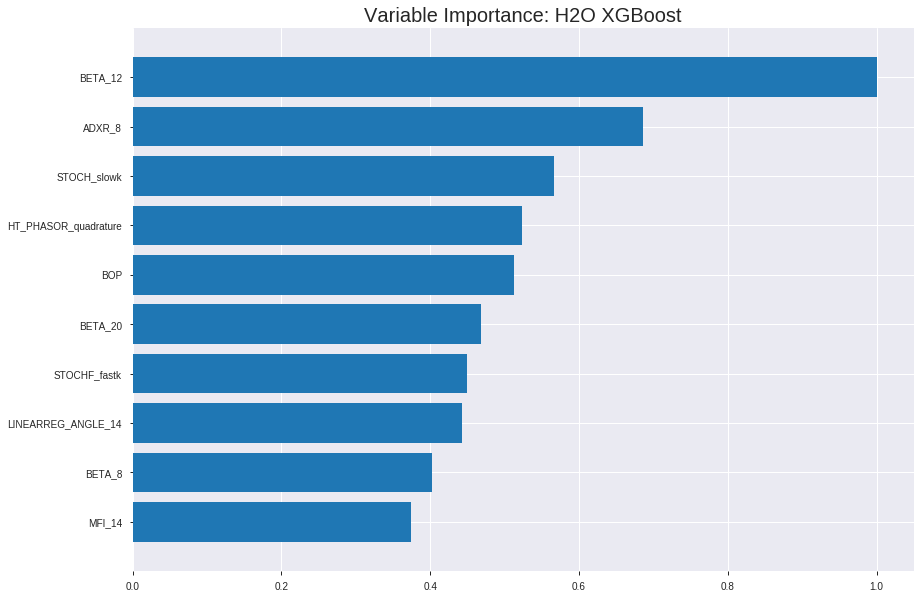

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190906_021748_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.183836159366938
RMSE: 0.4287611915354957
LogLoss: 0.556695760542895
Mean Per-Class Error: 0.15459207459207458
AUC: 0.9202560724299854
pr_auc: 0.927797210925601
Gini: 0.8405121448599708
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.522171139717102: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      700  125  0.1515   (125.0/825.0)
1      144  753  0.1605   (144.0/897.0)
Total  844  878  0.1562   (269.0/1722.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.522171     0.848451  195
max f2                       0.454022     0.898982  260
max f0point5                 0.552976     0.870326  163
max accuracy                 0.529168     0.844367  187
max precision                0.813264     1         0
max recall                   0.355757     1         338
max specificity              0.813264     1         0
max absolute_mcc             0.529168     0.690363  187
max min_per_class_accuracy   0.520979     0.841695  196
max mean_per_class_accuracy  0.529168     0.845408  187

Gains/Lift Table: Avg response rate: 52.09 %, avg score: 51.88 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010453                    0.743788           1.91973    1.91973            1                0.764851  1                           0.764851            0.0200669       0.0200669                  91.9732   91.9732
    2        0.0203252                   0.718376           1.91973    1.91973            1                0.727785  1                           0.746848            0.0189521       0.039019                   91.9732   91.9732
    3        0.0301974                   0.705593           1.91973    1.91973            1                0.711169  1                           0.735184            0.0189521       0.057971                   91.9732   91.9732
    4        0.0400697                   0.695754           1.91973    1.91973            1                0.701267  1                           0.726827            0.0189521       0.0769231                  91.9732   91.9732
    5        0.0505226                   0.689236           1.91973    1.91973            1                0.692515  1                           0.719728            0.0200669       0.09699                    91.9732   91.9732
    6        0.100465                    0.66106            1.91973    1.91973            1                0.673271  1                           0.696634            0.0958751       0.192865                   91.9732   91.9732
    7        0.150407                    0.638535           1.87509    1.90491            0.976744         0.648987  0.992278                    0.680813            0.0936455       0.286511                   87.5088   90.4908
    8        0.200348                    0.616213           1.83044    1.88635            0.953488         0.626295  0.982609                    0.667223            0.0914158       0.377926                   83.0443   88.6346
    9        0.300232                    0.587525           1.69651    1.82319            0.883721         0.601254  0.94971                     0.645276            0.169454        0.54738                    69.6508   82.3189
    10       0.400116                    0.555459           1.59606    1.76649            0.831395         0.572196  0.920174                    0.627032            0.15942         0.7068                     59.6057   76.6488
    11       0.5                         0.525247           1.21657    1.65663            0.633721         0.5402    0.86295                     0.609686            0.121516        0.828317                   21.6575   65.6633
    12       0.599884                    0.491847           0.758964   1.50717            0.395349         0.508729  0.785092                    0.592876            0.0758082       0.904125                   -24.1036  50.7167
    13       0.699768                    0.45834            0.546901   1.3701             0.284884         0.477014  0.713693                    0.576338            0.0546265       0.958751                   -45.3099  37.01
    14       0.799652                    0.415005           0.256708   1.23103            0.133721         0.438844  0.641249                    0.559164            0.025641        0.984392                   -74.3292  23.1027
    15       0.899535                    0.369892           0.133935   1.10921            0.0697674        0.394478  0.577792                    0.540877            0.0133779       0.99777                    -86.6065  10.9206
    16       1                           0.126649           0.0221934  1                  0.0115607        0.320813  0.520906                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.27095414749536156
RMSE: 0.520532561417018
LogLoss: 0.7379728659041439
Mean Per-Class Error: 0.467967967967968
AUC: 0.508767100433767
pr_auc: 0.5590992108540548
Gini: 0.0175342008675341
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2472497969865799: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    219  0.9865   (219.0/222.0)
1      0    270  0        (0.0/270.0)
Total  3    489  0.4451   (219.0/492.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.24725      0.711462   396
max f2                       0.24725      0.860421   396
max f0point5                 0.24725      0.606469   396
max accuracy                 0.24725      0.554878   396
max precision                0.708743     1          0
max recall                   0.24725      1          396
max specificity              0.708743     1          0
max absolute_mcc             0.24725      0.0863797  396
max min_per_class_accuracy   0.404448     0.511111   201
max mean_per_class_accuracy  0.459402     0.532032   140

Gains/Lift Table: Avg response rate: 54.88 %, avg score: 42.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101626                   0.679911           0.728889  0.728889           0.4              0.698292  0.4                         0.698292            0.00740741      0.00740741                 -27.1111  -27.1111
    2        0.0203252                   0.656411           1.09333   0.911111           0.6              0.668799  0.5                         0.683546            0.0111111       0.0185185                  9.33333   -8.88889
    3        0.0304878                   0.63557            1.09333   0.971852           0.6              0.645346  0.533333                    0.670812            0.0111111       0.0296296                  9.33333   -2.81481
    4        0.0406504                   0.622551           1.82222   1.18444            1                0.63024   0.65                        0.660669            0.0185185       0.0481481                  82.2222   18.4444
    5        0.050813                    0.607177           1.09333   1.16622            0.6              0.615385  0.64                        0.651612            0.0111111       0.0592593                  9.33333   16.6222
    6        0.101626                    0.575187           0.874667  1.02044            0.48             0.586557  0.56                        0.619084            0.0444444       0.103704                   -12.5333  2.04444
    7        0.150407                    0.548443           1.13889   1.05886            0.625            0.562467  0.581081                    0.600722            0.0555556       0.159259                   13.8889   5.88589
    8        0.20122                     0.522275           1.02044   1.04916            0.56             0.533616  0.575758                    0.583776            0.0518519       0.211111                   2.04444   4.91582
    9        0.300813                    0.478932           1.15283   1.08348            0.632653         0.5005    0.594595                    0.556205            0.114815        0.325926                   15.2834   8.34835
    10       0.400407                    0.438665           0.929705  1.04523            0.510204         0.457755  0.573604                    0.531717            0.0925926       0.418519                   -7.02948  4.52341
    11       0.5                         0.404254           0.929705  1.02222            0.510204         0.421215  0.560976                    0.509707            0.0925926       0.511111                   -7.02948  2.22222
    12       0.599593                    0.378886           0.929705  1.00685            0.510204         0.390261  0.552542                    0.489867            0.0925926       0.603704                   -7.02948  0.685499
    13       0.699187                    0.354013           0.929705  0.995866           0.510204         0.366654  0.546512                    0.472316            0.0925926       0.696296                   -7.02948  -0.413437
    14       0.79878                     0.333453           0.818141  0.973707           0.44898          0.345742  0.534351                    0.456534            0.0814815       0.777778                   -18.1859  -2.62935
    15       0.898374                    0.30754            1.19002   0.997687           0.653061         0.32109   0.547511                    0.441519            0.118519        0.896296                   19.0023   -0.231272
    16       1                           0.20293            1.02044   1                  0.56             0.280202  0.54878                     0.425125


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-09-06 02:18:00  3.074 sec   0                  0.5              0.693147            0.5             0                  1                0.479094                         0.5                0.693147              0.5               0                    1                  0.45122
    2019-09-06 02:18:00  3.413 sec   5                  0.490034         0.673374            0.745436        0.743847           1.70643          0.355401                         0.502769           0.698719              0.497014          0.541994             1.09333            0.45122
    2019-09-06 02:18:00  3.565 sec   10                 0.482285         0.658179            0.789921        0.796541           1.81308          0.28223                          0.505091           0.703472              0.495546          0.545671             0.728889           0.45122
    2019-09-06 02:18:00  3.715 sec   15                 0.474816         0.643634            0.817195        0.831162           1.81308          0.271777                         0.508086           0.7097                0.511011          0.550538             0.728889           0.45122
    2019-09-06 02:18:01  3.870 sec   20                 0.467887         0.630264            0.843232        0.854813           1.91973          0.249129                         0.510031           0.713882              0.518785          0.556623             0.364444           0.447154
    2019-09-06 02:18:01  4.031 sec   25                 0.459878         0.61498             0.869376        0.877859           1.91973          0.230546                         0.511033           0.716093              0.514398          0.552128             0.728889           0.449187
    2019-09-06 02:18:01  4.293 sec   30                 0.451939         0.599913            0.884108        0.88931            1.91973          0.202091                         0.513338           0.721118              0.502895          0.552159             0.728889           0.45122
    2019-09-06 02:18:01  4.461 sec   35                 0.445116         0.587073            0.898333        0.905966           1.91973          0.182927                         0.514699           0.724204              0.502377          0.549533             0.728889           0.45122
    2019-09-06 02:18:01  4.640 sec   40                 0.439064         0.575741            0.90686         0.913905           1.91973          0.180604                         0.51666            0.728773              0.504479          0.556455             0.728889           0.449187
    2019-09-06 02:18:01  4.822 sec   45                 0.434029         0.566514            0.915443        0.922814           1.91973          0.171312                         0.517578           0.731024              0.507833          0.560691             1.09333            0.449187
    2019-09-06 02:18:02  5.004 sec   50                 0.428761         0.556696            0.920256        0.927797           1.91973          0.156214                         0.520533           0.737973              0.508767          0.559099             0.728889           0.445122

Variable Importances: 


variable              relative_importance    scaled_importance      percentage
--------------------  ---------------------  ---------------------  ---------------------
BETA_12               165.9255828857422      1.0                    0.031833156154699435
ADXR_8                113.88829803466797     0.6863817866657275     0.021849698596671695
STOCH_slowk           93.91130828857422      0.5659845013366165     0.018017073012188203
HT_PHASOR_quadrature  86.83212280273438      0.5233196791752586     0.016658917066013218
BOP                   85.07608795166016      0.512736411540855      0.016322018254780274
---                   ---                    ---                    ---
LINEARREG_SLOPE_14    3.0503129959106445     0.018383620794697565   0.0005852086714463874
MAVP_12_7             2.528409957885742      0.015238216517984616   0.0004850805259361246
aroondown_12          2.3886070251464844     0.014395652458194467   0.0004582590526504873
aroondown_8           1.794515609741211      0.010815183400482192   0.0003442814220292629
MINUS_DI_20           0.21232986450195312    0.0012796692397227577  4.073591073446006e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5609756097560976)

('F1', 0.7071240105540898)

('auc', 0.5394456289978679)

('logloss', 0.7605095791616128)

('mean_per_class_error', 0.44842750533049036)

('rmse', 0.5305124764655275)

('mse', 0.2814434876855868)

xgboost prediction progress: |████████████████████████████████████████████| 100%


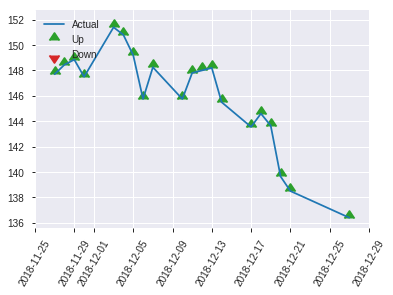


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2814434876855868
RMSE: 0.5305124764655275
LogLoss: 0.7605095791616128
Mean Per-Class Error: 0.44842750533049036
AUC: 0.5394456289978679
pr_auc: 0.5742191490216275
Gini: 0.07889125799573571
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23266829550266266: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    111  0.9911   (111.0/112.0)
1      0    134  0        (0.0/134.0)
Total  1    245  0.4512   (111.0/246.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.232668     0.707124  244
max f2                       0.232668     0.857875  244
max f0point5                 0.311945     0.603837  187
max accuracy                 0.340863     0.560976  149
max precision                0.530597     0.75      3
max recall                   0.232668     1         244
max specificity              0.563992     0.991071  0
max absolute_mcc             0.255978     0.105522  235
max min_per_class_accuracy   0.352813     0.517857  123
max mean_per_class_accuracy  0.340863     0.551572  149

Gains/Lift Table: Avg response rate: 54.47 %, avg score: 36.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0121951                   0.534368           1.22388   1.22388            0.666667         0.553926  0.666667                    0.553926            0.0149254       0.0149254                  22.3881    22.3881
    2        0.0203252                   0.508295           0.91791   1.10149            0.5              0.525069  0.6                         0.542383            0.00746269      0.0223881                  -8.20896   10.1493
    3        0.0325203                   0.496835           0.61194   0.91791            0.333333         0.501263  0.5                         0.526963            0.00746269      0.0298507                  -38.806    -8.20896
    4        0.0406504                   0.488725           1.83582   1.10149            1                0.495357  0.6                         0.520642            0.0149254       0.0447761                  83.5821    10.1493
    5        0.0528455                   0.484403           1.83582   1.27095            1                0.486087  0.692308                    0.512668            0.0223881       0.0671642                  83.5821    27.0953
    6        0.101626                    0.463591           0.764925  1.02806            0.416667         0.474023  0.56                        0.494118            0.0373134       0.104478                   -23.5075   2.80597
    7        0.150407                    0.434251           1.37687   1.14119            0.75             0.447869  0.621622                    0.479118            0.0671642       0.171642                   37.6866    14.1186
    8        0.203252                    0.416965           0.988519  1.10149            0.538462         0.424241  0.6                         0.46485             0.0522388       0.223881                   -1.14811   10.1493
    9        0.300813                    0.391725           1.0709    1.09157            0.583333         0.401896  0.594595                    0.444433            0.104478        0.328358                   7.08955    9.15692
    10       0.402439                    0.372645           0.881194  1.03844            0.48             0.383582  0.565657                    0.429066            0.0895522       0.41791                    -11.8806   3.84441
    11       0.5                         0.353687           0.994403  1.02985            0.541667         0.366066  0.560976                    0.416773            0.0970149       0.514925                   -0.559701  2.98507
    12       0.601626                    0.341062           1.24836   1.06676            0.68             0.346125  0.581081                    0.40484             0.126866        0.641791                   24.8358    6.67608
    13       0.699187                    0.323857           0.994403  1.05666            0.541667         0.332668  0.575581                    0.394769            0.0970149       0.738806                   -0.559701  5.66644
    14       0.800813                    0.305951           0.807761  1.02508            0.44             0.315441  0.558376                    0.384702            0.0820896       0.820896                   -19.2239   2.50777
    15       0.898374                    0.28294            0.764925  0.996826           0.416667         0.29389   0.542986                    0.37484             0.0746269       0.895522                   -23.5075   -0.317417
    16       1                           0.207151           1.02806   1                  0.56             0.257197  0.544715                 

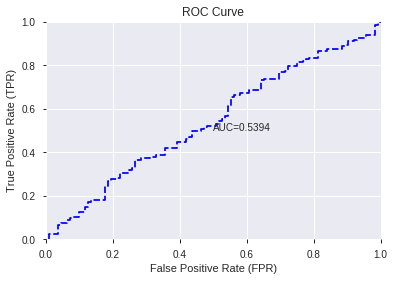

This function is available for GLM models only


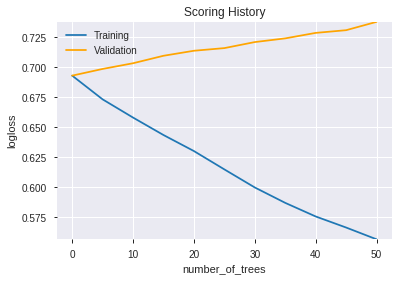

--2019-09-06 02:18:16--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.164.243
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.164.243|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190906_021748_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190906_021748_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_9c46',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BETA_12',
 'ADXR_8',
 'STOCH_slowk',
 'HT_PHASOR_quadrature',
 'BOP',
 'BETA_20',
 'STOCHF_fastk',
 'LINEARREG_ANGLE_14',
 'BETA_8',
 'MFI_14',
 'NATR_30',
 'BETA_30',
 'PLUS_DI_14',
 'WILLR_8',
 'STDDEV_14',
 'ADOSC',
 'PLUS_DM_12',
 'DX_8',
 'CORREL_20',
 'STOCH_slowd',
 'BETA_24',
 'BETA_14',
 'ROC_24',
 'MINUS_DM_12',
 'ULTOSC',
 'CCI_20',
 'DX_12',
 'WILLR_30',
 'WILLR_20',
 'STDDEV_8',
 'STDDEV_24',
 'MACDFIX_hist_20',
 'DX_30',
 'WILLR_24',
 'MFI_20',
 'HT_DCPERIOD',
 'STOCHRSI_fastd',
 'ATR_8',
 'STOCHF_fastd',
 'CCI_8',
 'NATR_24',
 'MFI_30',
 'CCI_30',
 'PLUS_DM_8',
 'AD',
 'DX_14',
 'ADX_8',
 'CORREL_24',
 'CORREL_8',
 'MACDFIX_signal_8',
 'ADXR_14',
 'TRANGE',
 'MINUS_DI_14',
 'MOM_12',
 'LINEARREG_ANGLE_30',
 'MOM_24',
 'WILLR_14',
 'MACDFIX_hist_14',
 'MACDEXT_signal',
 'CORREL_14',
 'HT_PHASOR_inphase',
 'SAR_0.2',
 'ADX_20',
 'BBANDS_upperband_12_4_5',
 'MFI_24',
 'BBANDS_upperband_20_0_5',
 'MINUS_DI_8',
 'VAR_14',
 'MACDFIX_hist_24',
 'LINEARREG_SLOPE_8',
 'RSI_30',

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.557
GLM             0.549
XGBoost         0.573
dtype: float64

DeepLearning    GLM  XGBoost
All          0.545  0.545    0.549
DLF          0.545  0.545    0.573
Fwe          0.549  0.545    0.549
RFE          0.557  0.549    0.561
XGBF         0.545  0.545    0.573





F1


DeepLearning    0.706
GLM             0.707
XGBoost         0.707
dtype: float64

DeepLearning    GLM  XGBoost
All          0.705  0.705    0.706
DLF          0.705  0.705    0.707
Fwe          0.706  0.705    0.706
RFE          0.706  0.707    0.707
XGBF         0.705  0.705    0.707





auc


DeepLearning    0.529
GLM             0.516
XGBoost         0.564
dtype: float64

DeepLearning    GLM  XGBoost
All          0.503  0.516    0.512
DLF          0.503  0.506    0.564
Fwe          0.507  0.516    0.512
RFE          0.529  0.487    0.539
XGBF         0.521  0.506    0.564





logloss


DeepLearning    18.469
GLM             18.099
XGBoost          0.761
dtype: float64

DeepLearning     GLM  XGBoost
All         18.399  18.013    0.723
DLF         18.469  18.099    0.709
Fwe         15.253  18.013    0.723
RFE          0.898   0.702    0.761
XGBF        17.757  18.099    0.709





mean_per_class_error


DeepLearning    0.496
GLM             0.492
XGBoost         0.460
dtype: float64

DeepLearning    GLM  XGBoost
All          0.496  0.483    0.460
DLF          0.496  0.492    0.429
Fwe          0.493  0.483    0.460
RFE          0.455  0.471    0.448
XGBF         0.472  0.492    0.429





rmse


DeepLearning    0.735
GLM             0.735
XGBoost         0.531
dtype: float64

DeepLearning    GLM  XGBoost
All          0.735  0.734    0.514
DLF          0.735  0.735    0.507
Fwe          0.673  0.734    0.514
RFE          0.557  0.505    0.531
XGBF         0.733  0.735    0.507





mse


DeepLearning    0.540
GLM             0.540
XGBoost         0.281
dtype: float64

DeepLearning    GLM  XGBoost
All          0.540  0.539    0.264
DLF          0.540  0.540    0.257
Fwe          0.453  0.539    0.264
RFE          0.311  0.255    0.281
XGBF         0.537  0.540    0.257

{'F1':       DeepLearning    GLM  XGBoost
 All          0.705    NaN      NaN
 DLF          0.705    NaN      NaN
 DLF            NaN  0.705      NaN
 DLF            NaN    NaN    0.707
 All            NaN  0.705      NaN
 All            NaN    NaN    0.706
 XGBF         0.705    NaN      NaN
 XGBF           NaN  0.705      NaN
 XGBF           NaN    NaN    0.707
 Fwe          0.706    NaN      NaN
 Fwe            NaN  0.705      NaN
 Fwe            NaN    NaN    0.706
 RFE          0.706    NaN      NaN
 RFE            NaN  0.707      NaN
 RFE            NaN    NaN    0.707,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.545    NaN      NaN
 DLF          0.545    NaN      NaN
 DLF            NaN  0.545      NaN
 DLF            NaN    NaN    0.573
 All            NaN  0.545      NaN
 All            NaN    NaN    0.549
 XGBF         0.545    NaN      NaN
 XGBF           NaN  0.545      NaN
 XGBF           NaN    NaN    0.573
 Fwe          0.549    NaN      NaN
 Fwe     